# Usage of Roadside Prediction Model

# Load Libraries

In [332]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 
import scikitplot as skplt

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [23]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
                  'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
                 'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 'use_road_side':'Use Roadside'
                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.index):
            plt.text(i-.25, counts.values[v], str(counts.values[v]), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

def cross_entropy(predictions, targets, epsilon=1e-10):
    # To calculate the cross Entropy Loss to validate model performance
    # Cross Entropy Loss
        # Cross-entropy loss, or log loss, measures the performance of a classification model 
        # whose output is a probability value between 0 and 1. #
        # Cross-entropy loss increases as the predicted probability diverges from the actual label. 
        # So predicting a probability of .012 when the actual observation label is 1 would be bad and 
        # result in a high loss value. # A perfect model would have a log loss of 0.
        
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan


# Load data from consolidate file by household key and transacton file 

In [24]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
var_to_predict = ['use_road_side']
var_to_predict_title = 'Roadside Services'
var_to_predict_save = 'rds'
test_size = 0.5
# Create roadside usage
df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                    df_household.consumer_score)
df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
                                    df_household.consumer_score)
# Remove members with status CANCELLED
df_household = df_household[df_household.member_status!='CANCELLED']
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 5260
Data columns (total 87 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

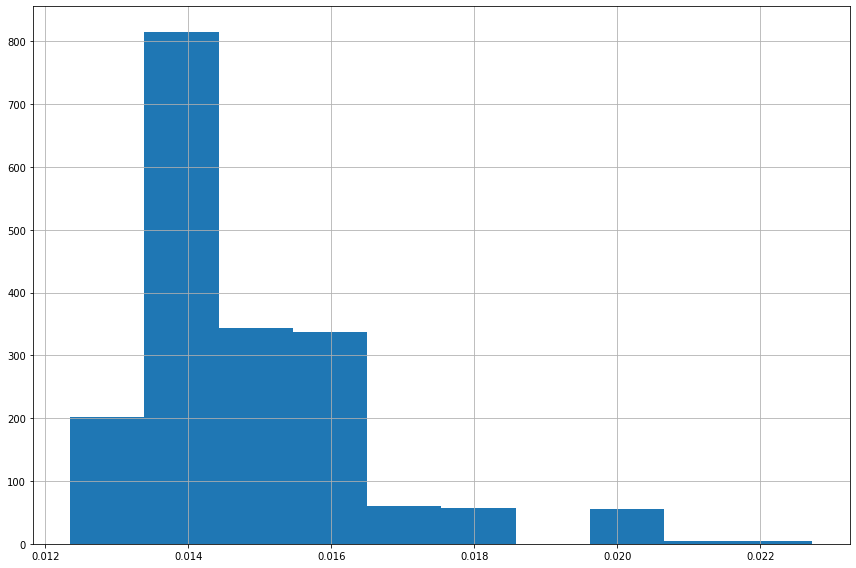

In [25]:
df_household.consumer_score.hist()
plt.show()

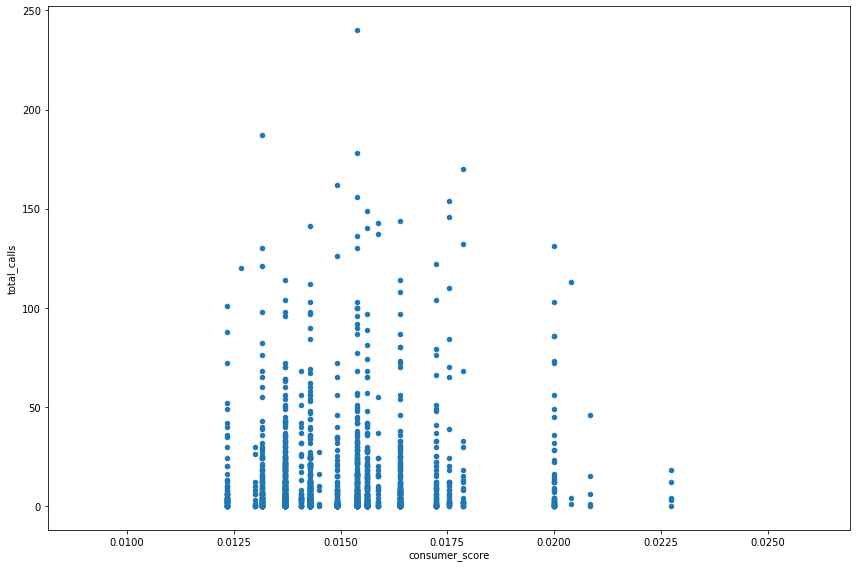

In [26]:
df_household.plot(x='consumer_score', y='total_calls',kind='scatter')

In [27]:
df_household.head()

membership_id  household_key       income member_status state_grouped credit_ranges cancel_reason renew_method plus_indicator_description   zip sc_vehicle_manufacturer_name sc_vehicle_model_name                          race  home_owner     education                             dwelling_type   gender occupation_code    occupation_group occupant_type    mosaic_household  mosaic_global_household kcl_b_ind_mosaicsgrouping                  generation               tenure  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  \
0            153        4500791    30-39,999        ACTIVE            RI       600-649       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2893                       TOYOTA                 CAMRY   CAUCASION / WHITE - ENGLISH  HOME OWNER  SOME COLLEGE  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER  UNKNOWN         UNKNOWN             UNKNOWN       UNKNOWN    SENIOR DISCOUNTS        LOW INCOME ELDERS     GOLDEN YEAR GUARDIANS           POST-WAR (< 1948)            +40 YEARS              0                       49       97.0000              15.0000             0                1            0                0                      0                   0             0                    0.0000           0          2.0000              33.8333       2.0000             0.0000            1.0000         8.0000                2.0000                5.0000            nan           0.0000                   nan                nan                  11.0000                          7.0000   
2            163       11622991    50-59,999        ACTIVE            RI       750-799       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2889                       SUBARU                   BRZ    HISPANIC - HISPANIC ORIGIN  HOME OWNER       UNKNOWN                                      SFDU  UNKNOWN         UNKNOWN             UNKNOWN       UNKNOWN  NO PLACE LIKE HOME  ROUTINE SERVICE WORKERS          THRIVING BOOMERS    MILLENIALS (1981 - 1993)  BETWEEN 1 & 5 YEARS              6                       59       47.6667               8.5556             0                0            0                0                      0                   0             0                    1.0000           0          1.0000              39.2056       6.0000             0.0000            2.0000         4.0000                0.0000                1.0000            nan           0.0000                   nan             1.0000                   3.0000                          3.0000   
3            182         579810    50-59,999        ACTIVE            RI       650-699       UNKNOWN       NOTICE           BASIC MEMBERSHIP  2863                     INFINITI                  QX56  CAUCASION / WHITE - EUROPEAN  HOME OWNER  SOME COLLEGE                                      SFDU     MALE         RETIRED     RETIRED - KNOWN       UNKNOWN         TOWN ELDERS   COMFORTABLE RETIREMENT     GOLDEN YEAR GUARDIANS           POST-WAR (< 1948)            +40 YEARS              0                       59       83.0000              15.0000             0                0            0                0                      0                   1             0                    0.0000           0          1.0000              28.0000       1.0000             0.0000            1.0000         4.0000                0.0000                3.0000         2.0000           0.0000                   nan                nan                   6.0000                          1.0000   
4            188        7187017  100-149,999        ACTIVE     

# Cars that are most likely to break down 
https://247wallst.com/special-report/2019/12/12/these-new-cars-are-most-likely-to-break-down/2/

# Top Car 35 Car brand according to consumer reports
https://www.autonews.com/retail/subaru-reaches-top-consumer-reports-rankings-tesla-falters


In [28]:
df_group_veh_manuf = df_transaction.groupby(by='sc_vehicle_manufacturer_name').agg(({'total_calls':sum, 
                                                                                     'total_cost' :['sum','mean']
                                                                                    }))

In [29]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21343 entries, 0 to 21342
Data columns (total 166 columns):
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
income                            object
da

In [30]:
df_household.groupby(by=var_to_predict).mean()

membership_id  household_key       zip  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  aaa_no_kcl_b_ind_mosaicsgrouping  aaa_no_occupation_code  aaa_no_occupation_group  aaa_no_occupant_type  aaa_no_plus_indicator_description  aaa_no_generation  total_calls_year_1  total_calls_year_2  total_calls_year_3  total_member_cost_1  total_member_cost_2  total_member_cost_3  basic_cost  plus_cost  premier_cost  mean_basic_cost  mean_plus_cost  mean_premier_cost  total_calls  total_member_cost  mean_total_member_cost  \
use_road_side                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0                114507.8870  14576852.8087 2894.3199         1.0145                  47.2998       73.7230               8.0082        0.0559           0.1409       0.0101           0.0000                 0.0559              0.2685        0.0582                    0.3510      0.1756          1.5834              17.5418       2.6786             0.0728            1.9695         5.0827                0.3658                2.4534         1.5421           0.1545                3.0645             3.7825                   8.4790                          2.7327                            3.9655                  7.2431                   5.1278                1.2857                             0.8580             0.7621              0.0000              0.0000              0.0000               0.0000               0.0000               1.3781     47.1713     3.7394        0.0906          16.1520          1.1675             0.0302       0.0000             1.3781                  0.1253   
1                110308.4860  15083333.9457 2888.5061         1.3554                  46.8106       69.9479               8.0957        0.1057           0.1419       0.0054           0.0020                 0.1057              0.3255        0.0680                    0.6833      0.1943          1.7692              33.7420       2.8716             0.0901            2.0253         4.9898                0.3583                2.5185         1.6378           0.2141                2.4250             4.2783                   9.7918                          2.8409                            4.5491                  7.4037                   5.9058                1.3130                             1.0032             1.3987              2.8297              5.5066              5.6652             153.3750             300.4290             291.3106    195.4534    15.9041        0.0073          31.1917          2.2368             0.0020      14.0015           745.1146                 94.8691   

               total_tow_miles  mean_tow_miles  to

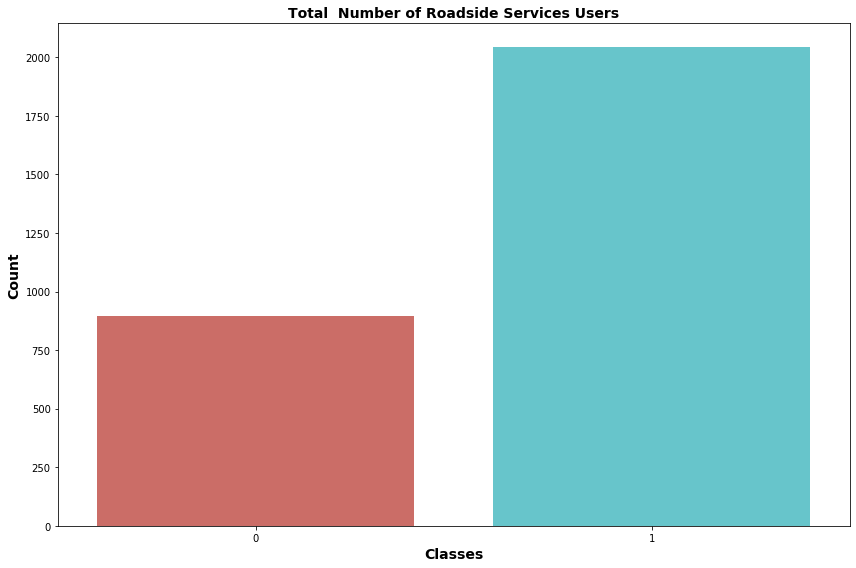

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x=var_to_predict[0],data=df_household, palette='hls')
plt.title('Total  Number of '+var_to_predict_title + ' Users',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.ylabel("Count",fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=14, fontweight='bold')
plt.savefig(var_to_predict_save+'_count_plot')
plt.show()

In [32]:
# Number of members in household key
df_household.total_members_in_household.value_counts()

2     1041
1      723
3      588
4      359
5      154
6       44
7       25
9        1
10       1
8        1
Name: total_members_in_household, dtype: int64

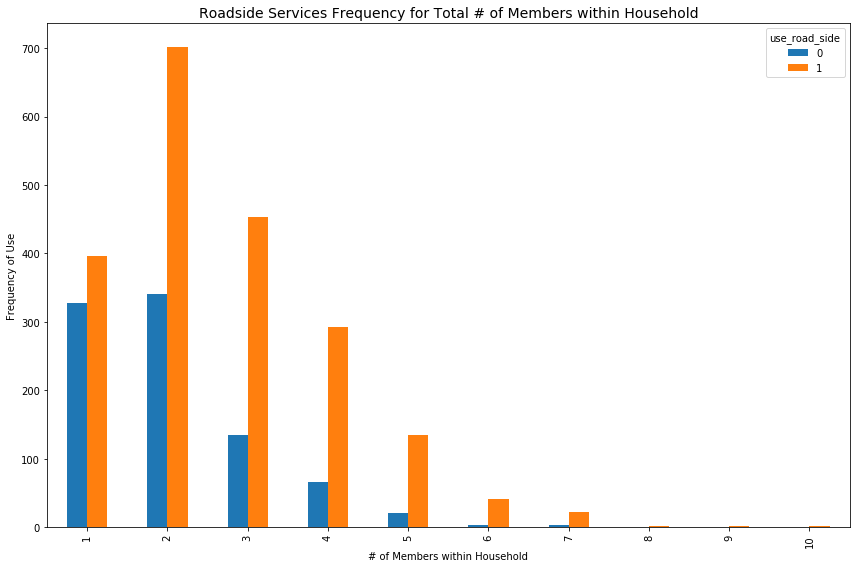

In [33]:
# graph income
pd.crosstab(df_household.total_members_in_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title + ' Frequency for Total # of Members within Household')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_use_'+var_to_predict_save)
plt.show()

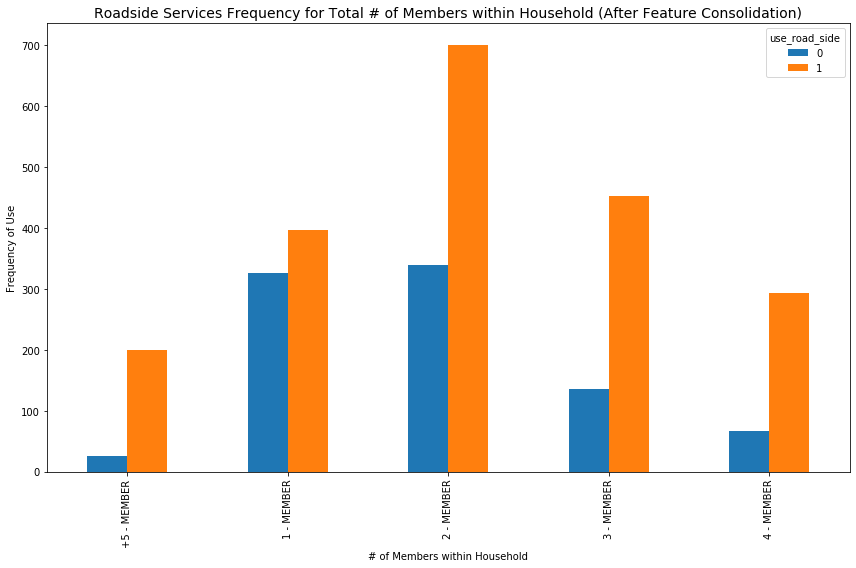

In [34]:
# Number of members

df_household['no_members'] = ' '
df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                    df_household['no_members'])

df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                    df_household['no_members'])
group5 = np.arange(5,20,1)
for i in group5:
    df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                    df_household['no_members'])
    
pd.crosstab(df_household.no_members,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Total # of Members within Household (After Feature Consolidation)')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_'+var_to_predict_save+'_feat')

In [35]:
# Income
df_household.income.value_counts()

UNKNOWN          715
100-149,999      484
90-99,999        437
70-79,999        195
50-59,999        193
40-49,999        142
10-19,999        133
175 - 199,999    107
60-69,999         98
30-39,999         94
150 - 174,999     89
20-29,999         77
200 - 249,999     68
250K+             67
UNDER 10K         36
80-89,999          2
Name: income, dtype: int64

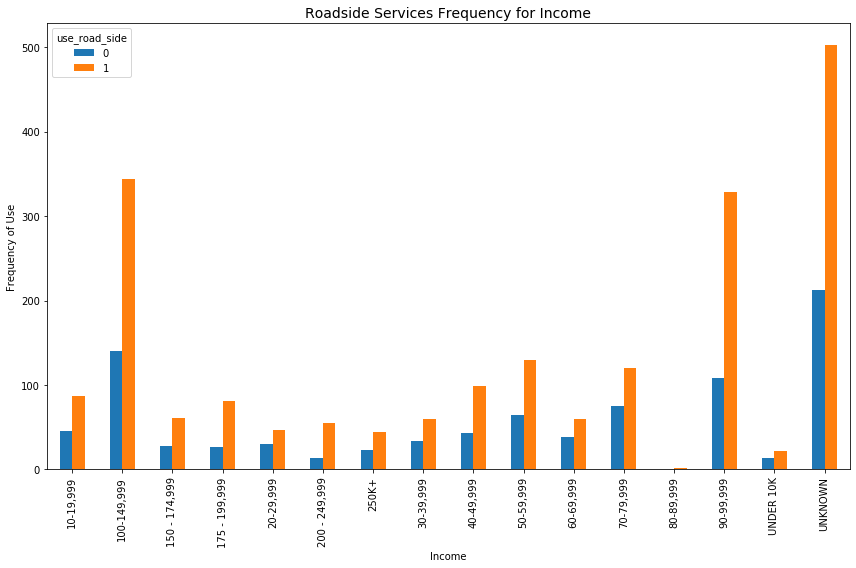

In [36]:
# graph income
pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavvily on income. 
Will consolidate income in three categories: 
    * a) under 10k - 39999: Under 39.999
    * b) 40 - 99,999 : 40 - 99,999
    * c) 100k and above : 100+
    

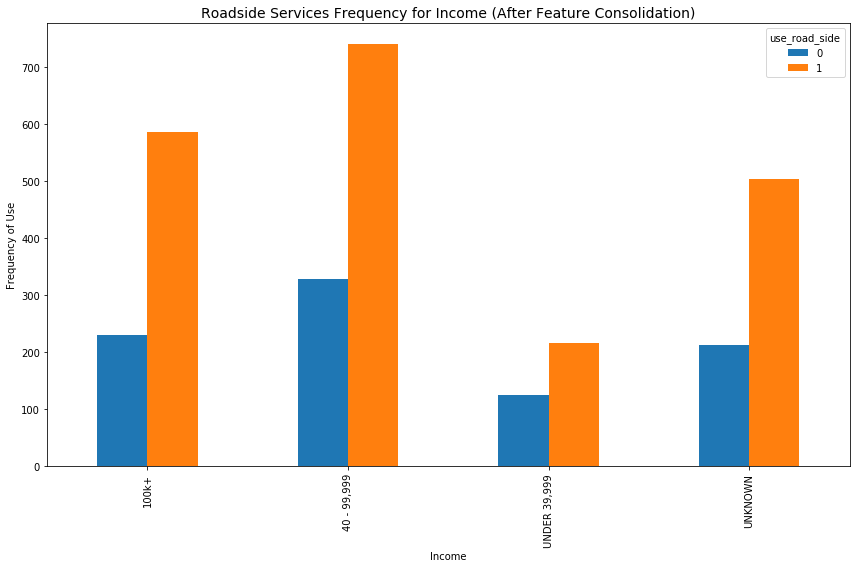

In [37]:
group1 = ['UNDER 10K', '10-19,999','20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])

pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income (After Feature Consolidation)')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_feat_'+var_to_predict_save)

In [38]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                1813
BETWEEN 21 & 30 YEARS     247
BETWEEN 31 & 40 YEARS     234
BETWEEN 11 & 15 YEARS     193
BETWEEN 6 & 10 YEARS      188
BETWEEN 16 & 20 YEARS     162
BETWEEN 1 & 5 YEARS        93
< 1 YEAR                    7
Name: tenure, dtype: int64

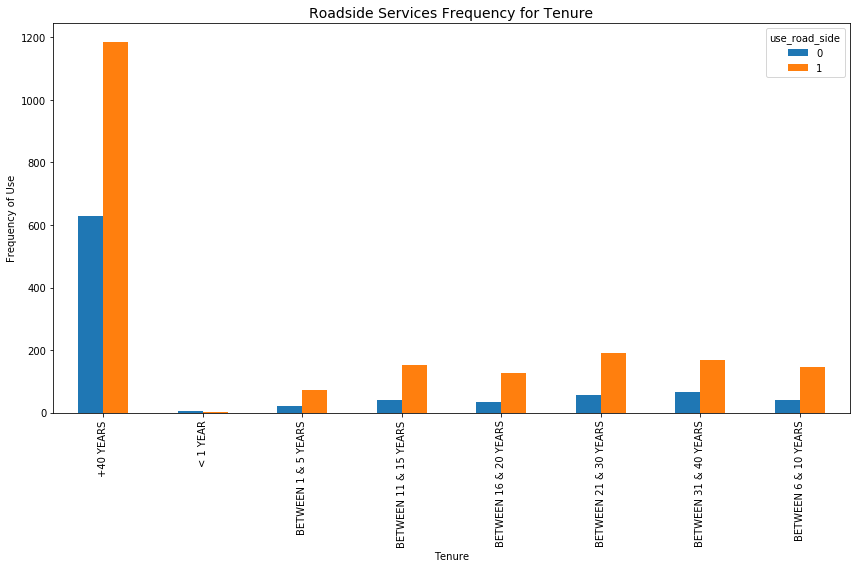

In [39]:
# graph tenure
pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on tenures. Will consolidate tenure in three categories: 
    * a) above 40 years  
    * b) between 21 - 40 
    * c) Less 21 


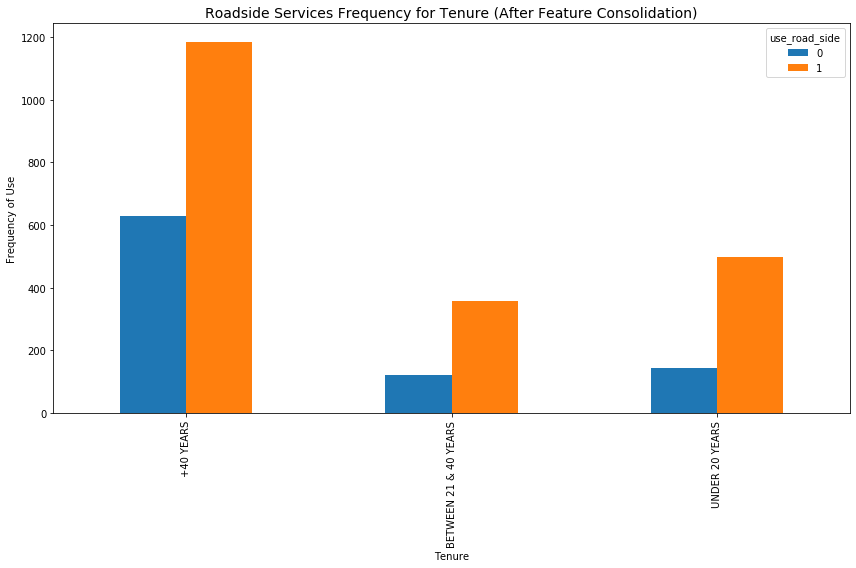

In [40]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])

pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_feat_'+var_to_predict_save)

In [41]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       787
750-799       782
700-749       468
800+          349
650-699       338
600-649       155
550-599        32
500-549        24
499 & LESS      2
Name: credit_ranges, dtype: int64

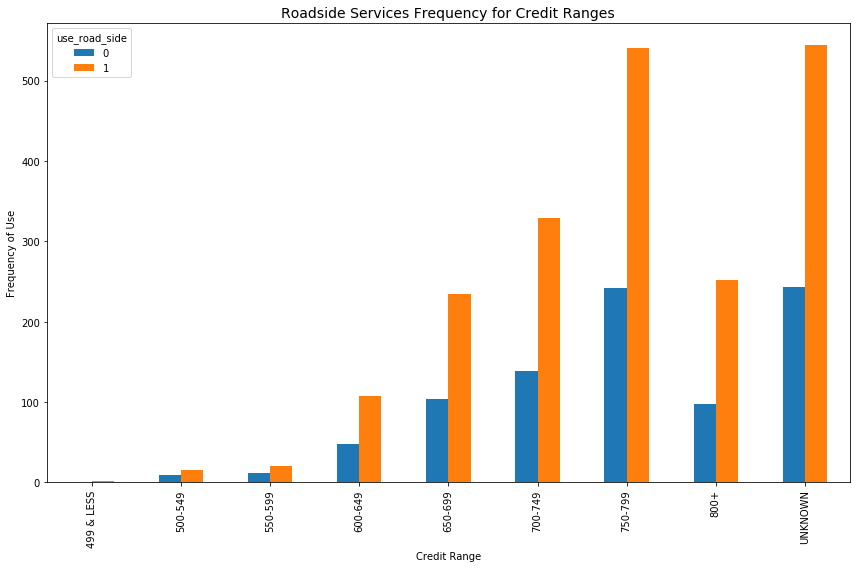

In [42]:
# graph credit ranges
pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on credit_ranges. Will consolidate tenure in three categories: 
    * a) above 800 years 
    * b) between 700 - 799 
    * c) Below 700

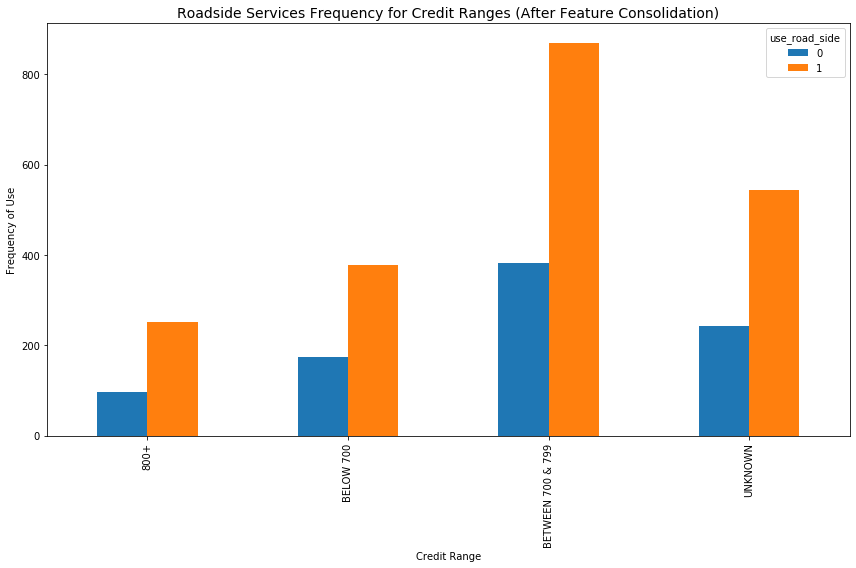

In [43]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])

pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges (After Feature Consolidation)')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_feat_'+var_to_predict_save)

In [44]:
# Education
df_household.education.value_counts()

UNKNOWN              1377
SOME COLLEGE          615
HIGH SCHOOL           570
COMPLETED COLLEGE     337
GRADUATED SCHOOL       38
Name: education, dtype: int64

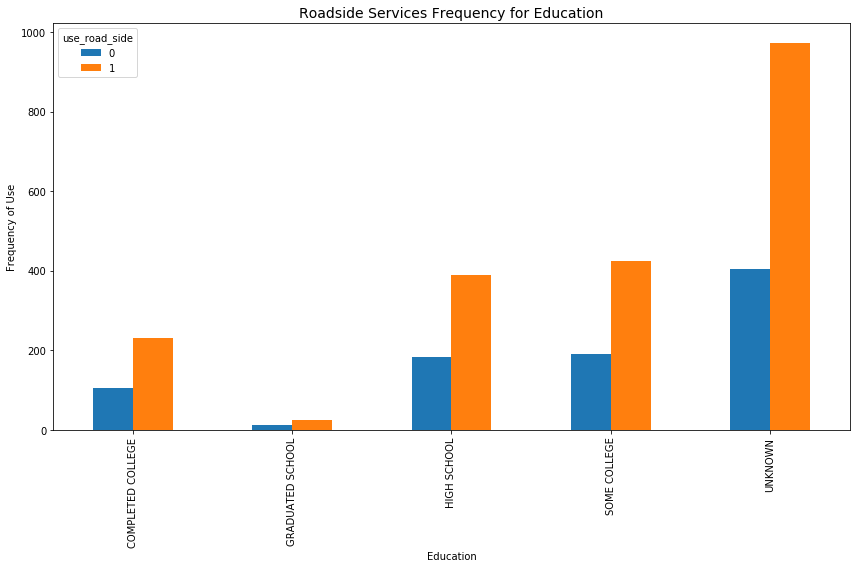

In [45]:
# graph education
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on education. Will consolidate graduate with completed collegue

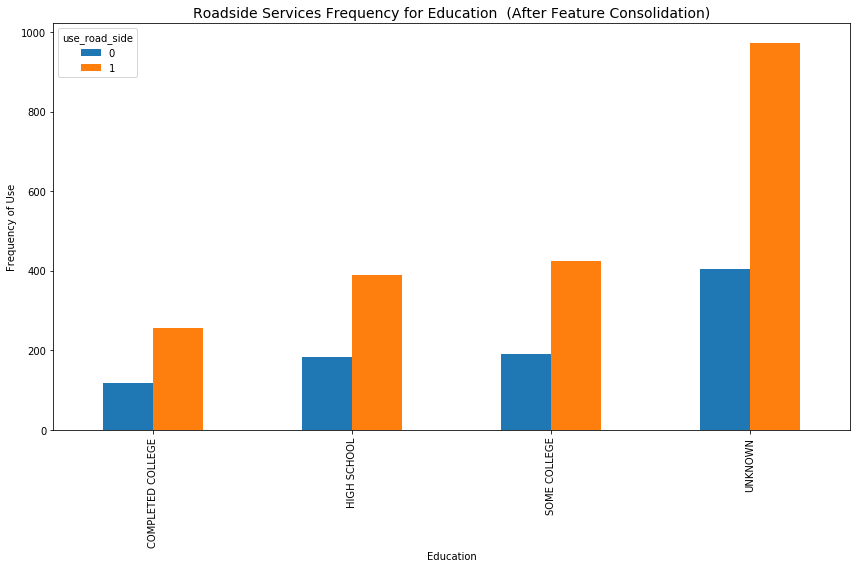

In [46]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education  (After Feature Consolidation)')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_feat_'+var_to_predict_save)

In [47]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             1817
BABY BOOMERS (1948 - 1968)     805
GENERATION X (1969 - 1980)     141
MILLENIALS (1981 - 1993)       112
UNKNOWN                         51
GENERATION Z (1994 - 2010)      11
Name: generation, dtype: int64

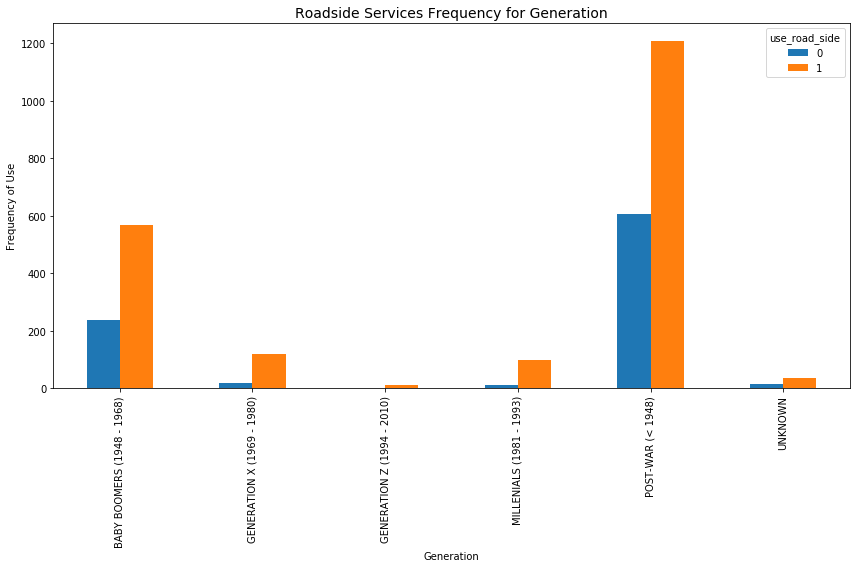

In [48]:
# graph Generation
pd.crosstab(df_household.generation,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Generation')
plt.xlabel('Generation')
plt.ylabel('Frequency of Use')
plt.savefig('generation_use_'+var_to_predict_save)

In [49]:
# Race
df_household.race.value_counts()

CAUCASION / WHITE - EUROPEAN              1000
UNKNOWN                                    755
CAUCASION / WHITE - ENGLISH                544
CAUCASION / WHITE - WHITE NON-AMERICAN     194
CAUCASION / WHITE - UNKNOWN                 93
MIDDLE EASTERN - ARAB                       80
HISPANIC - HISPANIC ORIGIN                  68
CAUCASION / WHITE - EASTERN EUROPEAN        63
HISPANIC - PORTUGUESE ORIGIN                63
ASIAN - CHINESE                             16
CAUCASION / WHITE - JEWISH                  15
CAUCASION / WHITE - GREEK                   13
ASIAN - UNKNOWN                              9
AFRICAN AMERICAN - AFRICAN ORIGIN            7
ASIAN - INDIAN                               5
AMERICAN INDIAN                              4
ASIAN - JAPANESE                             4
MIDDLE EASTERN - EGYPTIAN                    3
ASIAN - ORIENTAL                             1
Name: race, dtype: int64

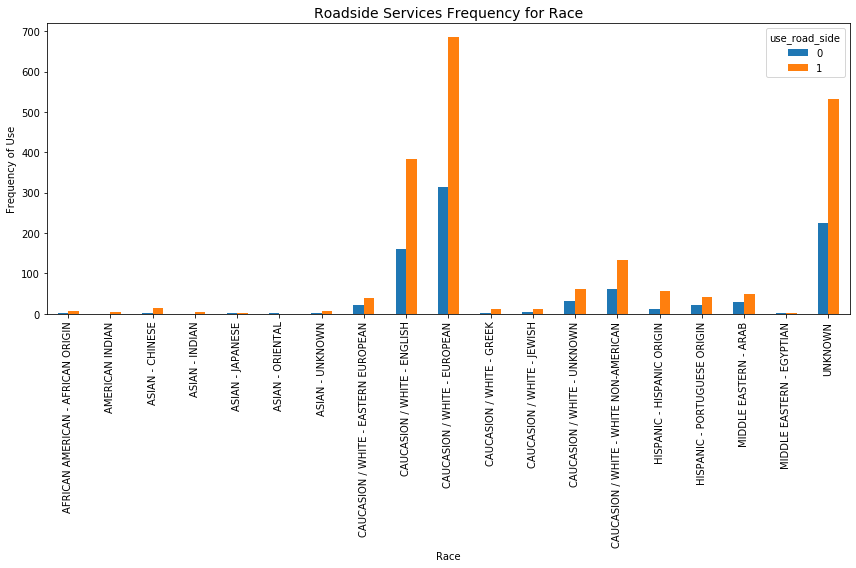

In [50]:
# graph race
pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_'+var_to_predict_save)

# Observations
The frequency of id theft Service use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
    * a) Caucasion - White
    * b) Hispanic
    * c) Asian
    * d) Arabs
    * e) America Africans / Indians

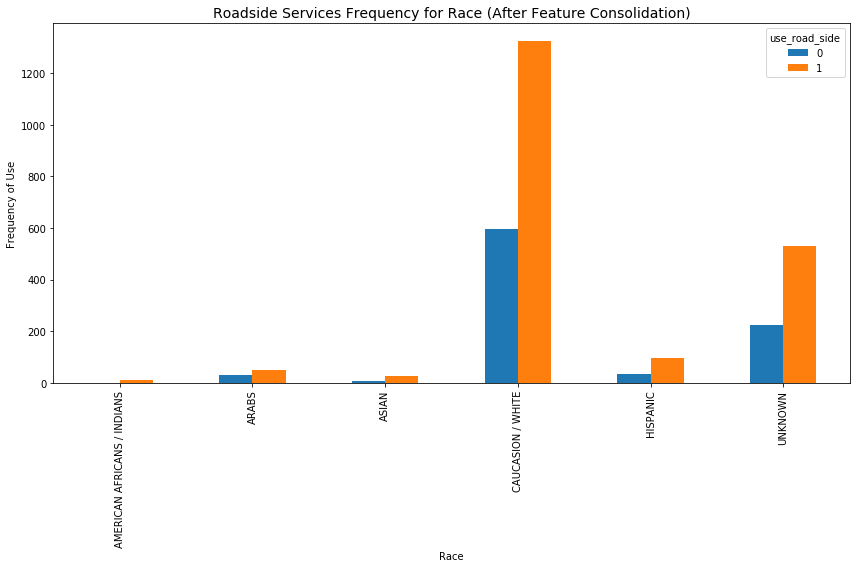

In [51]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race (After Feature Consolidation)')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_feat_'+var_to_predict_save)

In [52]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             2091
UNKNOWN                 769
RENTER                   75
PROBABLE HOME OWNER       1
PROBABLE RENTER           1
Name: home_owner, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

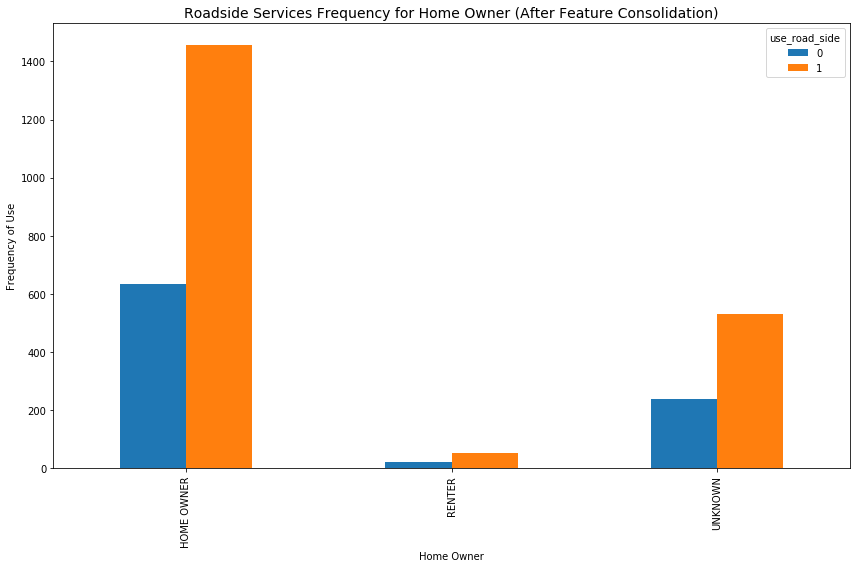

In [53]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])

pd.crosstab(df_household.home_owner,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Owner (After Feature Consolidation)')
plt.xlabel('Home Owner')
plt.ylabel('Frequency of Use')
plt.savefig('home_owner_use_feat_'+var_to_predict_save)

In [54]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN    2937
Name: cancel_reason, dtype: int64

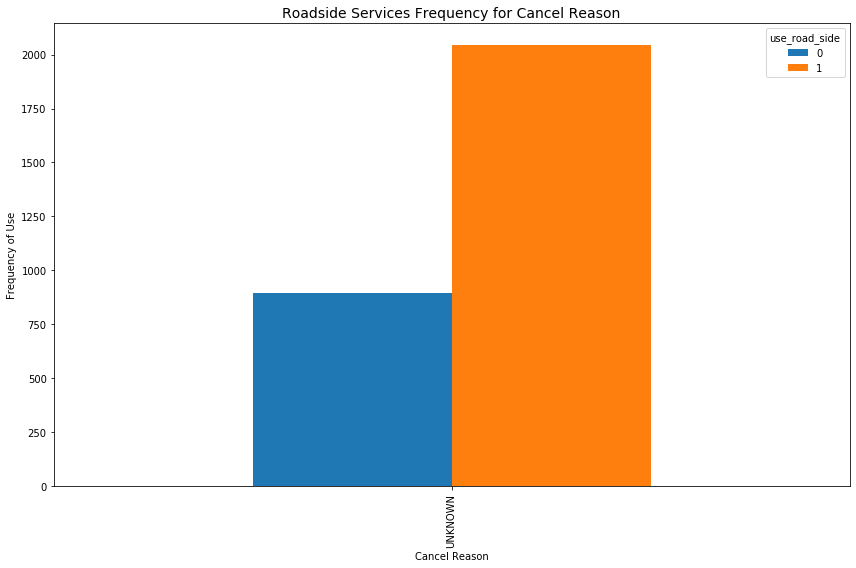

In [55]:
# graph Cancel Reason
pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason')
plt.xlabel('Cancel Reason')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_'+var_to_predict_save)

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not id theft. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

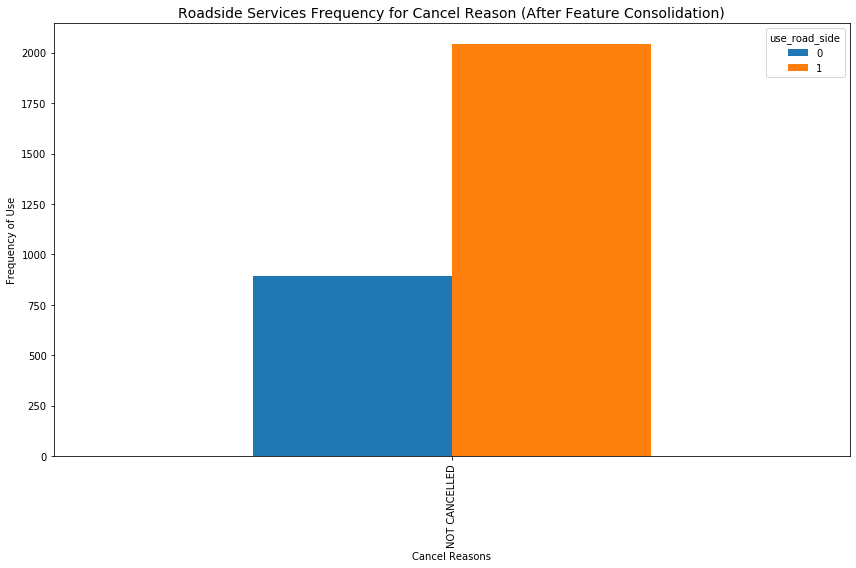

In [56]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])

pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason (After Feature Consolidation)')
plt.xlabel('Cancel Reasons')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_feat_'+var_to_predict_save)

In [57]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       706
AGING IN PLACE                509
SILVER SOPHISTICATES          228
REAPING REWARDS               169
NO PLACE LIKE HOME            142
TOWN ELDERS                   138
ROOTED FLOWER POWER           120
SENIOR DISCOUNTS               92
AGING OF AQUARIUS              92
SETTLED IN SUBURBIA            79
FULL POCKETS  EMPTY NESTS      61
BLUE COLLAR COMFORT            42
PLATINUM PROSPERITY            38
PROGRESSIVE POTPOURRI          35
BOHEMIAN GROOVE                33
AMERICAN ROYALTY               32
DIGITAL DEPENDENTS             32
FAMILY FUN-TASTIC              30
GOLF CARTS AND GOURMETS        27
UNSPOILED SPLENDOR             23
BIRKENSTOCKS AND BEEMERS       23
BOOMERS AND BOOMERANGS         22
FAST TRACK COUPLES             21
PICTURE PERFECT FAMILIES       20
MID-SCALE MEDLEY               19
STATUS SEEKING SINGLES         19
COLLEGES AND CAFES             16
GENERATIONAL SOUP              16
SETTLED AND SENSIBLE           16
STOCKCARS AND 

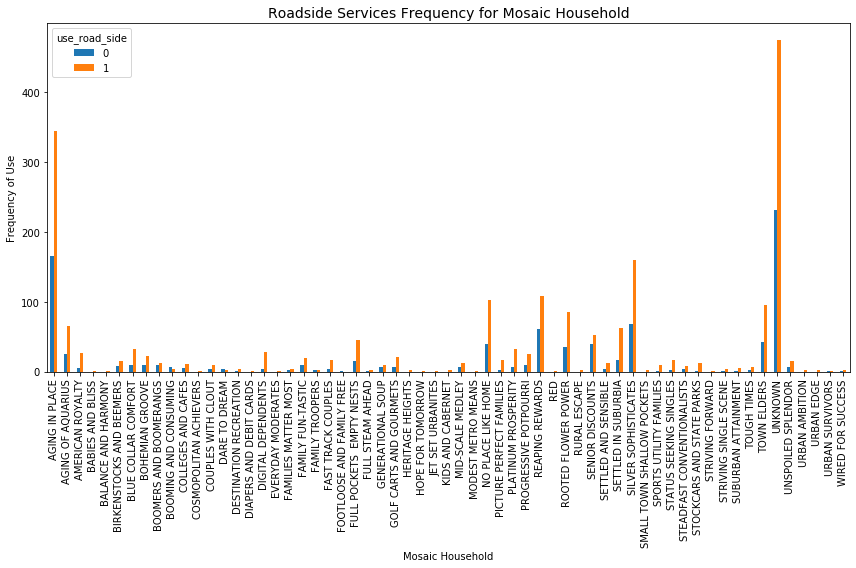

In [58]:
# graph Mosaic household
pd.crosstab(df_household.mosaic_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Household')
plt.xlabel('Mosaic Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_household_use_'+var_to_predict_save)

In [59]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

COMFORTABLE RETIREMENT       843
UNKNOWN                      706
BOURGEOIS PROSPERITY         510
ROUTINE SERVICE WORKERS      313
POST INDUSTRIAL SURVIVORS    125
HARD WORKING BLUE COLLAR     122
LOW INCOME ELDERS            112
CAREER AND FAMILY            110
METROPOLITAN STRUGGLERS       70
SOPHISTICATED SINGLES         25
RURAL INHERITANCE              1
Name: mosaic_global_household, dtype: int64

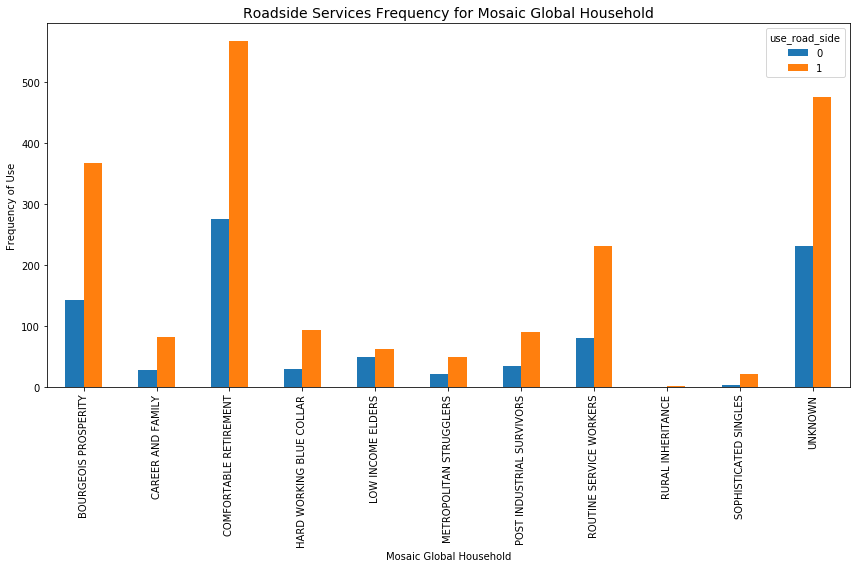

In [60]:
# graph Mosaic Global household
pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Global Household')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, these three groups can be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

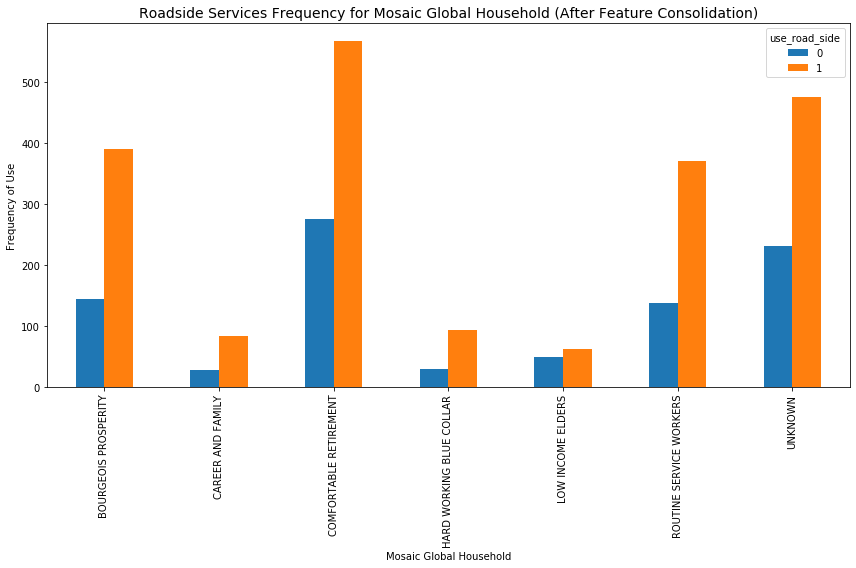

In [61]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Mosaic Global Household (After Feature Consolidation)')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_feat_'+var_to_predict_save)

In [62]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     706
AUTUMN YEARS                528
GOLDEN YEAR GUARDIANS       400
BOOMING WITH CONFIDENCE     369
THRIVING BOOMERS            226
BLUE SKY BOOMERS            130
POWER ELITE                 107
SURBURBAN STYLE              96
FAMILY UNION                 69
MIDDLE CLASS MELTING POT     64
SINGLES AND STARTERS         62
FLOURISHING FAMILIES         48
SIGNIFICANT SINGLES          36
PROMISING FAMILIES           28
CULTURAL CONNECTIONS         23
YOUNG CITY SOLOS             22
ECONOMIC CHALLENGES          13
ASPIRATIONAL FUSION           8
FAMILIES IN MOTION            2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

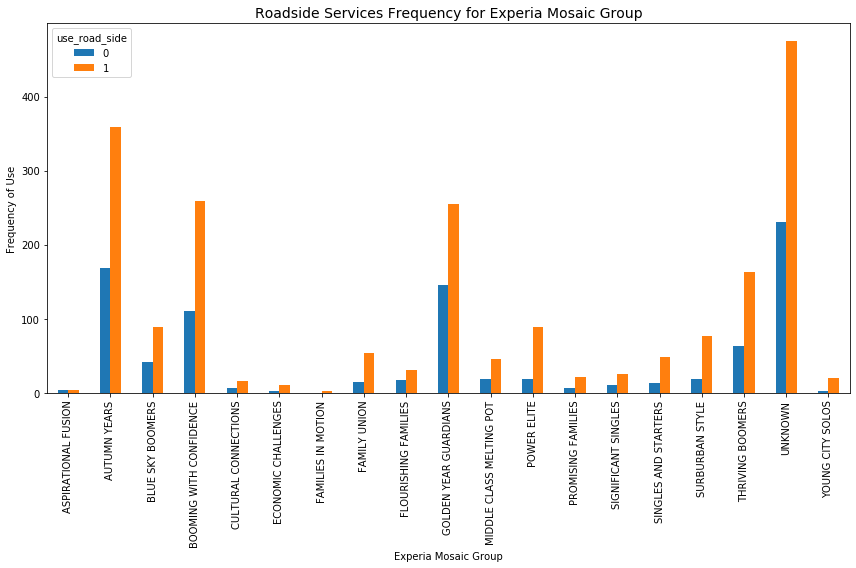

In [63]:
# graph kcl_b_ind_mosaicsgrouping
pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Experia Mosaic Group')
plt.xlabel('Experia Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

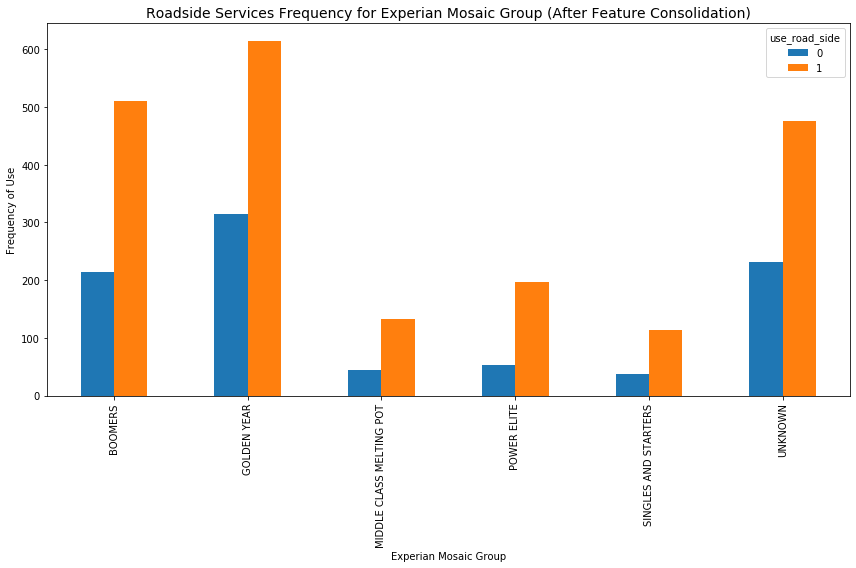

In [64]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])

pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Experian Mosaic Group (After Feature Consolidation)')
plt.xlabel('Experian Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_feat_'+var_to_predict_save)

In [65]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN            874
TOYOTA             360
FORD               247
HONDA              234
CHEVROLET          154
NISSAN             106
HYUNDAI            105
BUICK               91
SUBARU              75
DODGE               60
JEEP                52
CHRYSLER            50
LEXUS               48
MERCEDES-BENZ       42
VOLKSWAGEN          40
MAZDA               38
KIA                 38
MERCURY             38
CADILLAC            33
VOLVO               28
ACURA               27
BMW                 26
LINCOLN             25
GMC                 24
SATURN              23
PONTIAC             22
AUDI                14
INFINITI            13
SAAB                10
OLDSMOBILE           7
MINI                 6
SCION                5
LAND ROVER           5
PLYMOUTH             4
FIAT                 3
MITSUBISHI           3
JAGUAR               2
GEO                  1
ISUZU                1
HARLEY DAVIDSON      1
PORSCHE              1
AMERICAN AUSTIN      1
Name: sc_vehicle_manufacturer_name

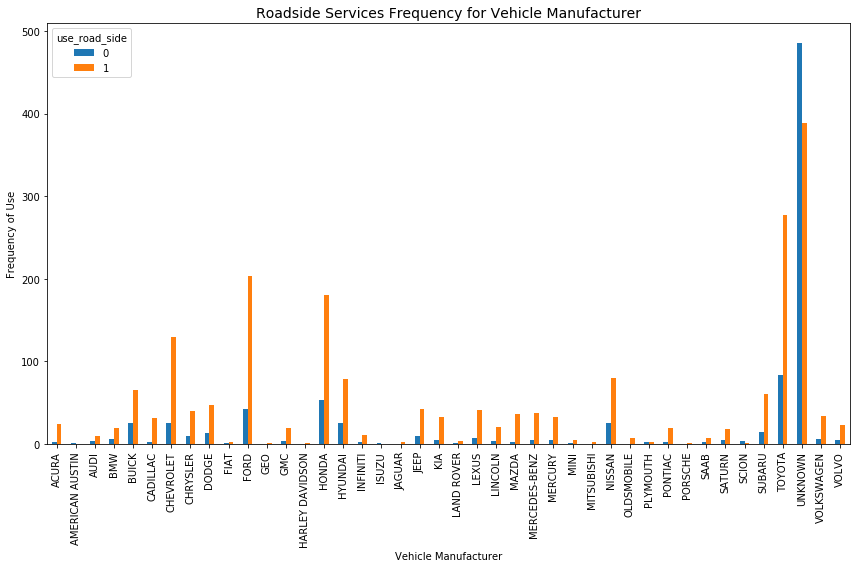

In [66]:
# graph Vehicle manufacturer
pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

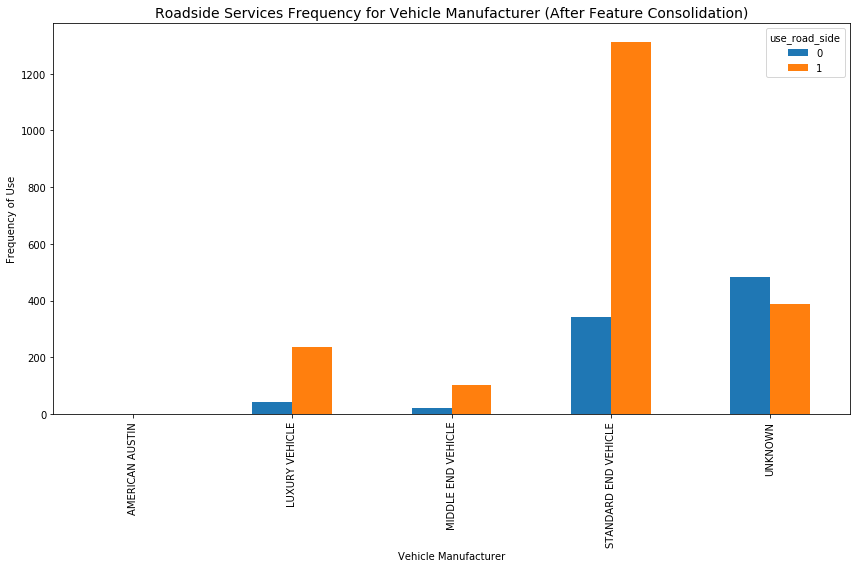

In [67]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])


pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer (After Feature Consolidation)')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_feat_'+var_to_predict_save)

In [68]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            2149
RETIRED                             186
PROFESSIONAL/TECHNICAL              101
UPPER MANAGEMENT/EXECUTIVE           72
NURSE                                71
CLERICAL/OFFICE                      50
TEACHER/EDUCATOR                     49
MIDDLE MANAGEMENT                    49
SKILLEDTRADE/MACHINE/LABORER         44
SALES/MARKETING                      25
BEAUTY                               18
REAL ESTATE                          13
SELF EMPLOYED                        12
EXECUTIVE/ADMINISTRATOR              10
ATTORNEYS                            10
HEALTH SERVICES                       9
PROFESSIONAL DRIVER                   6
PHARMACIST                            6
COUNSELORS                            6
COMPUTER PROFESSIONAL                 5
ENGINEERS                             5
MILITARY                              4
RETAIL SALES                          4
ARCHITECTS                            4
OCCUPATIONAL THER/PHYSICAL THER       4


In [69]:
df_household.occupation_group.value_counts()

UNKNOWN                             1260
RETIRED - INFERRED                   557
PROFESSIONAL - KNOWN                 268
RETIRED - KNOWN                      186
MANAGEMENT - KNOWN                   138
MANAGEMENT - INFERRED                 75
OTHER - INFERRED                      57
OFFICE ADMINISTRATION - INFERRED      55
BLUE COLLAR - KNOWN                   51
OFFICE ADMINISTRATION - KNOWN         50
PROFESSIONAL - INFERRED               49
BLUE COLLAR - INFERRED                45
SALES - KNOWN                         42
OTHER - KNOWN                         39
TECHNICAL - INFERRED                  28
SALES - INFERRED                      23
TECHNICAL - KNOWN                     14
Name: occupation_group, dtype: int64

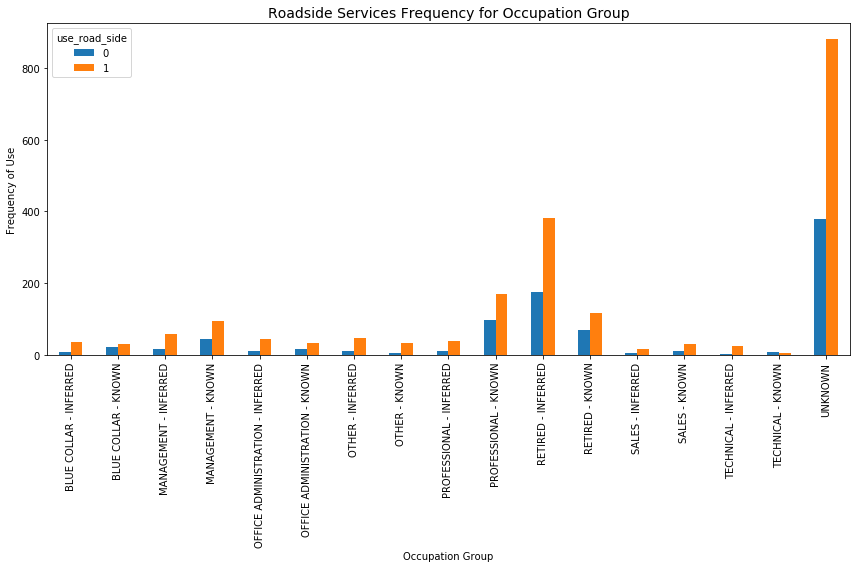

In [70]:
# graph ocuppation group
pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

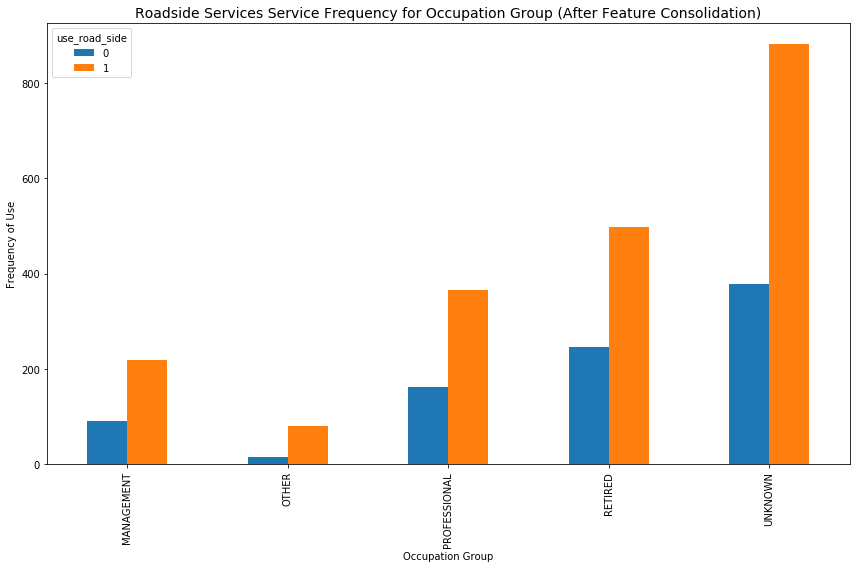

In [71]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Service Frequency for Occupation Group (After Feature Consolidation)')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_feat_'+var_to_predict_save)

In [72]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      2842
HOMEOWNER      64
RENTER         31
Name: occupant_type, dtype: int64

In [73]:
# graph member status
df_household.member_status.value_counts()


ACTIVE     2662
PENDING     275
Name: member_status, dtype: int64

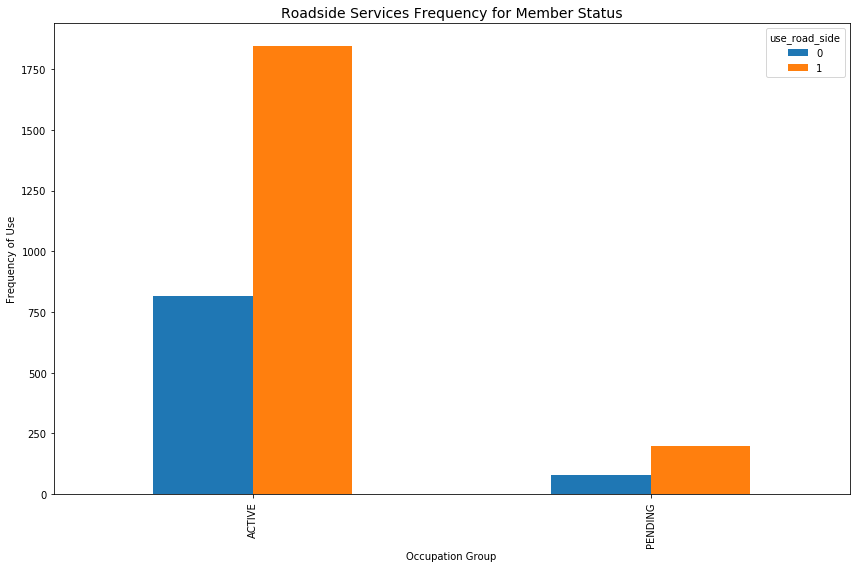

In [74]:
# graph member status group
pd.crosstab(df_household.member_status,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Member Status')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('member_status_use_'+var_to_predict_save)

In [75]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    2917
1      20
Name: aaa_deposit, dtype: int64

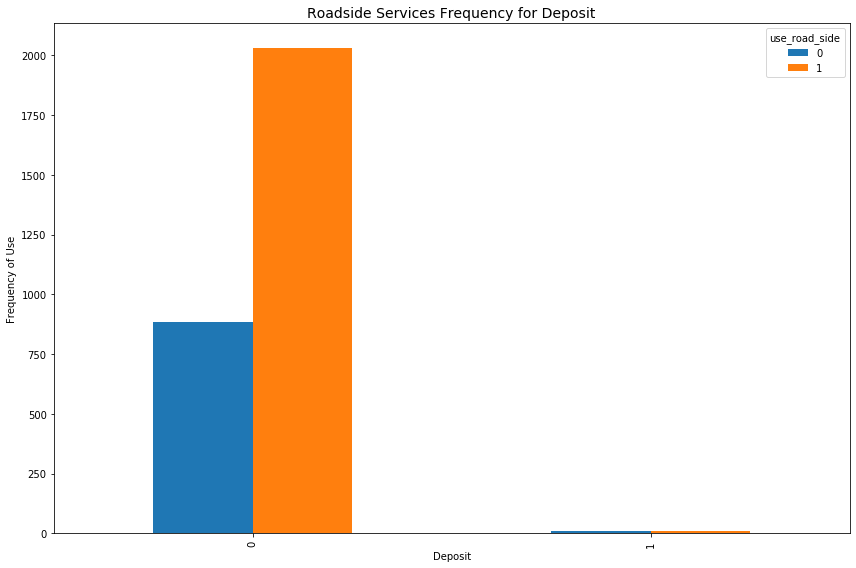

In [76]:
# graph Deposit
pd.crosstab(df_household.aaa_deposit,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Deposit')
plt.xlabel('Deposit')
plt.ylabel('Frequency of Use')
plt.savefig('deposit_use_'+var_to_predict_save)

In [77]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

0    2671
1     266
Name: aaa_financial_service, dtype: int64

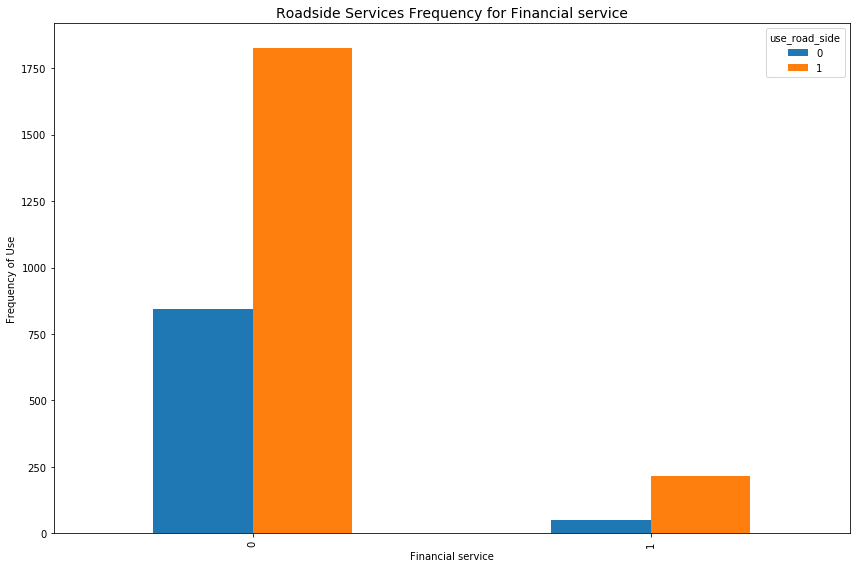

In [78]:
# graph Financial service
pd.crosstab(df_household.aaa_financial_service,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Financial service')
plt.xlabel('Financial service')
plt.ylabel('Frequency of Use')
plt.savefig('financial_service_use_'+var_to_predict_save)

In [79]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    2933
1       4
Name: aaa_home_equity, dtype: int64

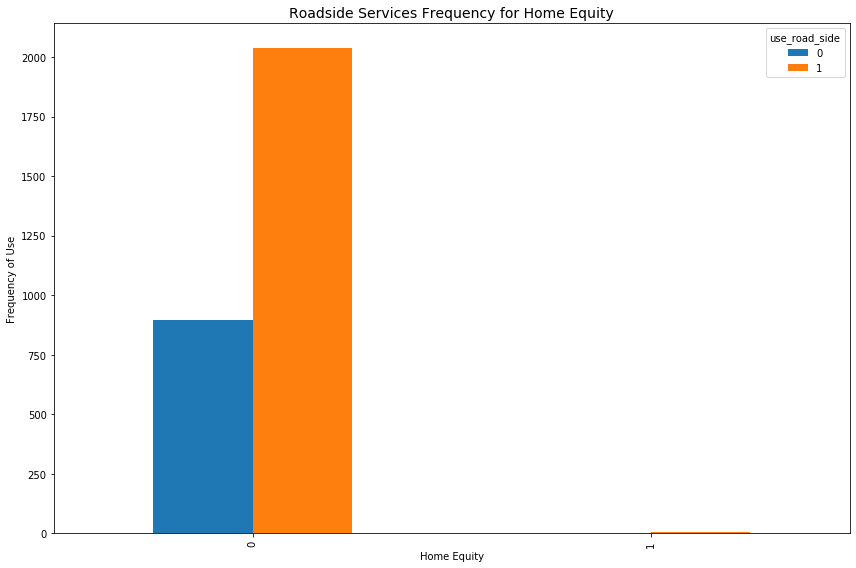

In [80]:
# graph home_equity
pd.crosstab(df_household.aaa_home_equity,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Equity')
plt.xlabel('Home Equity')
plt.ylabel('Frequency of Use')
plt.savefig('home_equity_use_'+var_to_predict_save)

In [81]:
# graph mortgage
df_household.aaa_mortgage.value_counts()

0    2671
1     266
Name: aaa_mortgage, dtype: int64

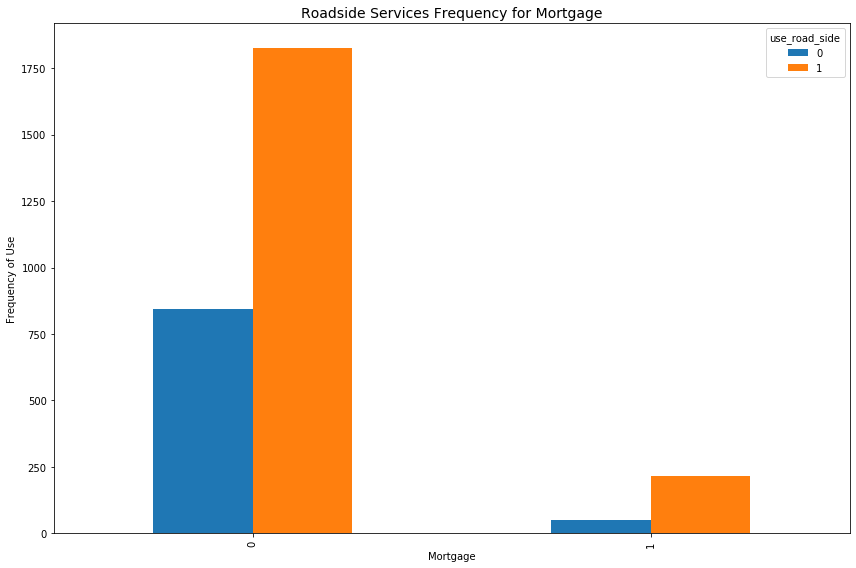

In [82]:
# graph Mortgage group
pd.crosstab(df_household.aaa_mortgage,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mortgage')
plt.xlabel('Mortgage')
plt.ylabel('Frequency of Use')
plt.savefig('mortgage_use_'+var_to_predict_save)

In [83]:
# graph credit card
df_household.aaa_credit_card.value_counts()

0    2521
1     416
Name: aaa_credit_card, dtype: int64

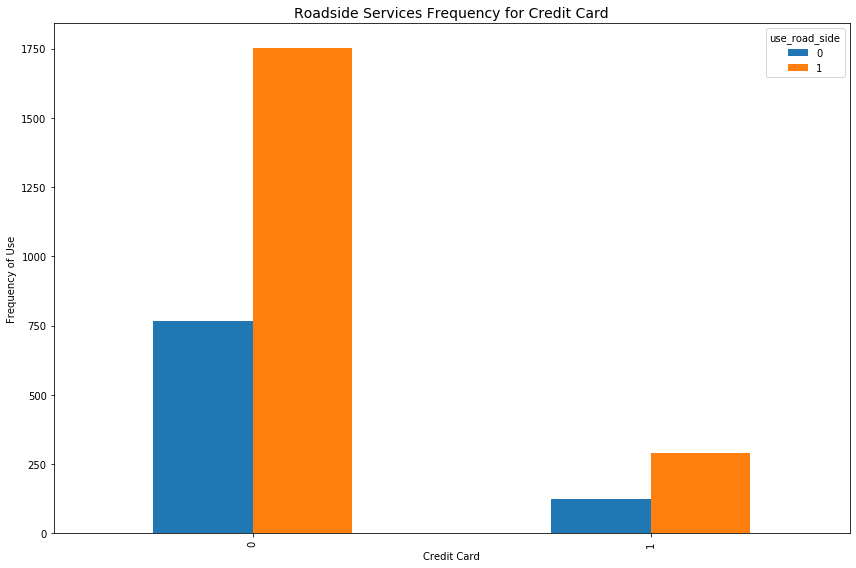

In [84]:
# graph Credit card group
pd.crosstab(df_household.aaa_credit_card,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Card')
plt.xlabel('Credit Card')
plt.ylabel('Frequency of Use')
plt.savefig('credit_card_use_'+var_to_predict_save)

In [85]:
# graph auto insurance
df_household.aaa_auto_insurance.value_counts()

0    2032
1     905
Name: aaa_auto_insurance, dtype: int64

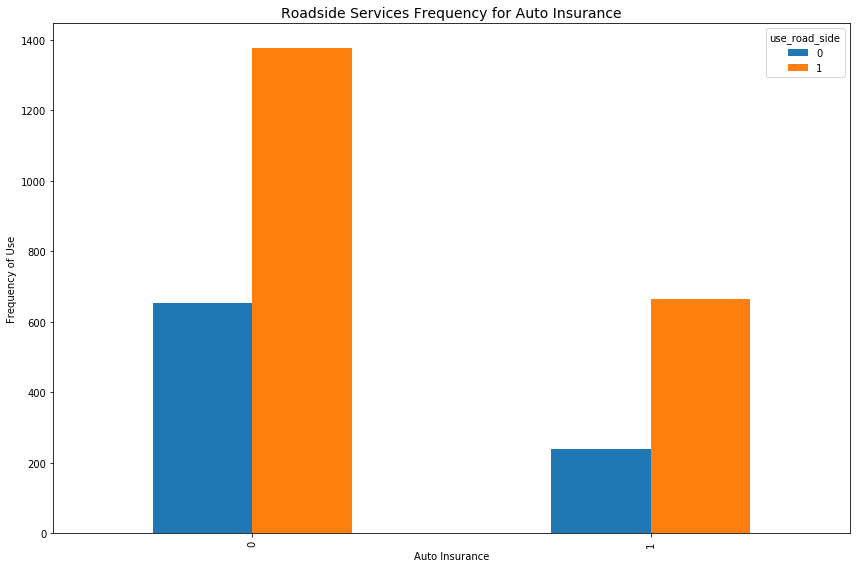

In [86]:
# graph auto insurance group
pd.crosstab(df_household.aaa_auto_insurance,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Auto Insurance')
plt.xlabel('Auto Insurance')
plt.ylabel('Frequency of Use')
plt.savefig('auto_insurance_use_'+var_to_predict_save)

In [87]:
# graph id theft service
df_household.aaa_id_theft.value_counts()

0    2746
1     191
Name: aaa_id_theft, dtype: int64

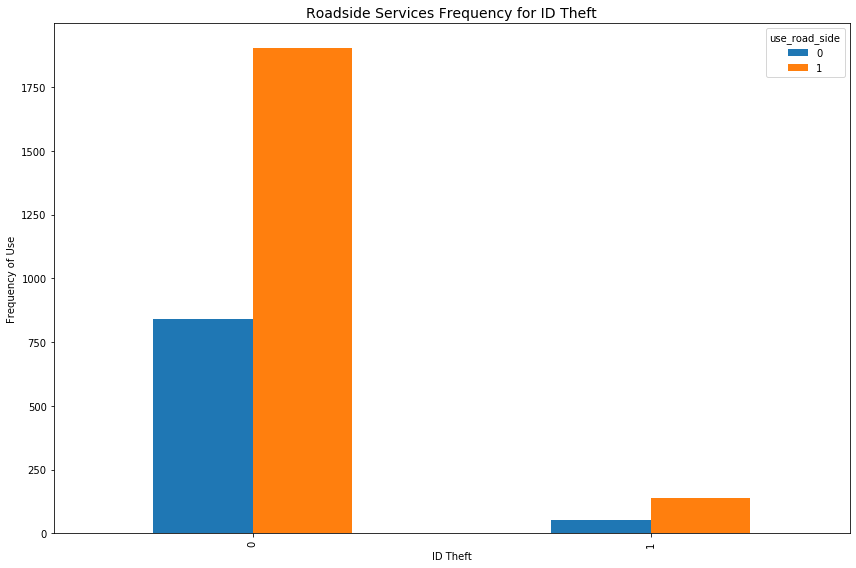

In [88]:
# graph id theft service
pd.crosstab(df_household.aaa_id_theft,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for ID Theft')
plt.xlabel('ID Theft')
plt.ylabel('Frequency of Use')
plt.savefig('id_theft_use_'+var_to_predict_save)

# Model to predict Roadside Service Usage by household key

Previous Columns Used
* cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
                       occupation_code, occupation_group, occupant_type, vehicle, sc_vehicle_model_name

* feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost', 'mean_total_member_cost', 'mean_total_cost'
* feature_cols = ['no_members', 'total_calls', 'mean_total_member_cost', 'mean_total_cost',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost']

# Final Observation (Need update)

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [89]:
# Re initiate all features and data
def reiniciar(df_household):
    df_household = read_data('household_view.csv')
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']

    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                        df_household.consumer_score)
    # Remove members with status CANCELLED
    df_household = df_household[df_household.member_status!='CANCELLED']
    return df_household

In [90]:
df_household.groupby(by=var_to_predict)['total_cost'].mean()

use_road_side
0    51.6867
1   213.5721
Name: total_cost, dtype: float64

In [91]:
df_household.groupby(by=var_to_predict)['total_calls'].mean()

use_road_side
0    0.0000
1   14.0015
Name: total_calls, dtype: float64

In [92]:
df_household.groupby(by=var_to_predict)['total_member_cost'].mean()

use_road_side
0     1.3781
1   745.1146
Name: total_member_cost, dtype: float64

In [93]:
df_household.groupby(by=var_to_predict)['basic_cost'].mean()

use_road_side
0    47.1713
1   195.4534
Name: basic_cost, dtype: float64

In [94]:
df_household.groupby(by=var_to_predict)['plus_cost'].mean()

use_road_side
0    3.7394
1   15.9041
Name: plus_cost, dtype: float64

In [95]:
df_household.groupby(by=var_to_predict)['premier_cost'].mean()

use_road_side
0   0.0906
1   0.0073
Name: premier_cost, dtype: float64

# Reload data to conduct another experiment

In [96]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 5260
Data columns (total 88 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

* Full features
cols_house_dummmies = ['income', 'credit_ranges','education', 'generation', 'aaa_financial_service',
                       'aaa_deposit', 'plus_indicator_description', 'aaa_credit_card', 'occupation_group',
                       'sc_vehicle_manufacturer_name', 'kcl_b_ind_mosaicsgrouping','dwelling_type',
                       'aaa_motorcycle_indicator', 'mosaic_global_household', 'tenure', 'aaa_auto_insurance',
                       'aaa_id_theft', 'no_members'
             ]
feature_cols = ['total_calls', 'mean_total_member_cost', 'mean_total_cost', 'aaa_mean_child',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost', 'length_of_residence'
               ]

In [ ]:
df_household.groupby(by=['use_road_side', 'length_of_residence']).mean()

In [ ]:
df_household.info()

In [279]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)
cols_house_dummmies = ['aaa_financial_service','plus_indicator_description', 
                       'occupation_group','sc_vehicle_manufacturer_name', 'tenure', 'aaa_auto_insurance',
                       'no_members', 'gender', 'kcl_b_ind_mosaicsgrouping','education',
                       
                      ]
feature_cols = ['mean_total_calls_veh', 'consumer_score', 'mean_total_cost_veh', 'mean_total_member_cost_veh',
                'mean_tow_miles', 'length_of_residence', 'aaa_mean_child'
               ]

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)

# Stripping out spaces from ends of names, and replacing internal spaces with "_"
df_prediction.columns = [col.strip().replace(' ', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('&', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('+', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(',', '').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('(', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(')', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('<', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('.', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('/', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('-', '_').lower() for col in df_prediction.columns]

# Fix Nans
# Number of child
df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
df_prediction.consumer_score.fillna(value=0, inplace=True)
# Drop Unknown Columns 
cols_to_drop = [j for j in df_prediction.columns if j.endswith('unknown')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()

df_prediction.head(5)

mean_total_calls_veh  consumer_score  mean_total_cost_veh  mean_total_member_cost_veh  mean_tow_miles  length_of_residence  aaa_mean_child  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  tenure__40_years  tenure_between_21___40_years  tenure_under_20_years  aaa_auto_insurance_0  aaa_auto_insurance_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  gender_female  gender_male  kcl_b_ind_mosaicsgrouping_boomers  \
0                2.5485          0.0137              47.0448                    132.3705          0.0889              15.0000          2.0000                        1                        0                                            1                                           0                                                  0                                                                0                            0                       0                              0                         0                                             0                                            0                                                0                                                  1                 1                             0                      0                     1                     0                       0                      1                      0                      0                      0              0            0                                  0   
2                2.3971          0.0123              46.9483                    117.0838          0.0000               8.5556          1.0000                        1                        0                                            1                                           0                                                  0                                                                0                            0                       0                              0                         0                                             0                                            0                                                0                                                  1                 0                             0                      1                     1                     0                       0                      0                      0                      0                      1              0            0                                  1   
3                3.7444          0.0143              47.6622                    208.3822          0.0000              15.0000          1.0000                        1                        0                                            1                                           0                                                  0                                                                0                            0                       0                              0                         1                                             0                                            1                                                0                                                  0                 1                             0                      0                     0                     1                       0                      1                      0                      0                      0              0            1                                  0   
4                3.1964

In [280]:
df_prediction.describe()

mean_total_calls_veh  consumer_score  mean_total_cost_veh  mean_total_member_cost_veh  mean_tow_miles  length_of_residence  aaa_mean_child  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  tenure__40_years  tenure_between_21___40_years  tenure_under_20_years  aaa_auto_insurance_0  aaa_auto_insurance_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  gender_female  gender_male  kcl_b_ind_mosaicsgrouping_boomers  \
count             2937.0000       2937.0000            2937.0000                   2937.0000       2937.0000            2937.0000       2937.0000                2937.0000                2937.0000                                    2937.0000                                   2937.0000                                          2937.0000                                                        2937.0000                    2937.0000               2937.0000                      2937.0000                 2937.0000                                     2937.0000                                    2937.0000                                        2937.0000                                          2937.0000         2937.0000                     2937.0000              2937.0000             2937.0000             2937.0000               2937.0000              2937.0000              2937.0000              2937.0000              2937.0000      2937.0000    2937.0000                          2937.0000   
mean                 1.9957          0.0095              33.0597                    106.0340          1.3383               8.0691          1.4659                   0.9094                   0.0906                                       0.3953                                      0.2836                                             0.0007                                                           0.0238                       0.1052                  0.0327                         0.1801                    0.2530                                        0.0003                                       0.0957                                           0.0426                                             0.5638            0.6173                        0.1638                 0.2189                0.6919                0.3081                  0.0769                 0.2462                 0.3544                 0.2002                 0.1222         0.3224       0.2475                             0.2469   
std                  1.2244          0.0072              21.6023                     65.7507          3.3242               5.6942          1.0682                   0.2870                   0.2870                                       0.4890                                      0.4508                                             0.0261                                                           0.1526                       0.3069                  0.1778                         0.3843                    0.4348                                        0.0185                                       0.2942                                           0.2019                                             0.4960            0.4861                        0.3701                 0.4136                0.4618                0.4618                  0.2666                 0.4309                 0.4784                 0.4002                 0.3276         0.4675       0.4317                             0.4313   
min        

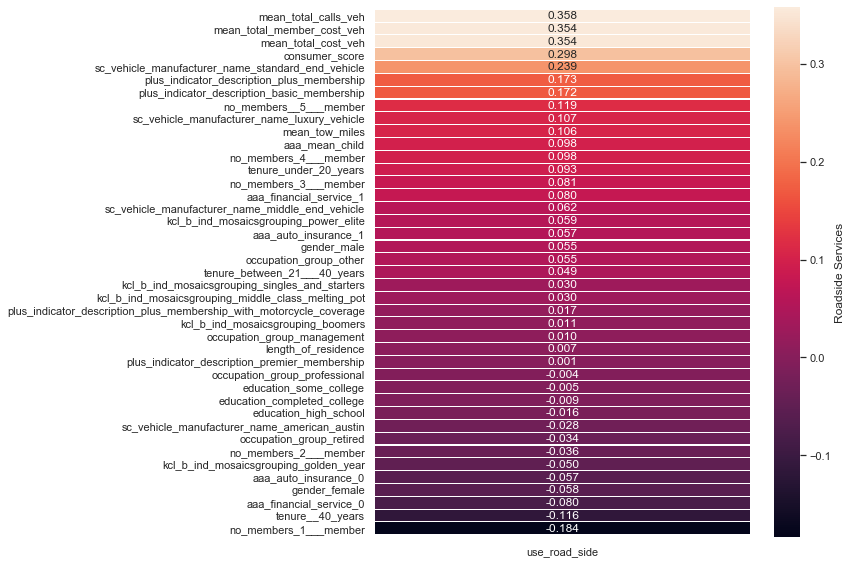

mean_total_calls_veh  consumer_score  mean_total_cost_veh  mean_total_member_cost_veh  mean_tow_miles  length_of_residence  aaa_mean_child  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  tenure__40_years  tenure_between_21___40_years  tenure_under_20_years  aaa_auto_insurance_0  aaa_auto_insurance_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  gender_female  \
mean_total_calls_veh                                              1.0000          0.8082               0.9707                      0.9955          0.2067               0.0269          0.0797                  -0.0236                   0.0236                                       0.4977                                      0.4099                                             0.0189                                                           0.0985                       0.0301                  0.0194                        -0.0011                   -0.0547                                       -0.0301                                       0.2688                                           0.1666                                             0.6715           -0.0728                       -0.0024                 0.0878               -0.0499                0.0499                  0.0663                -0.0512                -0.0161                -0.0013                 0.0384        -0.0786   
mean_total_member_cost_veh                                        0.9955          0.7983               0.9669                      1.0000          0.2109               0.0253          0.0796                  -0.0256                   0.0256                                       0.4916                                      0.4091                                             0.0191                                                           0.0983                       0.0298                  0.0193                        -0.0018                   -0.0540                                        0.0017                                       0.2809                                           0.1881                                             0.6476           -0.0753                       -0.0028                 0.0910               -0.0515                0.0515                  0.0690                -0.0531                -0.0167                 0.0003                 0.0379        -0.0793   
mean_total_cost_veh                                               0.9707          0.8418               1.0000                      0.9669          0.1980               0.0266          0.0658                  -0.0162                   0.0162                                       0.5199                                      0.4053                                             0.0173                                                           0.1082                       0.0243                  0.0232                        -0.0007                   -0.0611                                       -0.0052                                       0.2323                                           0.1384                                             0.7244           -0.0651                       -0.0067                 0.0825               -0.0489                0.0489                  0.0572                -0.0418                -0.0196                 0.0033                 0.0331        -0.0734   
consumer_score                                                    0.

In [325]:
#  Correlation of AAA Roadside service
# Heat Map 
df_corr = df_prediction.corr()
df_corr.sort_values(by=var_to_predict[0], ascending=False, inplace=True)
df_corr = df_corr[df_corr.index.values!=var_to_predict[0]]
sns.heatmap(df_corr[[var_to_predict[0]]], annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.savefig(var_to_predict_save+'_var_corr')
plt.show()
df_corr

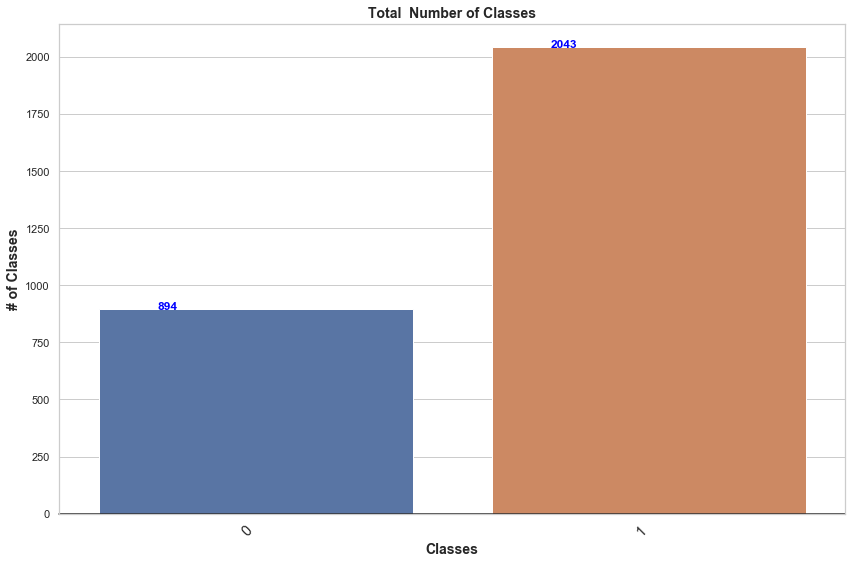

In [283]:
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})
draw_col_shape(df_prediction,var_to_predict)

Random over-sampling:
1    2043
0    2043
Name: use_road_side, dtype: int64


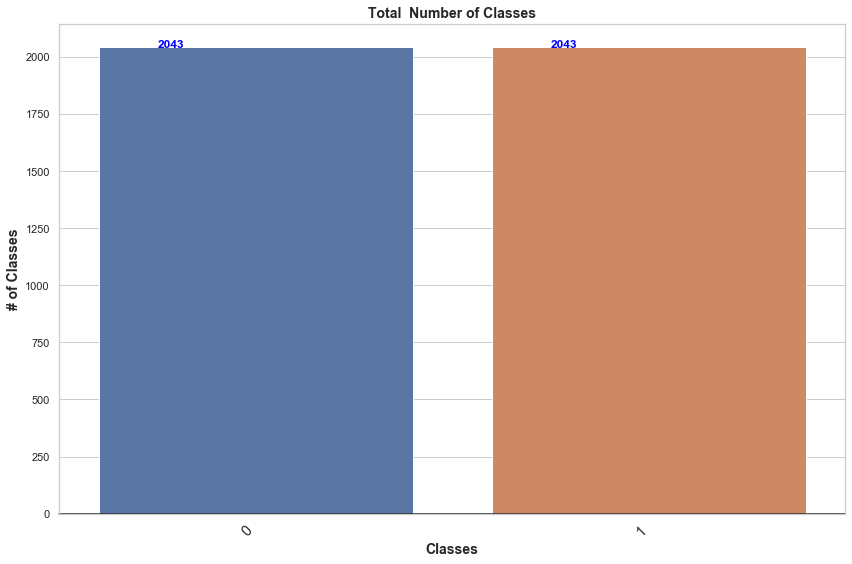

In [284]:
# Balance class Up Sampling
# As there is only 28 members that are using the Deposit Service.
# Will upsample the 11 (yes) to 5233
# Evaluate imbalanced classification model with different metrics

np.random.seed(42)
# Class count
count_class_1, count_class_0 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

Random down-sampling:
1    894
0    894
Name: use_road_side, dtype: int64


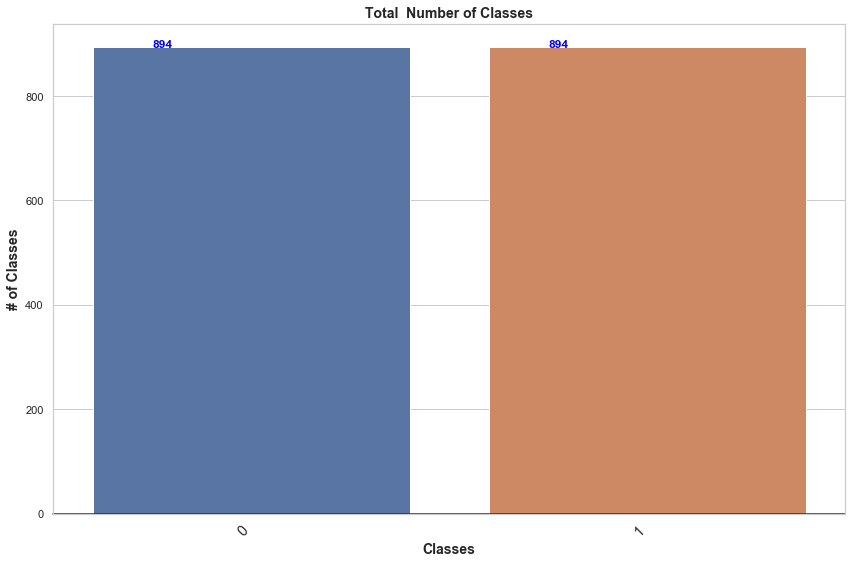

In [285]:
# Down sample Majority Class To Match Minority Class
# Indicies of each class' observations

np.random.seed(42)
count_class_1, count_class_0 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]

df_class_1_down = df_class_1.sample(count_class_0, replace=True)
df_test_down = pd.concat([df_class_0, df_class_1_down], axis=0)

print('Random down-sampling:')
print(df_test_down[var_to_predict[0]].value_counts())

draw_col_shape(df_test_down,var_to_predict)
plt.show()

In [286]:
df_test_over.corr()

mean_total_calls_veh  consumer_score  mean_total_cost_veh  mean_total_member_cost_veh  mean_tow_miles  length_of_residence  aaa_mean_child  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  tenure__40_years  tenure_between_21___40_years  tenure_under_20_years  aaa_auto_insurance_0  aaa_auto_insurance_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  gender_female  \
mean_total_calls_veh                                              1.0000          0.8502               0.9771                      0.9963          0.2260               0.0139          0.0846                  -0.0145                   0.0145                                       0.5505                                      0.4391                                             0.0186                                                           0.1088                       0.0214                  0.0139                         0.0150                   -0.0569                                       -0.0221                                       0.2812                                           0.1818                                             0.7191           -0.0780                        0.0146                 0.0797               -0.0444                0.0444                  0.0639                -0.0551                -0.0123                 0.0025                 0.0451        -0.0690   
consumer_score                                                    0.8502          1.0000               0.8768                      0.8407          0.2120               0.0155          0.0740                  -0.0056                   0.0056                                       0.4918                                      0.4024                                             0.0195                                                           0.1075                       0.0281                  0.0205                         0.0118                   -0.0536                                       -0.0182                                       0.0899                                           0.0944                                             0.7700           -0.0617                        0.0026                 0.0711               -0.0403                0.0403                  0.0638                -0.0389                -0.0367                 0.0153                 0.0437        -0.0549   
mean_total_cost_veh                                               0.9771          0.8768               1.0000                      0.9732          0.2200               0.0123          0.0739                  -0.0058                   0.0058                                       0.5670                                      0.4360                                             0.0171                                                           0.1222                       0.0185                  0.0181                         0.0117                   -0.0640                                       -0.0019                                       0.2472                                           0.1557                                             0.7644           -0.0706                        0.0117                 0.0735               -0.0433                0.0433                  0.0552                -0.0518                -0.0137                 0.0078                 0.0427        -0.0661   
mean_total_member_cost_veh                                        0.

In [287]:
df_test_down.describe()

mean_total_calls_veh  consumer_score  mean_total_cost_veh  mean_total_member_cost_veh  mean_tow_miles  length_of_residence  aaa_mean_child  aaa_financial_service_0  aaa_financial_service_1  plus_indicator_description_basic_membership  plus_indicator_description_plus_membership  plus_indicator_description_plus_membership_with_motorcycle_coverage  plus_indicator_description_premier_membership  occupation_group_management  occupation_group_other  occupation_group_professional  occupation_group_retired  sc_vehicle_manufacturer_name_american_austin  sc_vehicle_manufacturer_name_luxury_vehicle  sc_vehicle_manufacturer_name_middle_end_vehicle  sc_vehicle_manufacturer_name_standard_end_vehicle  tenure__40_years  tenure_between_21___40_years  tenure_under_20_years  aaa_auto_insurance_0  aaa_auto_insurance_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  gender_female  gender_male  kcl_b_ind_mosaicsgrouping_boomers  \
count             1788.0000       1788.0000            1788.0000                   1788.0000       1788.0000            1788.0000       1788.0000                1788.0000                1788.0000                                    1788.0000                                   1788.0000                                          1788.0000                                                        1788.0000                    1788.0000               1788.0000                      1788.0000                 1788.0000                                     1788.0000                                    1788.0000                                        1788.0000                                          1788.0000         1788.0000                     1788.0000              1788.0000             1788.0000             1788.0000               1788.0000              1788.0000              1788.0000              1788.0000              1788.0000      1788.0000    1788.0000                          1788.0000   
mean                 1.7766          0.0085              29.2220                     94.3294          1.1558               7.8602          1.4089                   0.9172                   0.0828                                       0.3523                                      0.2483                                             0.0000                                                           0.0218                       0.0984                  0.0229                         0.1874                    0.2623                                        0.0006                                       0.0744                                           0.0380                                             0.5089            0.6538                        0.1504                 0.1957                0.6957                0.3043                  0.0682                 0.2746                 0.3585                 0.1846                 0.1141         0.3339       0.2360                             0.2612   
std                  1.2820          0.0074              22.8354                     68.6593          3.3397               5.7646          1.0685                   0.2756                   0.2756                                       0.4778                                      0.4322                                             0.0000                                                           0.1461                       0.2980                  0.1497                         0.3903                    0.4400                                        0.0236                                       0.2625                                           0.1913                                             0.5001            0.4759                        0.3576                 0.3969                0.4602                0.4602                  0.2522                 0.4464                 0.4797                 0.3881                 0.3180         0.4717       0.4248                             0.4394   
min        

# Setting Up the Training and Test data for up Sampling the minority class
To use the same split in all models

In [288]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.40

# Create input and output dataframes
#X_df = pd.DataFrame(df_prediction,columns=X_cols)
#y_df = pd.DataFrame(df_prediction,columns=y_cols)

X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Algorithms Search and Testing

Roadside Services - Algorithm Comparison - Over Sampling
LR: Accuracy : 0.679295 - Std. Dev.: (0.024516)
LDA: Accuracy : 0.678483 - Std. Dev.: (0.022897)
KNN: Accuracy : 0.664629 - Std. Dev.: (0.013810)
CART: Accuracy : 0.777231 - Std. Dev.: (0.023558)
NB: Accuracy : 0.589552 - Std. Dev.: (0.025419)
SVM: Accuracy : 0.676458 - Std. Dev.: (0.028815)
SGD: Accuracy : 0.651151 - Std. Dev.: (0.020602)
AB: Accuracy : 0.684198 - Std. Dev.: (0.023613)
GBM: Accuracy : 0.716846 - Std. Dev.: (0.023722)
RF: Accuracy : 0.801709 - Std. Dev.: (0.027665)
ET: Accuracy : 0.813146 - Std. Dev.: (0.023641)
XGB: Accuracy : 0.710720 - Std. Dev.: (0.026074)


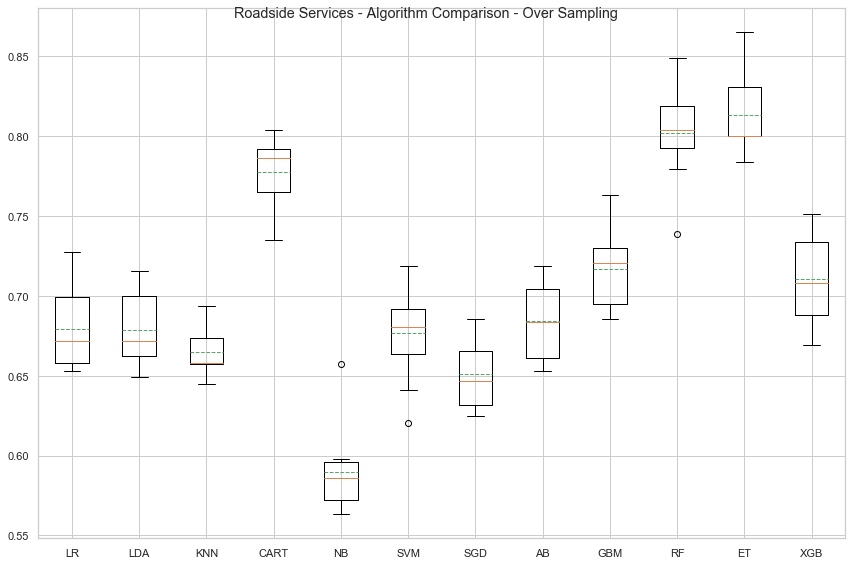

In [289]:
# Algorithms Search
# Spot Check Algorithms

print(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms')
plt.show()

# Setting Up the Training and Test data for Down Sampling the mayority class
To use the same split in all models

In [290]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.4

# Create input and output dataframes
X_df = pd.DataFrame(df_test_down,columns=X_cols)
y_df = pd.DataFrame(df_test_down,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

Roadside Services - Algorithm Comparison - Down Sampling
LR: Accuracy : 0.648304 - Std. Dev.: (0.040298)
LDA: Accuracy : 0.660410 - Std. Dev.: (0.039045)
KNN: Accuracy : 0.640853 - Std. Dev.: (0.056422)
CART: Accuracy : 0.626869 - Std. Dev.: (0.036797)
NB: Accuracy : 0.654829 - Std. Dev.: (0.037723)
SVM: Accuracy : 0.658567 - Std. Dev.: (0.058006)
SGD: Accuracy : 0.609078 - Std. Dev.: (0.065000)
AB: Accuracy : 0.667004 - Std. Dev.: (0.054472)
GBM: Accuracy : 0.666944 - Std. Dev.: (0.052321)
RF: Accuracy : 0.663292 - Std. Dev.: (0.055378)
ET: Accuracy : 0.661379 - Std. Dev.: (0.041259)
XGB: Accuracy : 0.666961 - Std. Dev.: (0.053871)


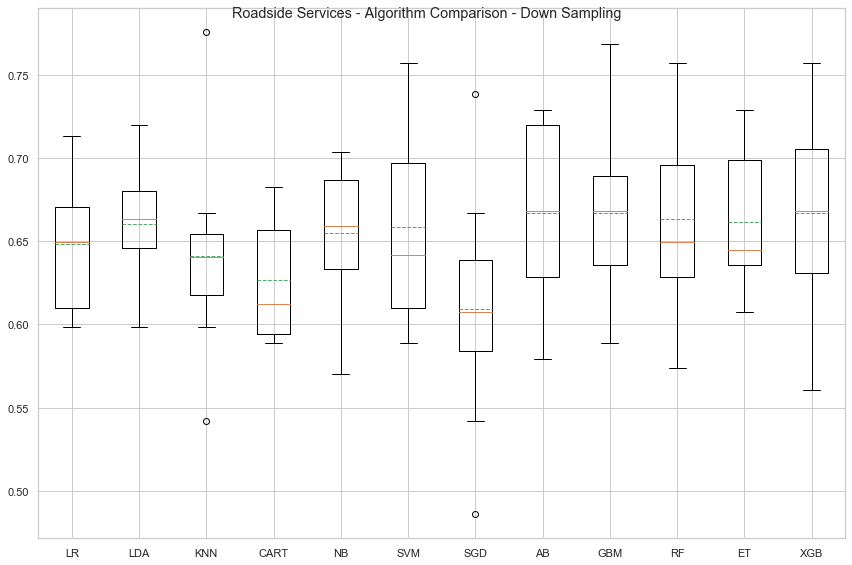

In [291]:
# Spot Check Algorithms
print(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms_down')
plt.show()

# Observation
Based on the previous graph, the model performs better by up sampling the minority class.  the rest of the analysis will be performed using the up sampling data.

In [292]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.40

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Grid Search Logistic Regression

In [294]:
# Grid Search with Up Sampling
# Logistic regression
np.random.seed(42)
logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l2',multi_class="auto"))])
# Grid search to determine the value of C and solver
param_grid = {'logreg__C':np.arange(0.01,200,10), 'logreg__solver':['lbfgs','liblinear','newton-cg']}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=num_folds,return_train_score=True, scoring=scoring)
logreg_cv.fit(trainX, trainy)
print('Logistic regression - Over Sampling the minority class')
print('Logistic Regression - Best Parameters       : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Logistic Regression - Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))
print('Logistic Regression - Accuracy Test Data     : %.3f' % bestlogreg.score(testX,testy))

Logistic regression - Over Sampling the minority class
Logistic Regression - Best Parameters       :  {'logreg__C': 90.01, 'logreg__solver': 'liblinear'}
Logistic Regression - Accuracy Training Data : 0.687
Logistic Regression - Accuracy Test Data     : 0.679


# Observation
These are the best parameters:

First run identifying C
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 90.01, 'logreg__solver': 'liblinear'}
    * Logistic Regression - Accuracy Training Data : 0.687
    * Logistic Regression - Accuracy Test Data     : 0.679
    
Narrowing the C paramenters to find the best having incremental of 1 instead of 10 around the best found previously
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 90.01, 'logreg__solver': 'liblinear'}
    * Logistic Regression - Accuracy Training Data : 0.687
    * Logistic Regression - Accuracy Test Data     : 0.679


Logistic Regression - Accuracy training          : 0.687
Logistic Regression - Accuracy test              : 0.679
Logistic Regression - Precision                  : 0.659
Logistic Regression - Recall                     : 0.714
Logistic Regression - F-measure                  : 0.685
Logistic Regression - Log-Loss                   : 11.091
Logistic Regression - Cross Entropy Loss         : 1.613
Logistic Regression - No Skill - ROC AUC         : 0.500
Logistic Regression - ROC AUC                    : 0.757
Logistic Regression - Cross Validation Accuracy  : 0.673 (+/- 0.082)


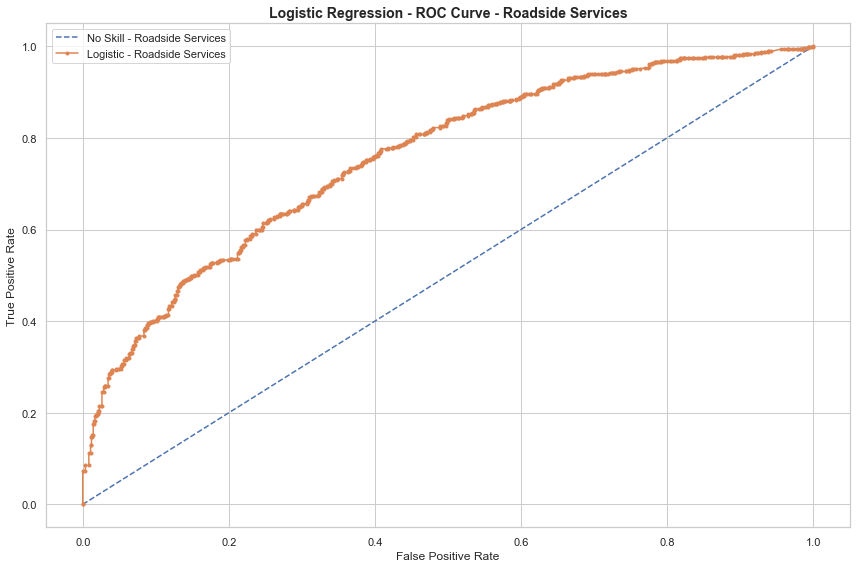

In [346]:
# Use Logistic Regression algorithms to classify which customers are going to use Deposit Service or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Define model 
lr = LogisticRegression(penalty='l2',multi_class="auto", solver="liblinear", C=92.01)

# Fit model
lr.fit(trainX, trainy)

# Predict on test set
yhat = lr.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = lr.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
lr_scores = cross_val_score(lr, testX, testy, cv=num_folds)

# Evaluate predictions
print('Logistic Regression - Accuracy training          : %.3f' % accuracy_score(lr.predict(trainX), trainy))
print('Logistic Regression - Accuracy test              : %.3f' % accuracy_score(testy, yhat))
print('Logistic Regression - Precision                  : %.3f' % precision_score(testy, yhat))
print('Logistic Regression - Recall                     : %.3f' % recall_score(testy, yhat))
print('Logistic Regression - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Logistic Regression - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Logistic Regression - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Logistic Regression - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic Regression - ROC AUC                    : %.3f' % (lr_auc))
print('Logistic Regression - Cross Validation Accuracy  : %0.3f (+/- %0.3f)' % (lr_scores.mean(), lr_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('Logistic Regression - ROC Curve - '+var_to_predict_title, loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_lr_roc')
plt.show()

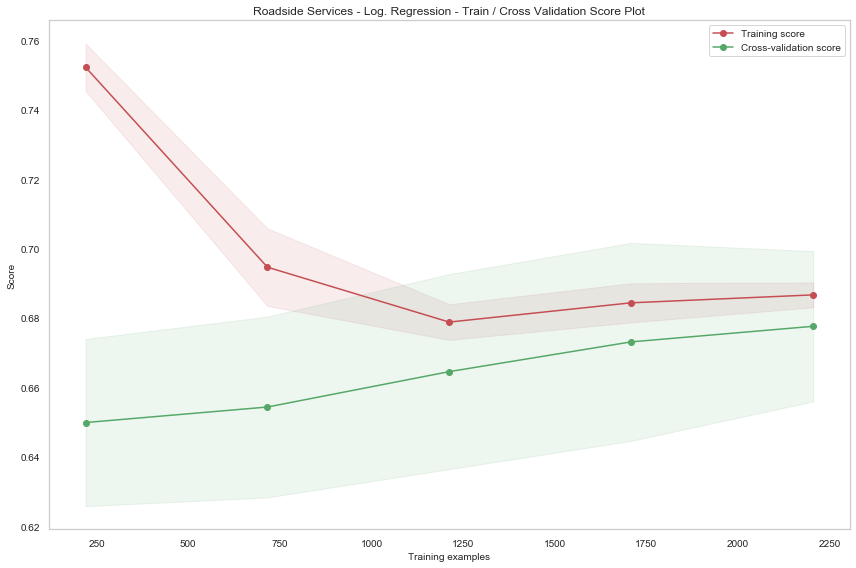

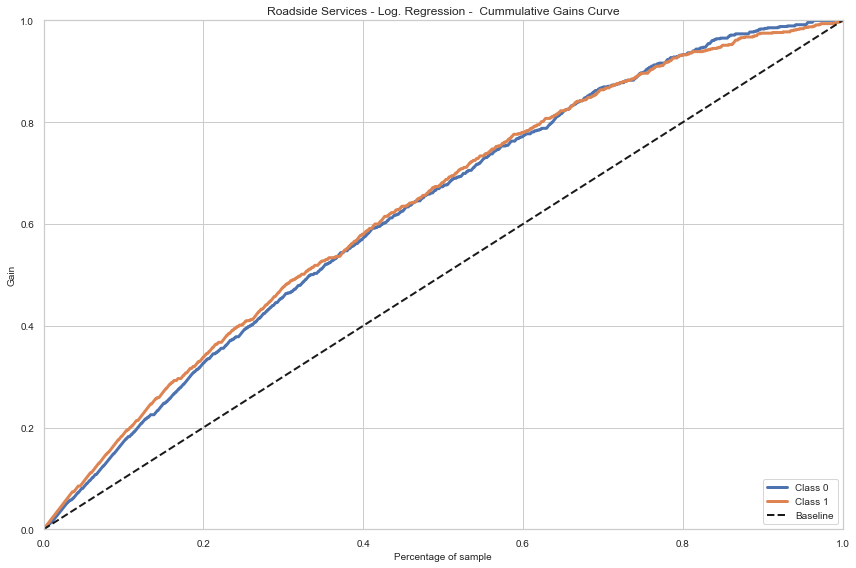

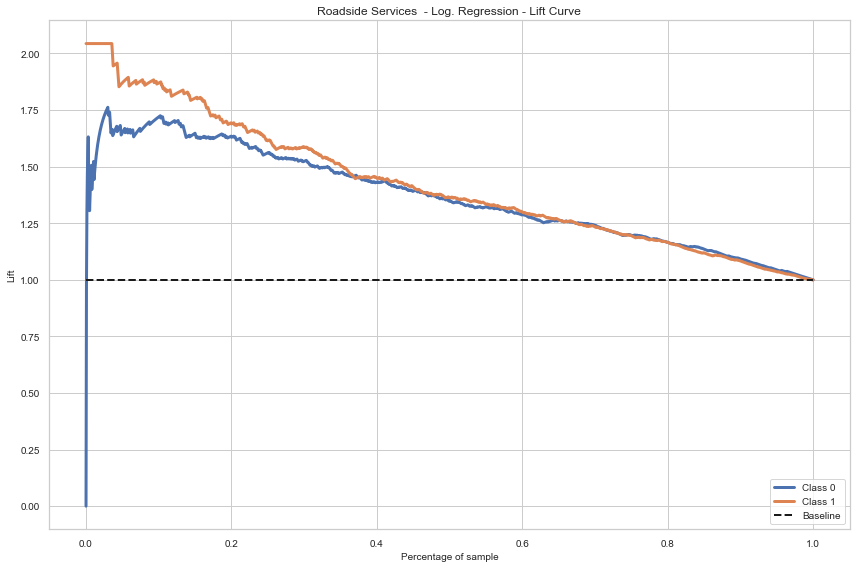

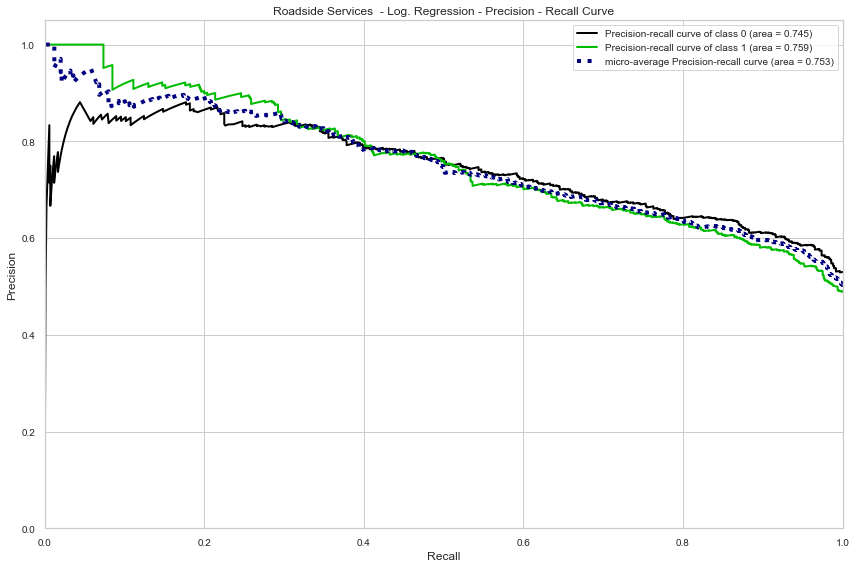

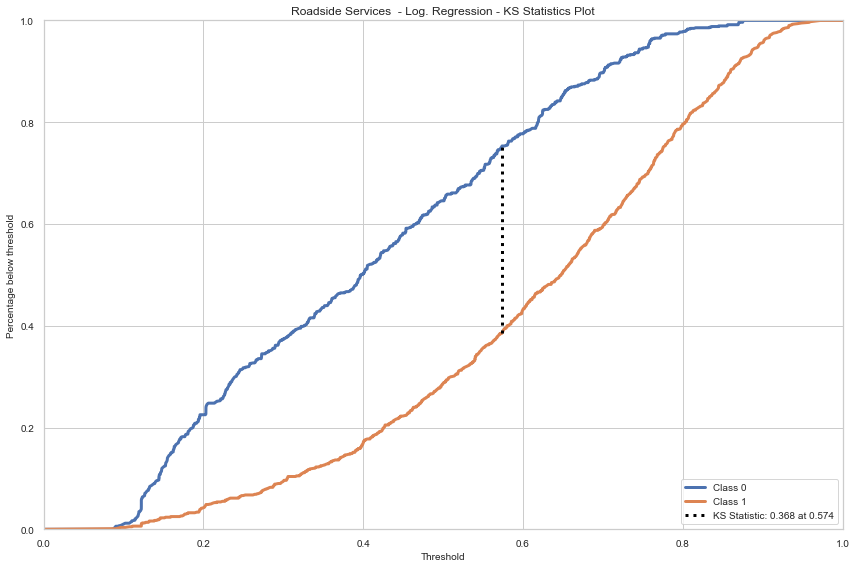

In [352]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(lr, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - Log. Regression - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_lr_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,lr.predict_proba(testX), title=var_to_predict_title + ' - Log. Regression -  Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_lr_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,lr.predict_proba(testX), title=var_to_predict_title + '  - Log. Regression - Lift Curve')
plt.savefig(var_to_predict_save+'_lr_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,lr.predict_proba(testX), title=var_to_predict_title + '  - Log. Regression - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_lr_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, lr.predict_proba(testX), title=var_to_predict_title+'  - Log. Regression - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_lr_ksst')
plt.show()

Confusion matrix - Roadside Services, without normalization - Logistic Regression
[[539 296]
 [229 571]]


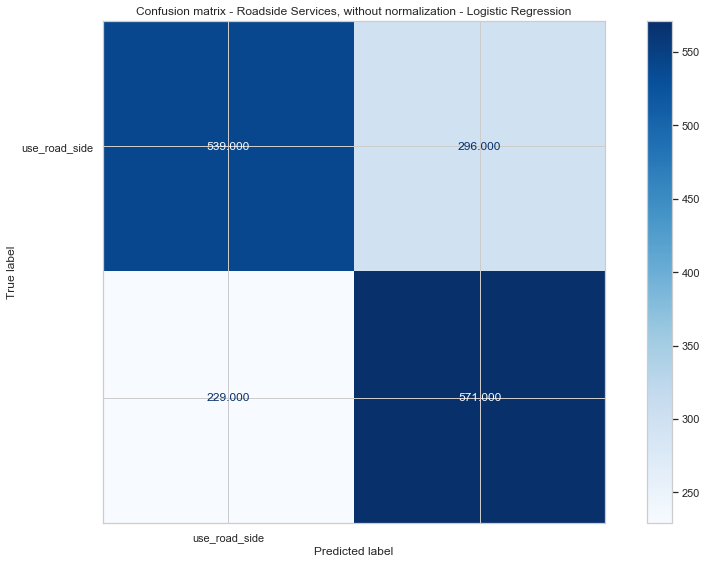

Normalized confusion matrix - Roadside Services - Logistic Regression
[[0.65 0.35]
 [0.29 0.71]]


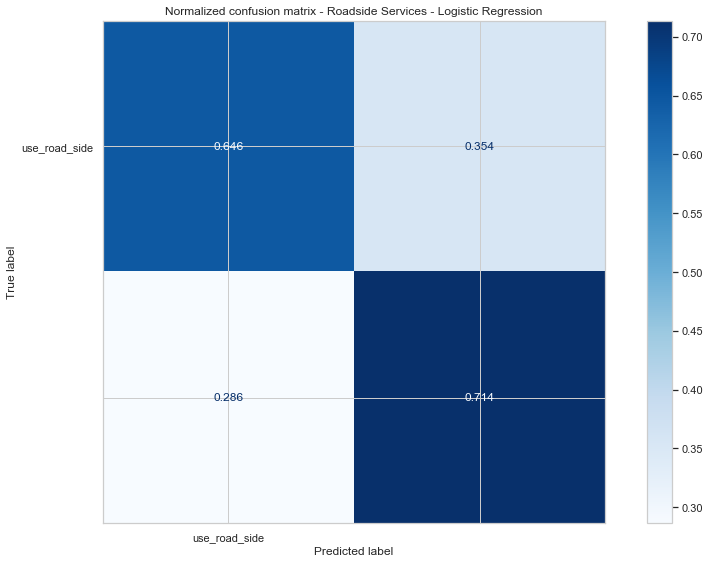

In [297]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Logistic Regression", None),
                  ("Normalized confusion matrix - "+var_to_predict_title + " - Logistic Regression", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_lr_cm')
    else: plt.savefig(var_to_predict_save+'_lr_cm_1')
    i +=1
    plt.show()

In [298]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': lr.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts_df_lgr = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts_df_lgr.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_df_lgr, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_lr_coef.png')
py.iplot(fig)

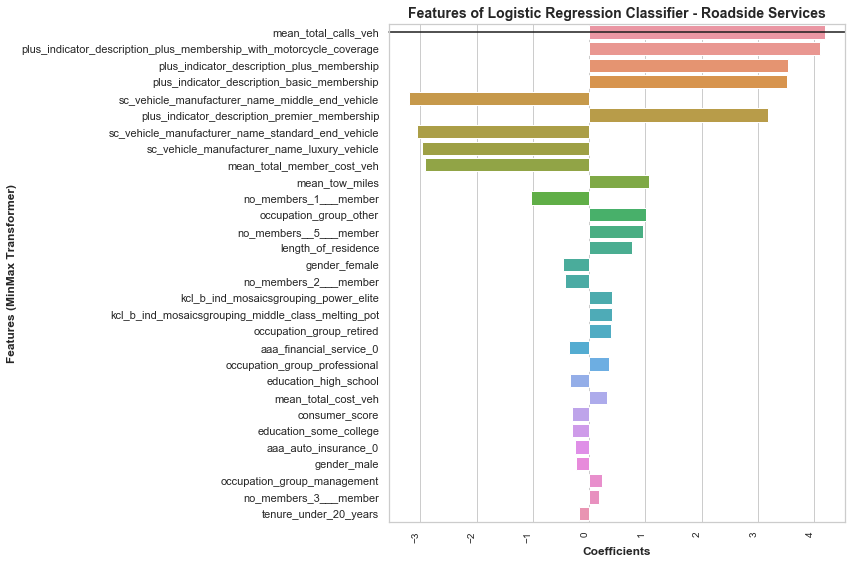

In [299]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Logistic Regression Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_df_lgr['Features (MinMax Transformer)'], x=counts_df_lgr['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_lr_coef_1')
plt.show()

# k-Nearest Neighbors

In [300]:
# KNN Model - Grid search with RandomizedSearch
np.random.seed(42)
num_folds = 10
scoring='accuracy'
weight_options = ['uniform', 'distance']
algorithm_options = ['ball_tree', 'kd_tree', 'brute']
neighbors_settings = list(range(1, 10))
leaf_options = list(range(1, 50))
param_grid = dict(n_neighbors=neighbors_settings, weights=weight_options, algorithm=algorithm_options, leaf_size=leaf_options)

knn = KNeighborsClassifier()
best_scores = []
for _ in range(10):
    rand = RandomizedSearchCV(knn, param_grid, cv=num_folds, scoring=scoring, n_iter=10)
    rand.fit(trainX,trainy)
    best_scores.append([rand.best_params_,rand.best_score_])

for i in range(len(best_scores)):
    print('The best parameters : ',best_scores[i])

The best parameters :  [{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 43, 'algorithm': 'kd_tree'}, 0.7764260826281733]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 36, 'algorithm': 'kd_tree'}, 0.7809109009457441]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 2, 'algorithm': 'ball_tree'}, 0.7809109009457441]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 1, 'leaf_size': 24, 'algorithm': 'kd_tree'}, 0.7764260826281733]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 4, 'leaf_size': 14, 'algorithm': 'ball_tree'}, 0.7723361539737846]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 28, 'algorithm': 'brute'}, 0.780502737680438]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 12, 'algorithm': 'ball_tree'}, 0.7809109009457441]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 33, 'algorithm': 'brute'

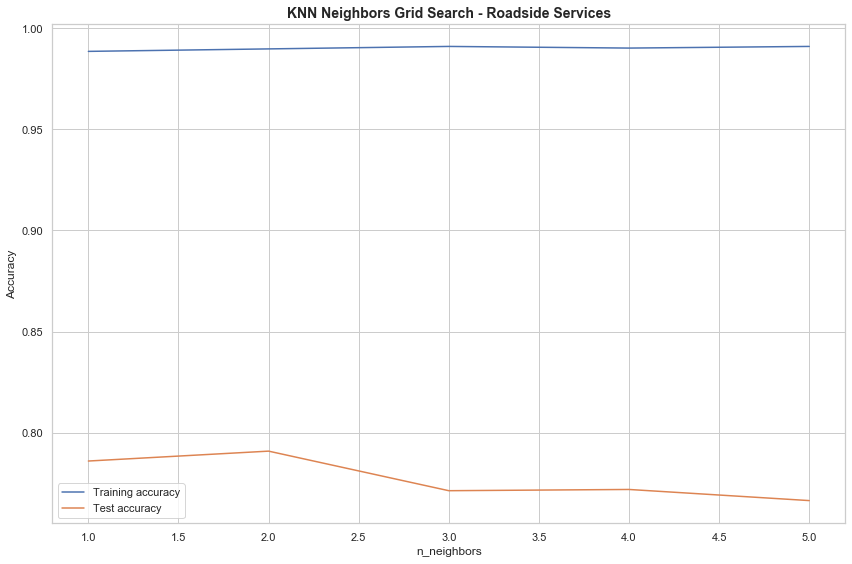

In [301]:
# KNN Model - Grid search
# The best parameters :
    # The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 36, 'algorithm': 'kd_tree'}, 0.7809109009457441]
np.random.seed(42)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 20
neighbors_settings = range(1, 6)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,  weights='distance', leaf_size=36, algorithm='kd_tree')
    knn.fit(trainX, trainy)
    # record training set accuracy
    training_accuracy.append(knn.score(trainX, trainy))
    # record test set accuracy
    test_accuracy.append(knn.score(testX, testy))

plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
# Show title
plt.title('KNN Neighbors Grid Search - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_knn_compare_model')

# Observations
The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using more than 2 neighbor leads to a model that is too complex.

The best performance is somewhere around 2 neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is more than 82% accuracy, which might still be pretty good.

The above plot suggests that we should choose n_neighbors= where the model gets its stability. 
Outcome of the Grid Search above 
* The best parameters : The best parameters :  The best parameters :  [{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 22, 'algorithm': 'ball_tree'}, 0.7895104895104895]
    

Accuracy of K-NN classifier on training set: 0.989
Accuracy of K-NN classifier on test set: 0.786
K-NN classifier - Precision                  : 0.830
K-NN classifier - Recall                     : 0.708
K-NN classifier - F-measure                  : 0.764
K-NN classifier - Log-Loss                   : 7.394
K-NN Classifier - Cross Entropy Loss         : 1.648
K-NN classifier - No Skill - ROC AUC         : 0.500
K-NN classifier - ROC AUC                    : 0.784
K-NN classifier - Cross Validation Accuracy  : 0.724 (+/- 0.056)


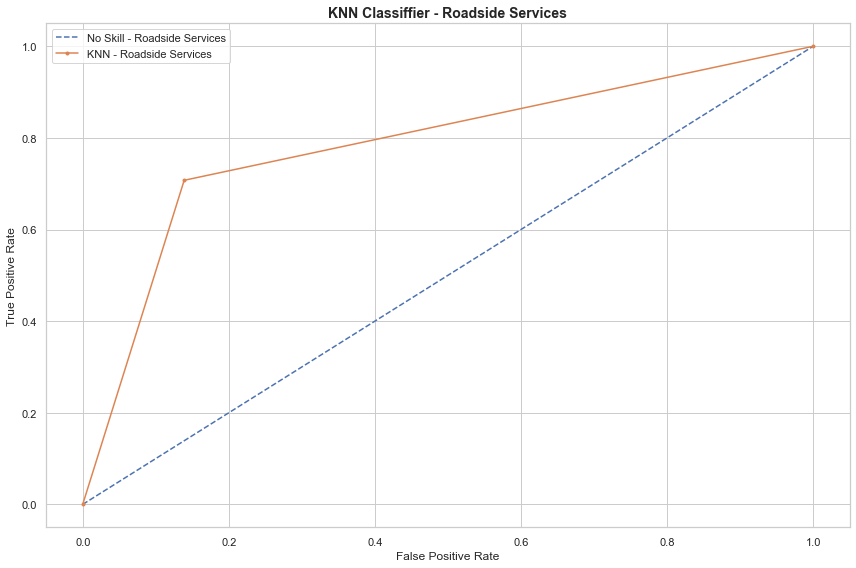

In [354]:
# Best model
# The best parameters :  [{'weights': 'distance', 'n_neighbors': 1, 'leaf_size': 36, 'algorithm': 'kd_tree'}, 0.7809109009457441]
knn = KNeighborsClassifier(n_neighbors=1) #, leaf_size=36,algorithm='kd_tree')
knn.fit(trainX, trainy)


print('Accuracy of K-NN classifier on training set: {:.3f}'.format(knn.score(trainX, trainy)))
print('Accuracy of K-NN classifier on test set: {:.3f}'.format(knn.score(testX, testy)))

# Predict on test set
yhat = knn.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
knn_probs = knn.predict_proba(testX)

# Keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
knn_auc = roc_auc_score(testy, knn_probs)

# Calculate Cross valdation scores
knn_scores = cross_val_score(knn, testX, testy, cv=num_folds)

# Evaluate predictions
print('K-NN classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('K-NN classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('K-NN classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('K-NN classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('K-NN Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('K-NN classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('K-NN classifier - ROC AUC                    : %.3f' % (knn_auc))
print("K-NN classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(testy, knn_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('KNN Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_knn_roc')
plt.show()

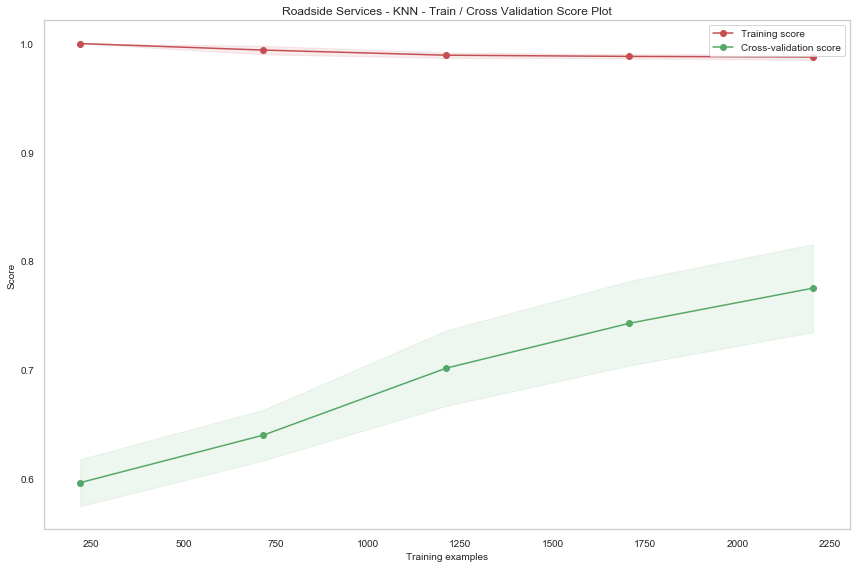

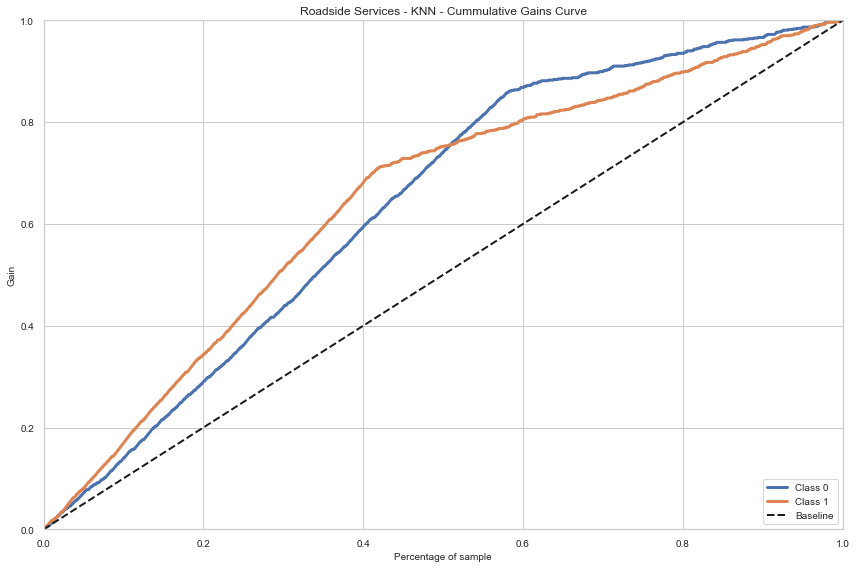

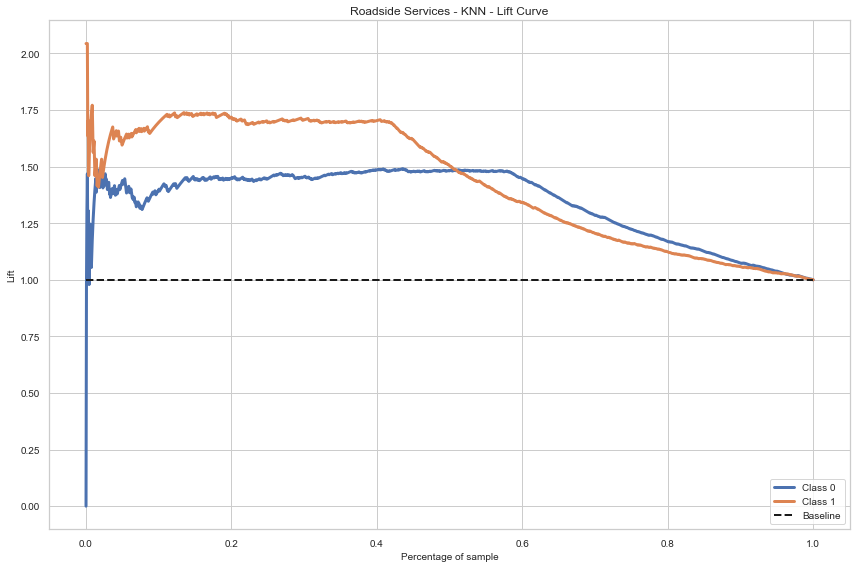

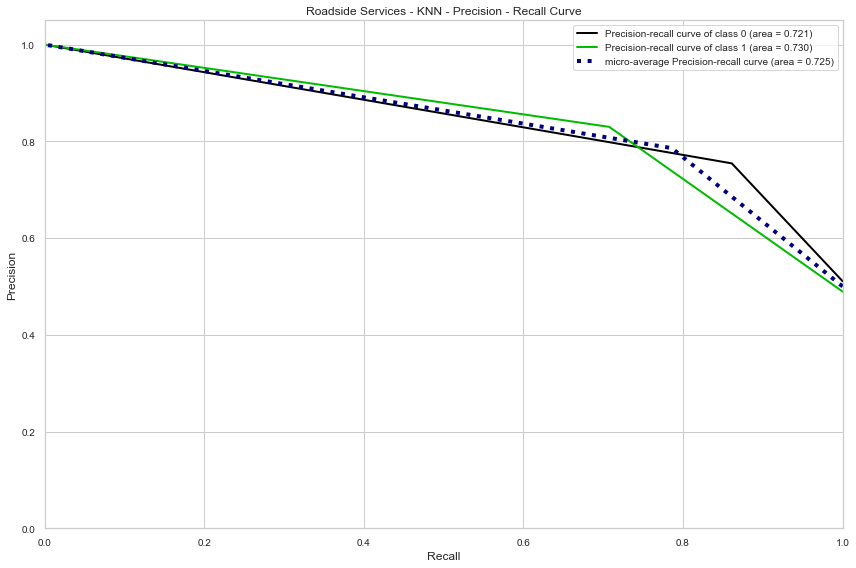

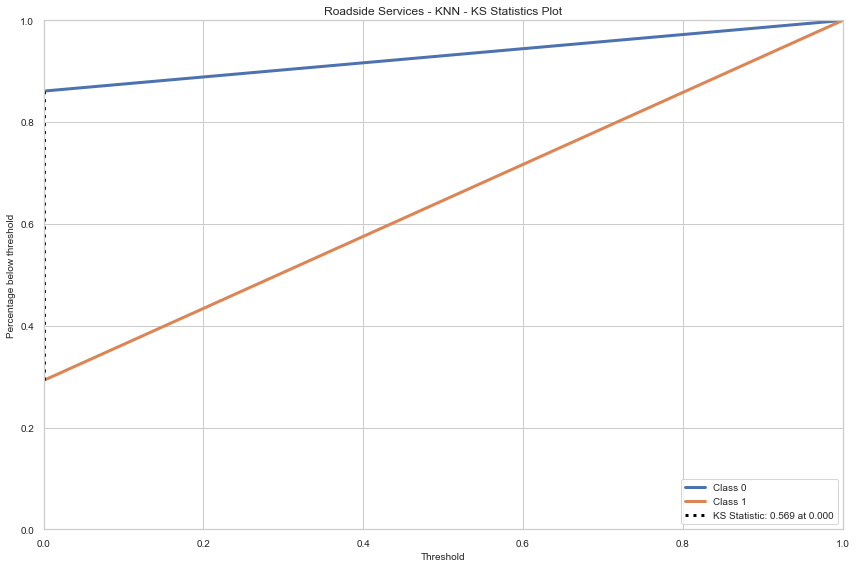

In [355]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(knn, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - KNN - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_knn_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,knn.predict_proba(testX), title=var_to_predict_title + ' - KNN - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_knn_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,knn.predict_proba(testX), title=var_to_predict_title + ' - KNN - Lift Curve')
plt.savefig(var_to_predict_save+'_knn_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,knn.predict_proba(testX), title=var_to_predict_title + ' - KNN - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_knn_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, knn.predict_proba(testX), title=var_to_predict_title+' - KNN - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_knn_ksst')
plt.show()

Confusion matrix - Roadside Services, without normalization - KNN Classiffier
[[719 116]
 [234 566]]


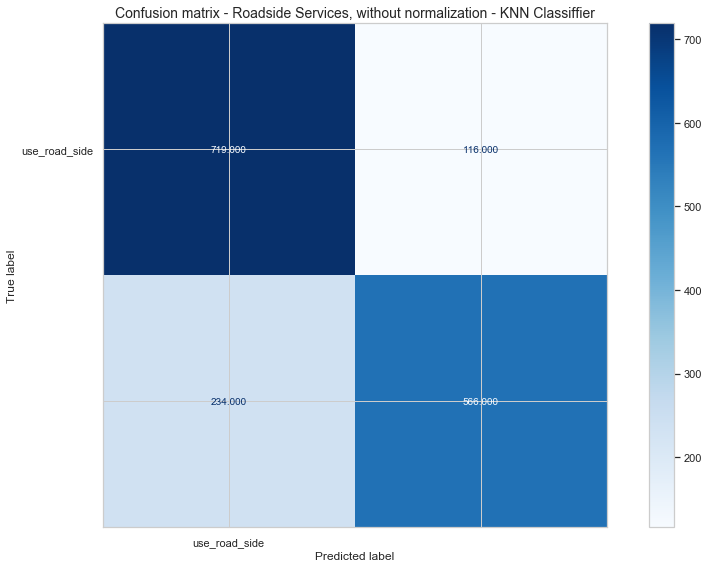

Normalized confusion matrix - Roadside Services - KNN Classiffier
[[0.86 0.14]
 [0.29 0.71]]


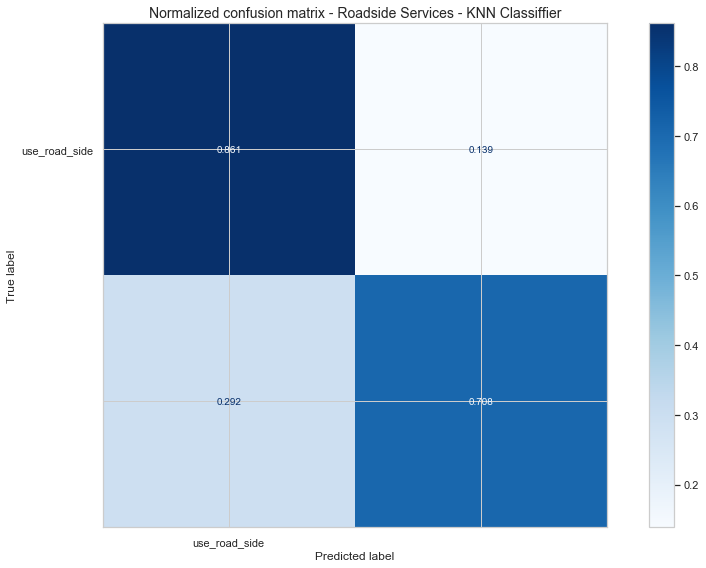

In [356]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - KNN Classiffier", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - KNN Classiffier", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_knn_cm')
    else: plt.savefig(var_to_predict_save+'_knn_cm_1')
    i +=1
    plt.show()

# CART  Model - DecisionTreeClassifier

In [310]:
# DecisionTreeClasifier
np.random.seed(42)

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(40, 65,1)
             }

# decision tree model
cart = DecisionTreeClassifier()

#use gridsearch to test all values
cart_gscv = GridSearchCV(cart, param_grid, cv=num_folds)

#fit model to data
cart_gscv.fit(trainX, trainy)
print('Best parameters : ', cart_gscv.best_params_)
print('Best Score      : ', cart_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 61}
Best Score      :  0.785792268126763


# Observation

Based on the grid search above, the best parameter for the Decission Tree Classifier is:
* The 1st run showed 
    * Best parameters :  {'criterion': 'gini', 'max_depth': 52}
    * Best Score      :  0.7829467396714784
    * As I am using an increment of 10, rerun it, using increment of 1 from +-10

* Narrowing the parameters
    * Best parameters :  {'criterion': 'gini', 'max_depth': 61}
    * Best Score      :  0.785792268126763

CART - Accuracy on training set: 0.991
CART - Accuracy on test set: 0.794
CART - Precision                  : 0.831
CART - Recall                     : 0.726
CART - F-measure                  : 0.775
CART - Log-Loss                   : 7.119
CART - Cross Entropy Loss         : 1.542
CART - No Skill - ROC AUC         : 0.500
CART - ROC AUC                    : 0.794
CART - Cross Validation Accuracy  : 0.728 (+/- 0.078)


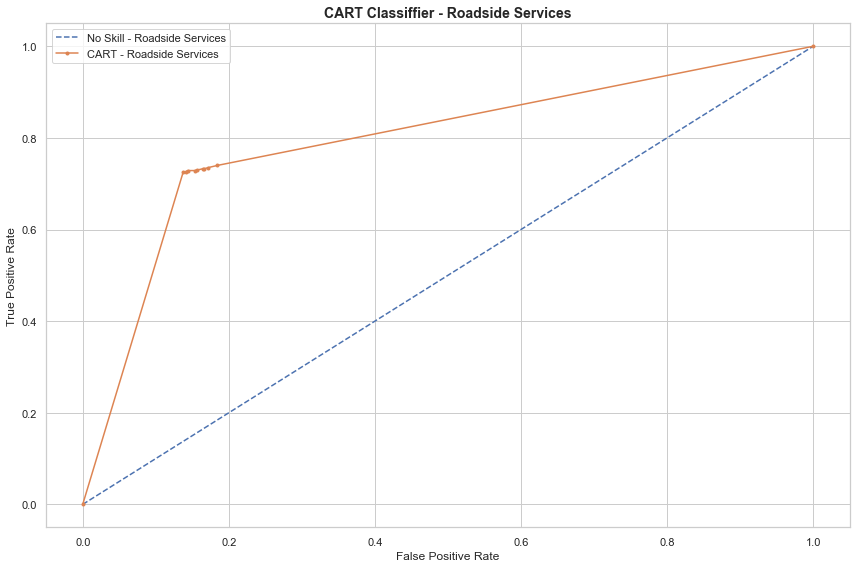

In [357]:
# Modeling based on the outcome of the grid serach
cart = DecisionTreeClassifier(criterion = 'gini', max_depth=61)
cart.fit(trainX, trainy)

# Predict on test set
yhat = cart.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
cart_probs = cart.predict_proba(testX)

# Keep probabilities for the positive outcome only
cart_probs = cart_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
cart_auc = roc_auc_score(testy, cart_probs)

# Calculate Cross valdation scores
cart_scores = cross_val_score(cart, testX, testy, cv=num_folds)

print("CART - Accuracy on training set: {:.3f}".format(cart.score(trainX, trainy)))
print("CART - Accuracy on test set: {:.3f}".format(cart.score(testX, testy)))

# Evaluate predictions
print('CART - Precision                  : %.3f' % precision_score(testy, yhat))
print('CART - Recall                     : %.3f' % recall_score(testy, yhat))
print('CART - F-measure                  : %.3f' % f1_score(testy, yhat))
print('CART - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('CART - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('CART - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('CART - ROC AUC                    : %.3f' % (cart_auc))
print("CART - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (cart_scores.mean(), cart_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
cart_fpr, cart_tpr, _ = roc_curve(testy, cart_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(cart_fpr, cart_tpr, marker='.', label='CART - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('CART Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_cart_roc')
# show the plot
plt.show()

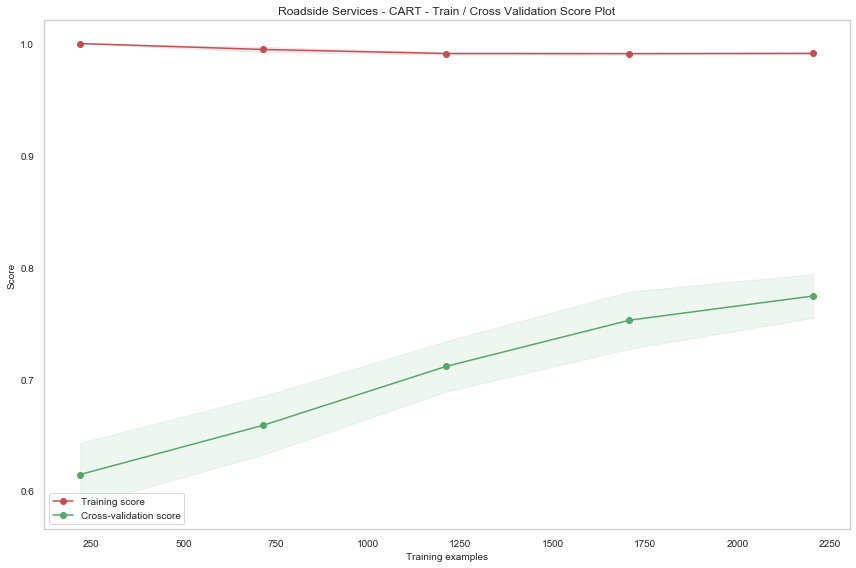

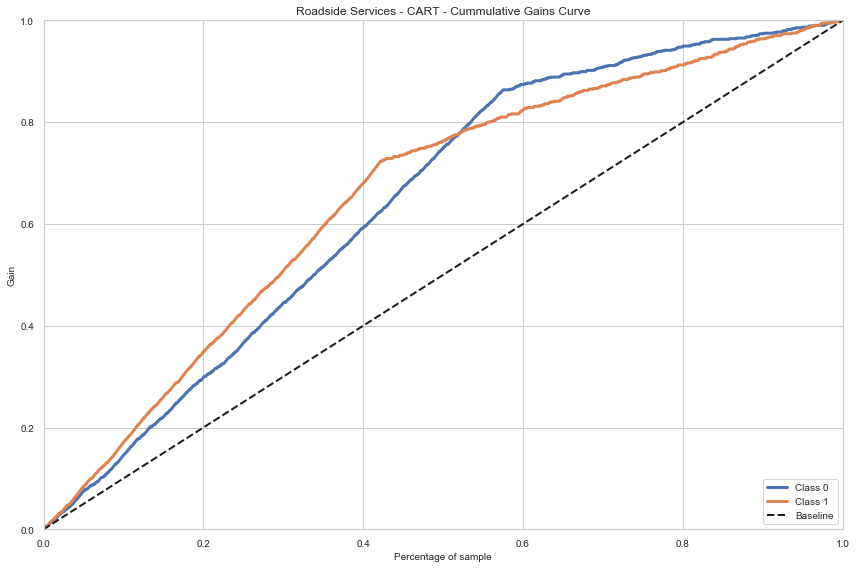

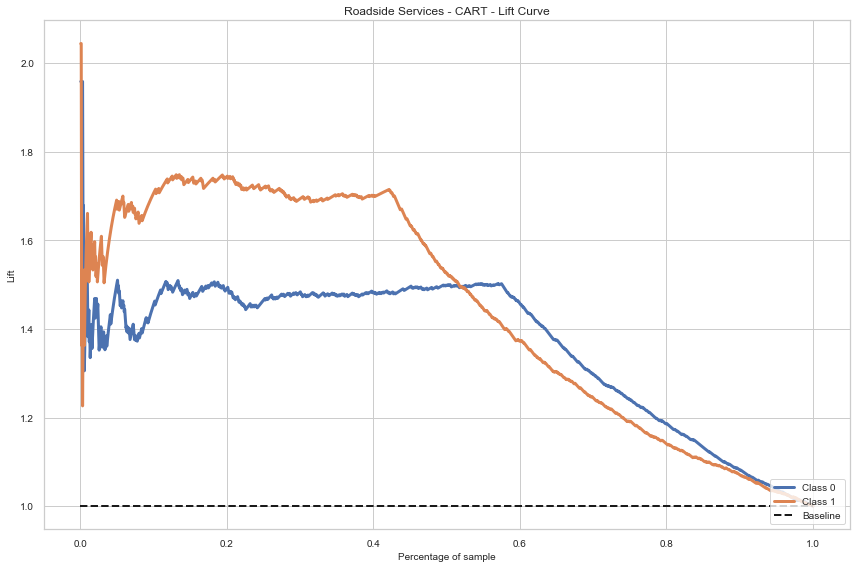

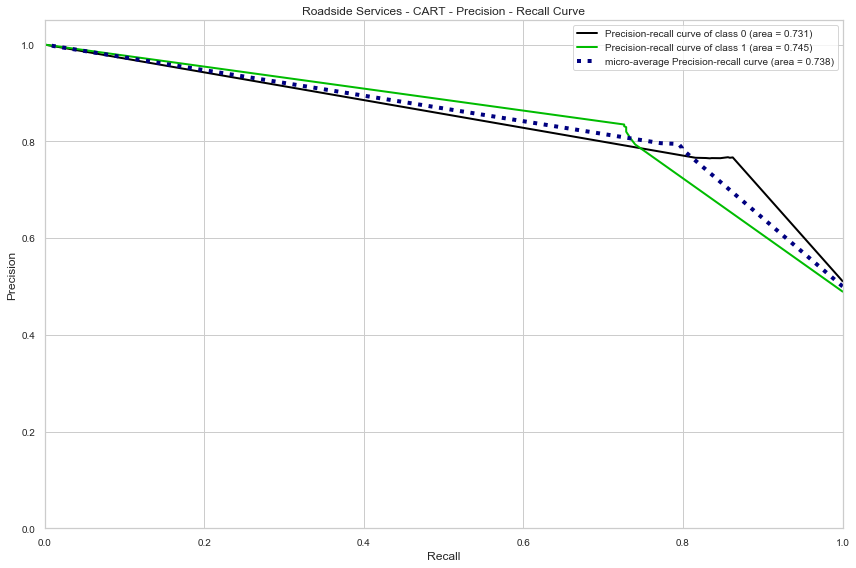

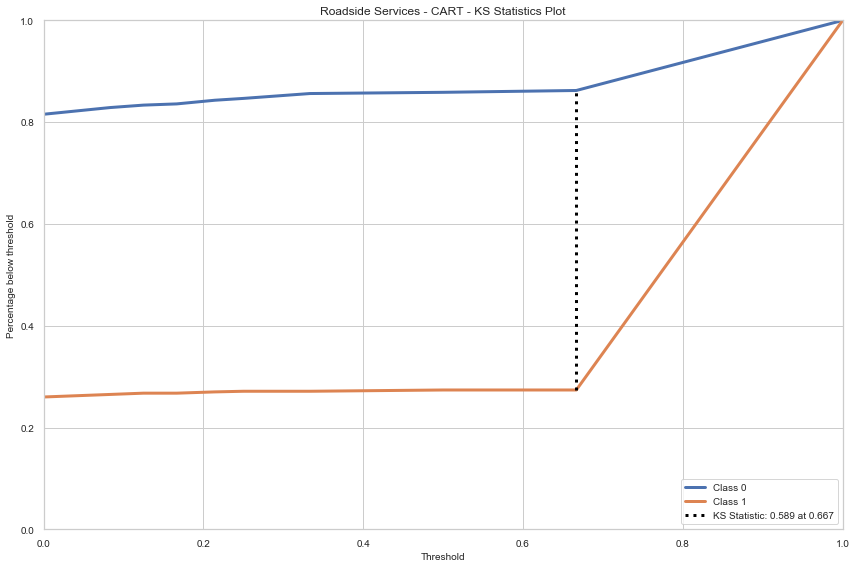

In [359]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(cart, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - CART - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_cart_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,cart.predict_proba(testX), title=var_to_predict_title + ' - CART - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_cart_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,cart.predict_proba(testX), title=var_to_predict_title + ' - CART - Lift Curve')
plt.savefig(var_to_predict_save+'_cart_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,cart.predict_proba(testX), title=var_to_predict_title + ' - CART - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_cart_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, cart.predict_proba(testX), title=var_to_predict_title+' - CART - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_cart_ksst')
plt.show()

Confusion matrix - Roadside Services, without normalization - CART
[[717 118]
 [219 581]]


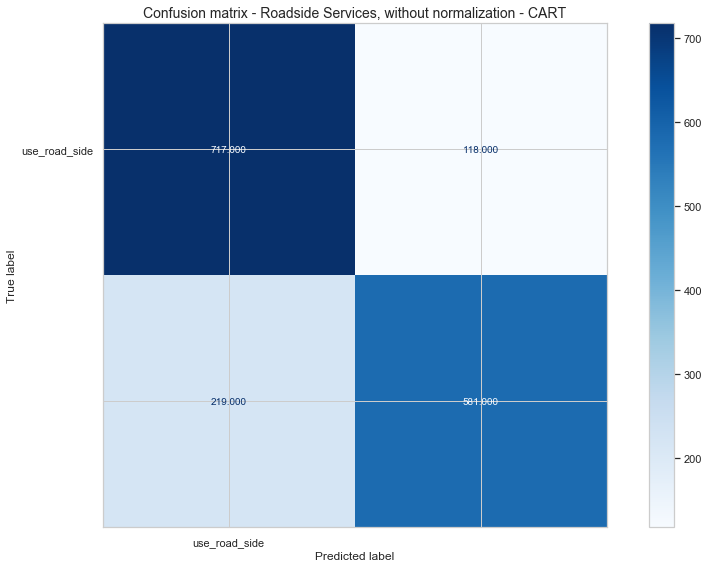

CART - Normalized confusion matrix - Roadside Services
[[0.86 0.14]
 [0.27 0.73]]


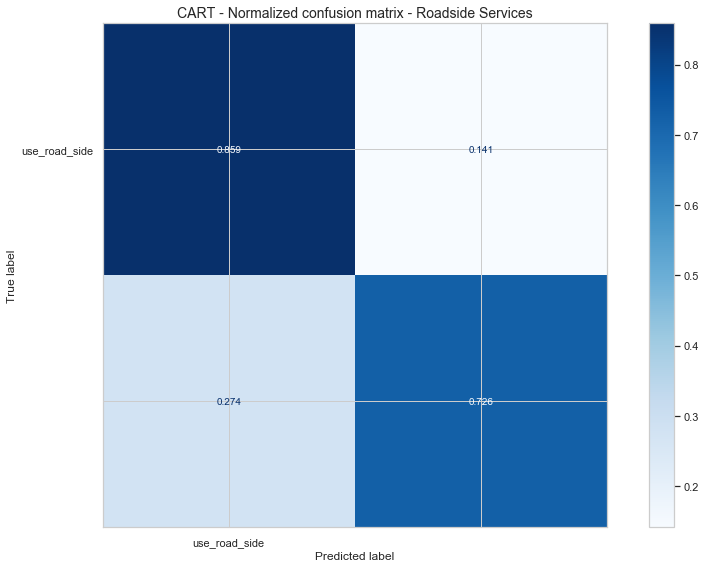

In [360]:
# Confusion Metrics
np.set_printoptions(precision=2)

i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - CART", None),
                  ("CART - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cart, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    if i==1: plt.savefig(var_to_predict_save+'_cart_cm')
    else: plt.savefig(var_to_predict_save+'_cart_cm_1')
    i +=1
    plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [361]:
coef_df_cart = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_cart["abs_coeff"] = coef_df_cart['coefs'].abs()
coef_df_cart.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_cart.nlargest(30,columns=["abs_coeff"])
counts_cart = pd.DataFrame(coef_df_cart.nlargest(30,columns=["abs_coeff"]), index=None)
counts_cart.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_cart, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_cart_coef.png')
py.iplot(fig)

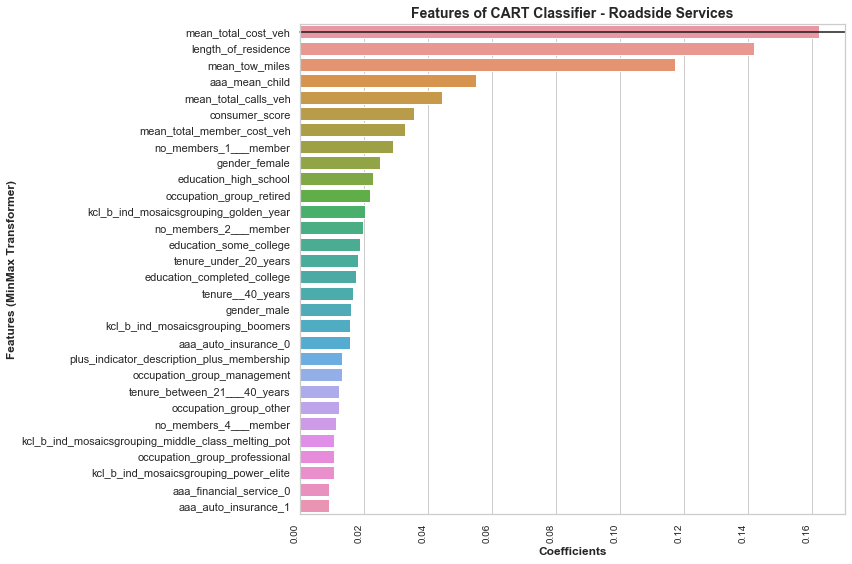

In [362]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of CART Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_cart['Features (MinMax Transformer)'], x=counts_cart['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_cart_coef_1')
plt.show()

# Random Forest Classifier Model

In [159]:
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 200, 8)}

# Random Forest Classifier model
rf = RandomForestClassifier()

#use gridsearch to test all values
rf_gscv = GridSearchCV(rf, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
rf_gscv.fit(trainX, trainy)
print('Best parameters : ', rf_gscv.best_params_)
print('Best score      : ', rf_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 130, 'n_estimators': 190}
Best score      :  0.8531226148996185


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 112, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 42}
    * Best score      :  0.8541958041958042
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 32}
    * Best score      :  0.8545454545454545

Random Forest - Accuracy on training set: 0.991
Random Forest - Accuracy on test set: 0.796
Random Forest - Precision                  : 0.834
Random Forest - Recall                     : 0.728
Random Forest - F-measure                  : 0.777
Random Forest - Log-Loss                   : 7.056
Random Forest - Cross Entropy Loss         : 1.535
Random Forest - No Skill - ROC AUC         : 0.500
Random Forest - ROC AUC                    : 0.796
Random Forest - Cross Validation Accuracy  : 0.730 (+/- 0.070)


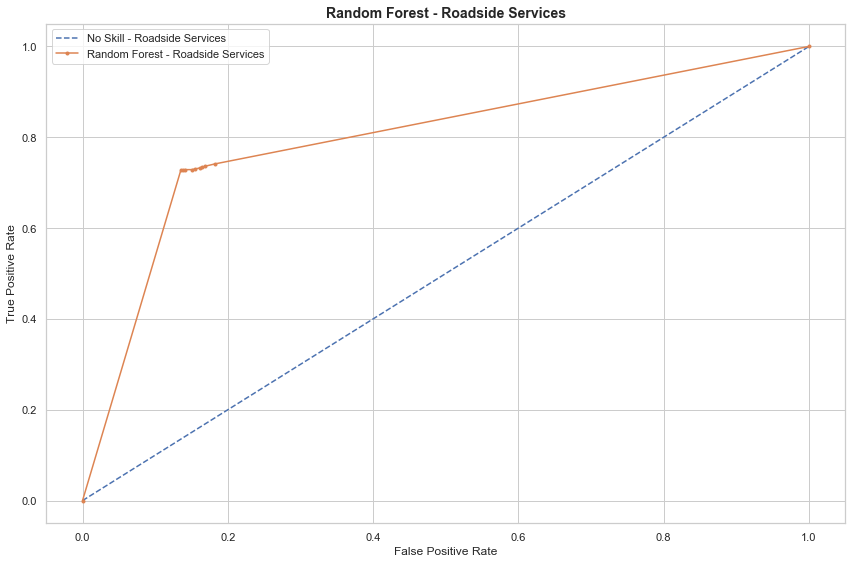

In [363]:
# Modeling based on the outcome of the grid serach of the random forest
rf = DecisionTreeClassifier(criterion = 'gini', max_depth=130)
rf.fit(trainX, trainy)

# Predict on test set
yhat = rf.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
rf_probs = rf.predict_proba(testX)

# Keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
rf_auc = roc_auc_score(testy, rf_probs)

# Calculate Cross valdation scores
rf_scores = cross_val_score(rf, testX, testy, cv=num_folds)

print("Random Forest - Accuracy on training set: {:.3f}".format(rf.score(trainX, trainy)))
print("Random Forest - Accuracy on test set: {:.3f}".format(rf.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Random Forest - Precision                  : %.3f' % precision_score(testy, yhat))
print('Random Forest - Recall                     : %.3f' % recall_score(testy, yhat))
print('Random Forest - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Random Forest - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Random Forest - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Random Forest - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Random Forest - ROC AUC                    : %.3f' % (rf_auc))
print("Random Forest - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_rf_roc')
plt.show()

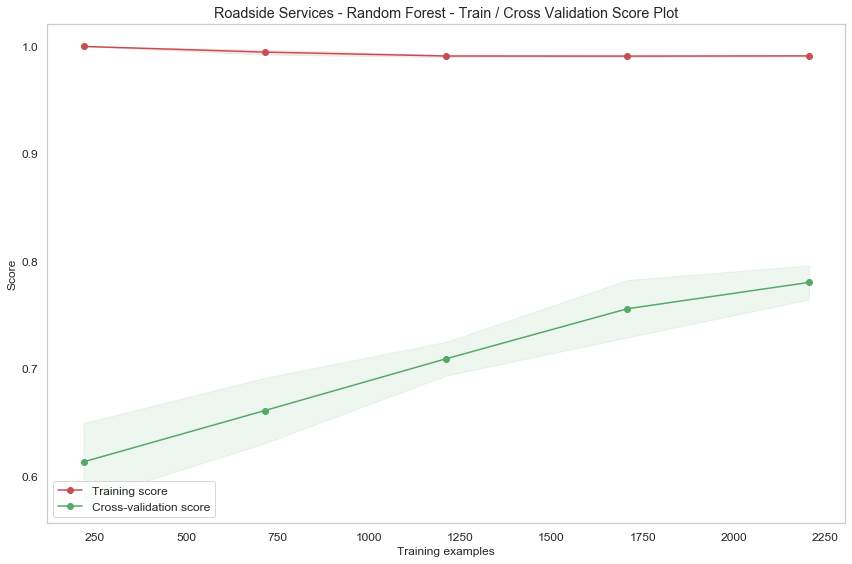

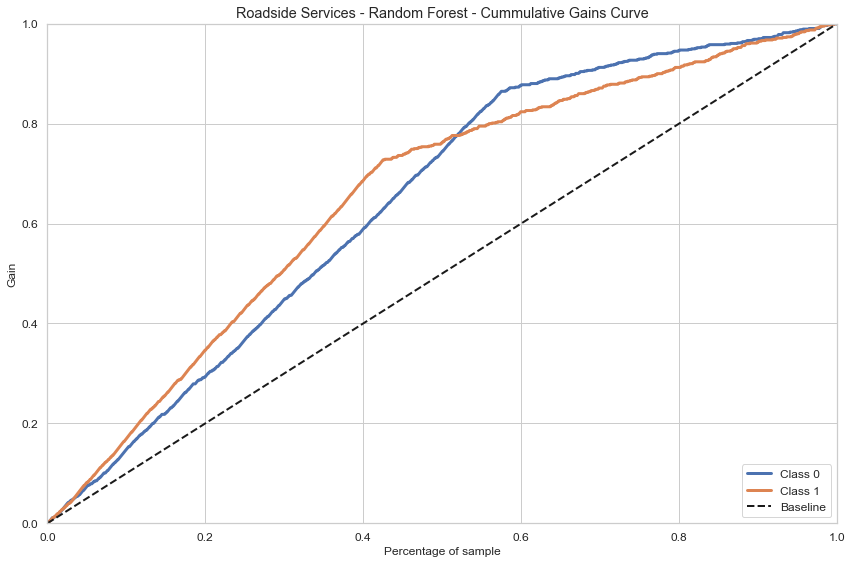

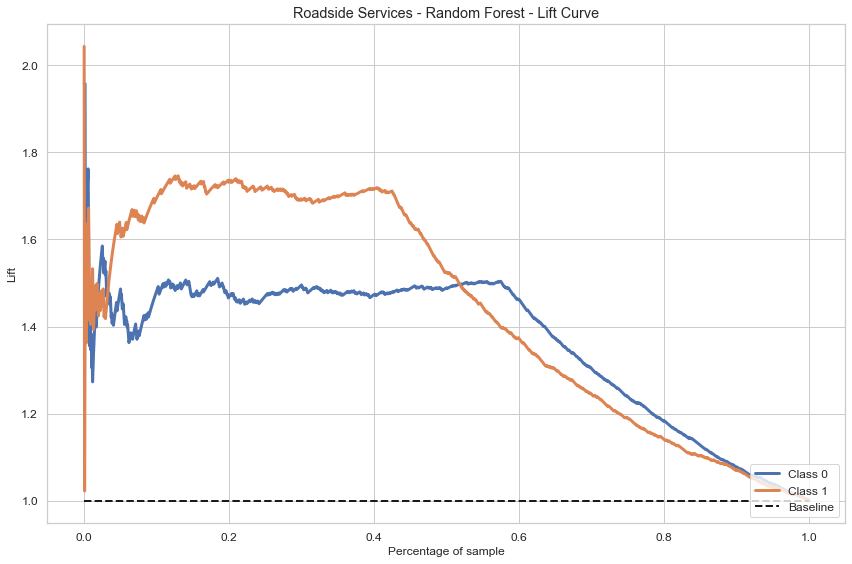

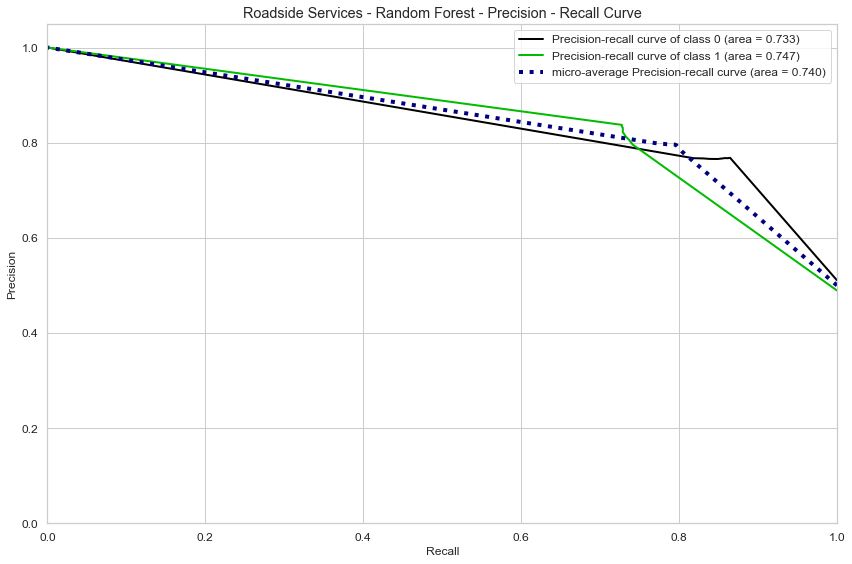

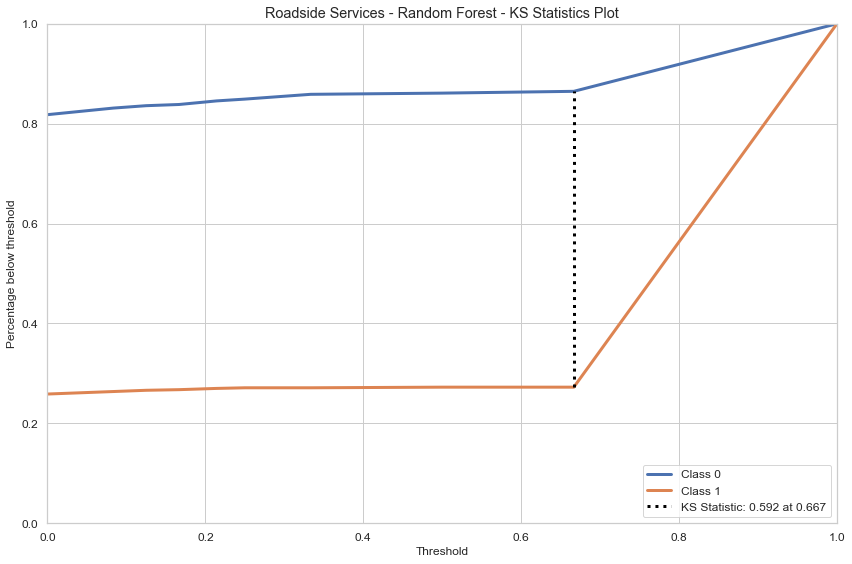

In [364]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(rf, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - Random Forest - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_rf_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_rf_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Lift Curve')
plt.savefig(var_to_predict_save+'_rf_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,rf.predict_proba(testX), title=var_to_predict_title + ' - Random Forest - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_rf_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, rf.predict_proba(testX), title=var_to_predict_title+' - Random Forest - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_rf_ksst')
plt.show()

Confusion matrix - Roadside Services, without normalization - Random Forest
[[719 116]
 [218 582]]


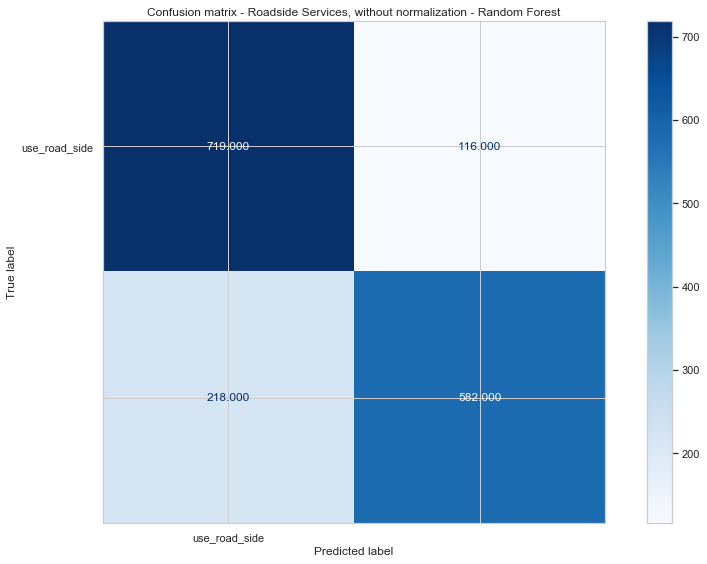

Normalized confusion matrix - Roadside Services - Random Forest
[[0.86 0.14]
 [0.27 0.73]]


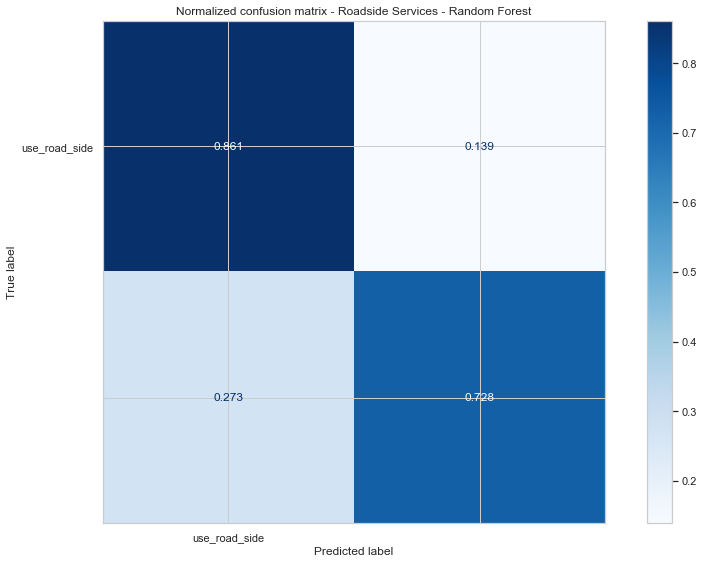

In [365]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1 
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+ ", without normalization - Random Forest", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_rf_cm')
    else: plt.savefig(var_to_predict_save+'_rf_cm_1')
    i +=1
    plt.show()

# Feature importance
feature importance rates how important each feature is for the random forest tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [366]:
coef_df_rf = pd.DataFrame({'feature':testX.columns, 'coefs': rf.feature_importances_})
coef_df_rf["abs_coeff"] = coef_df_rf['coefs'].abs()
coef_df_rf.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_rf.nlargest(30,columns=["abs_coeff"])
counts_rf = pd.DataFrame(coef_df_rf.nlargest(30,columns=["abs_coeff"]), index=None)
counts_rf.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_rf, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_rf_coef.png')
py.iplot(fig)

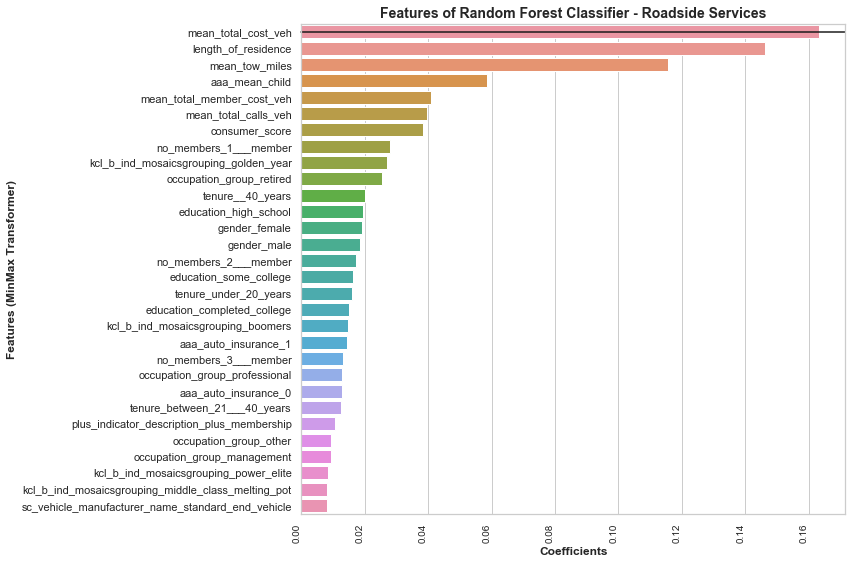

In [368]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Random Forest Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_rf['Features (MinMax Transformer)'], x=counts_rf['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_rf_coef_1')
plt.show()

# ExtraTreesClassifier Classifier

In [315]:
np.random.seed(42)
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 200,10), 'n_estimators': np.arange(10, 200, 10)}

# Random Forest Classifier model
et = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv = GridSearchCV(et, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv.fit(trainX, trainy)
print('Best parameters : ', et_gscv.best_params_)
print('Best score      : ', et_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 92, 'n_estimators': 120}
Best score      :  0.8388485150157624


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 32, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 92, 'n_estimators': 120}
    * Best score      :  0.8388485150157624
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 42}
    * Best score      :  0.855944055944056

Extra Tree Classifier - Accuracy on training set: 0.991
Extra Tree Classifier - Accuracy on test set: 0.856
Extra Tree Classifier - Precision                  : 0.852
Extra Tree Classifier - Recall                     : 0.855
Extra Tree Classifier - F-measure                  : 0.853
Extra Tree Classifier - Log-Loss                   : 4.964
Extra Tree Classifier - Cross Entropy Loss         : 0.817
Extra Tree Classifier - No Skill - ROC AUC         : 0.500
Extra Tree Classifier - ROC AUC                    : 0.914
Extra Tree Classifier - Cross Validation Accuracy  : 0.775 (+/- 0.059)


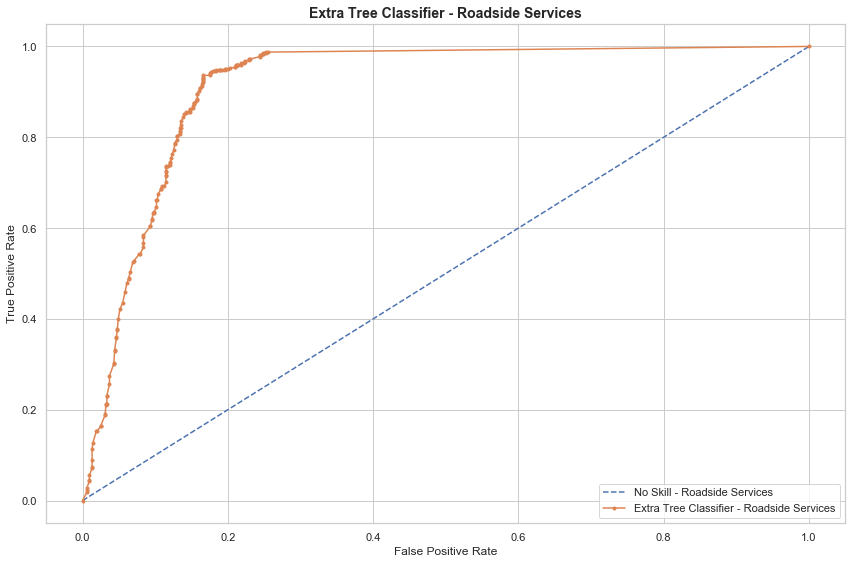

In [369]:
# Modeling based on the outcome of the grid serach of the random forest
et = ExtraTreesClassifier(criterion = 'gini', max_depth=92, n_estimators=120)
et.fit(trainX, trainy)

# Predict on test set
yhat = et.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs = et.predict_proba(testX)

# Keep probabilities for the positive outcome only
et_probs = et_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
et_auc = roc_auc_score(testy, et_probs)

# Calculate Cross valdation scores
scores_et = cross_val_score(et, testX, testy, cv=num_folds)

print("Extra Tree Classifier - Accuracy on training set: {:.3f}".format(et.score(trainX, trainy)))
print("Extra Tree Classifier - Accuracy on test set: {:.3f}".format(et.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et.mean(), scores_et.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
et_fpr, et_tpr, _ = roc_curve(testy, et_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr, et_tpr, marker='.', label='Extra Tree Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_et_roc')
plt.show()

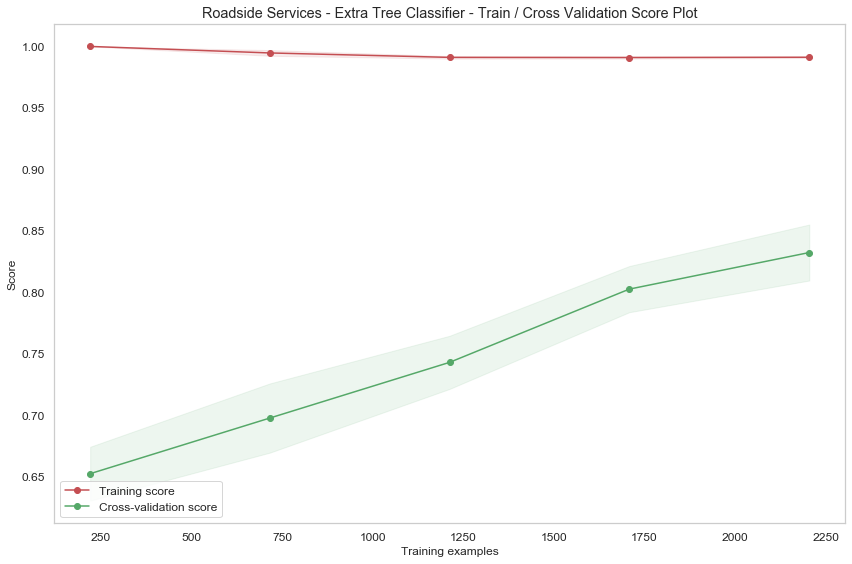

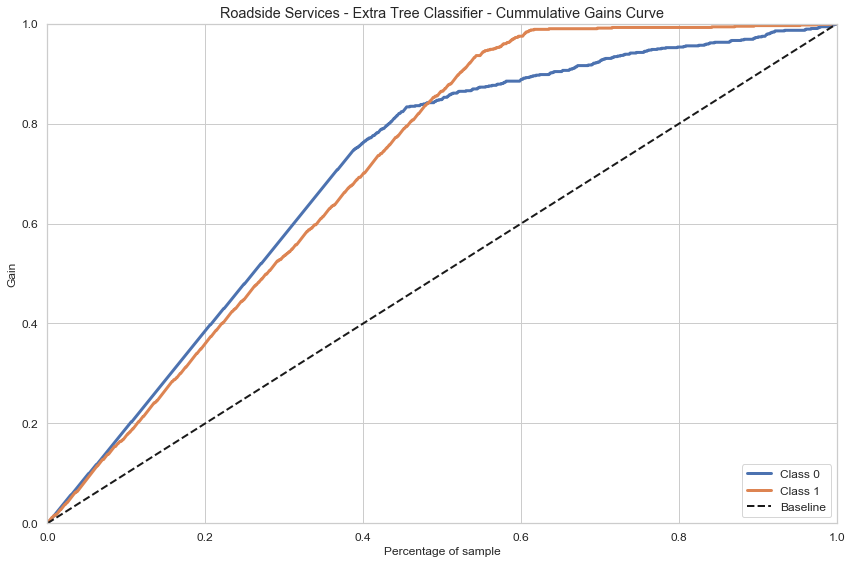

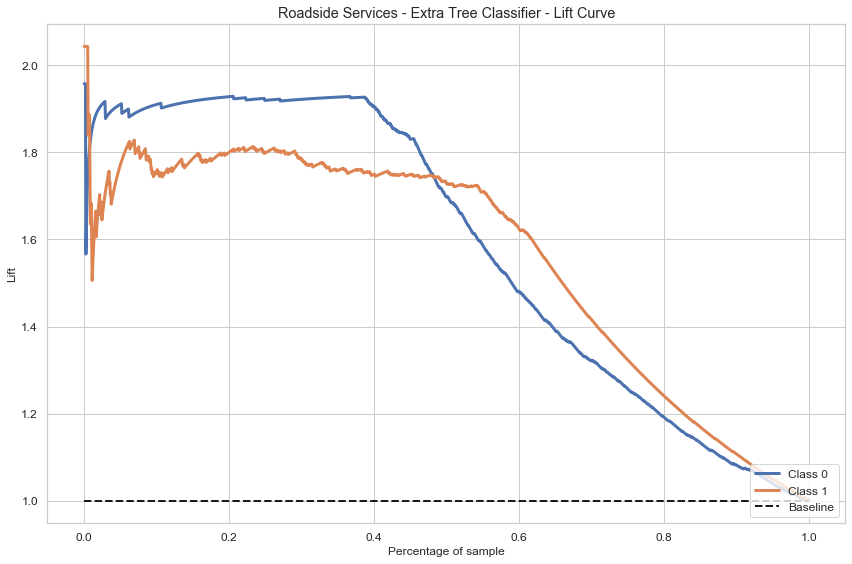

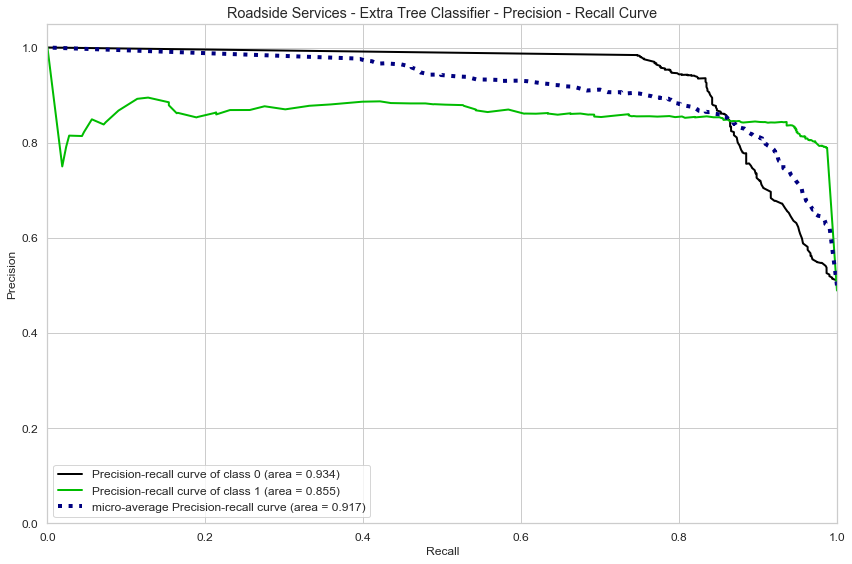

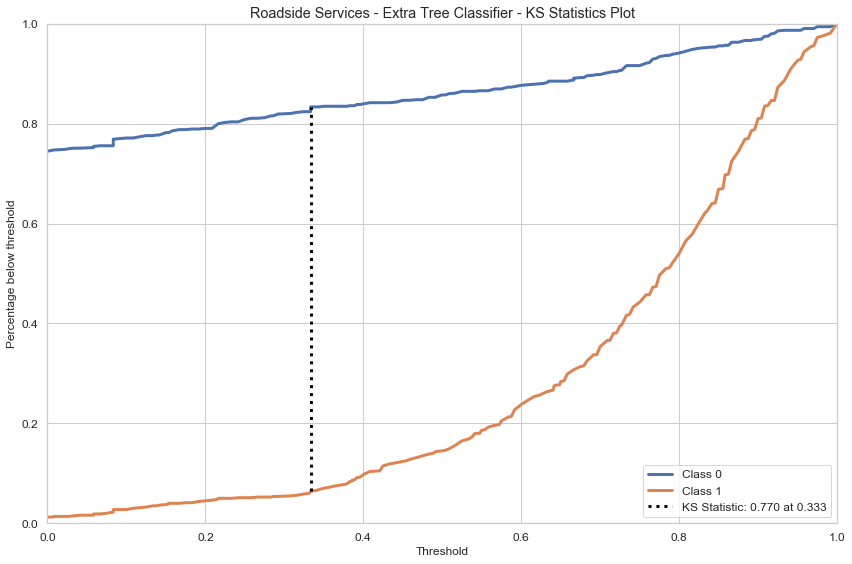

In [370]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(et, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - Extra Tree Classifier - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_et_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_et_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Lift Curve')
plt.savefig(var_to_predict_save+'_et_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,et.predict_proba(testX), title=var_to_predict_title + ' - Extra Tree Classifier - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_et_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, et.predict_proba(testX), title=var_to_predict_title+' - Extra Tree Classifier - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_et_ksst')
plt.show()

Confusion matrix - Roadside Services, without normalization - Extra Tree Classifier
[[716 119]
 [116 684]]


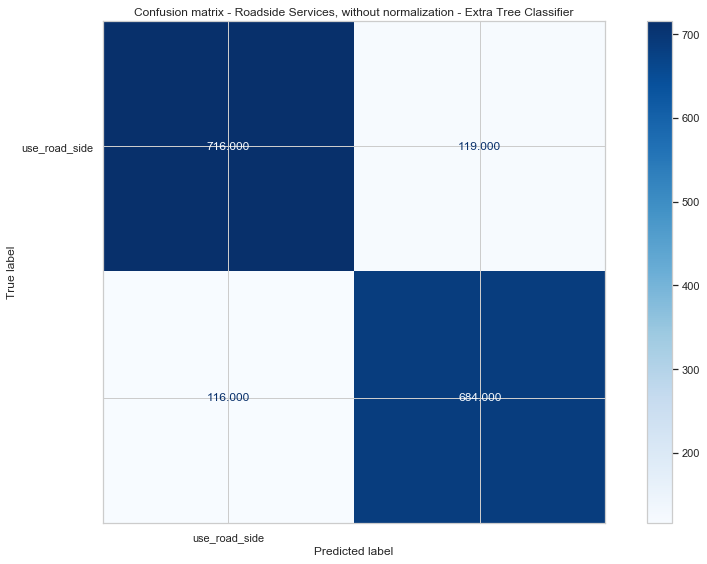

Extra Tree Classifier - Normalized confusion matrix - Roadside Services
[[0.86 0.14]
 [0.14 0.85]]


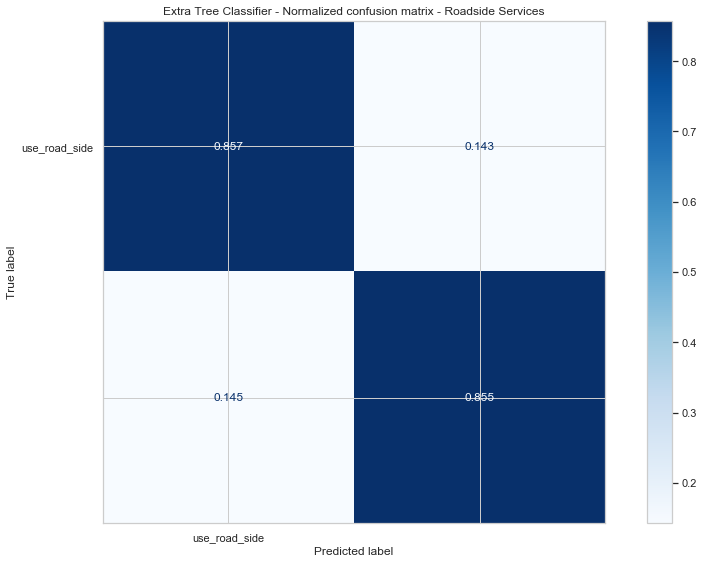

In [371]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier", None),
                  ("Extra Tree Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_et_cm')
    else: plt.savefig(var_to_predict_save+'_et_cm_1')
    i +=1
    plt.show()

In [372]:
coef_df_et = pd.DataFrame({'feature':testX.columns, 'coefs': et.feature_importances_})
coef_df_et["abs_coeff"] = coef_df_et['coefs'].abs()
coef_df_et.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_et.nlargest(30,columns=["abs_coeff"])
counts_et = pd.DataFrame(coef_df_et.nlargest(30,columns=["abs_coeff"]), index=None)
counts_et.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_et, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_et_coef.png')
py.iplot(fig)

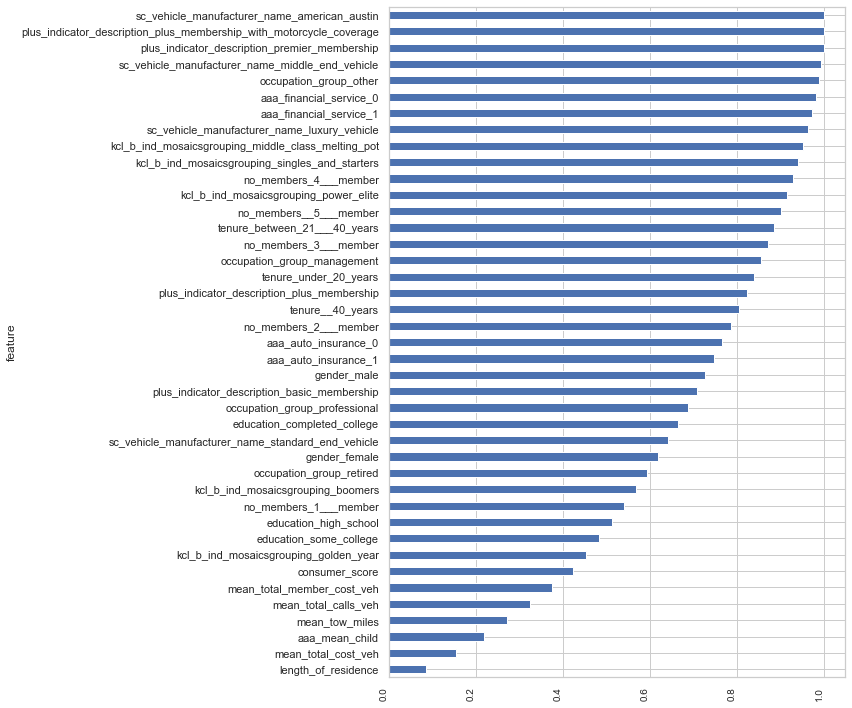

In [373]:
df_cumsum = coef_df_et.copy()
df_cumsum.set_index('feature', inplace=True)
df_cumsum.abs_coeff.cumsum().plot(kind='barh', figsize=(12,10))
plt.xticks(
            rotation=90, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='small')
plt.show()

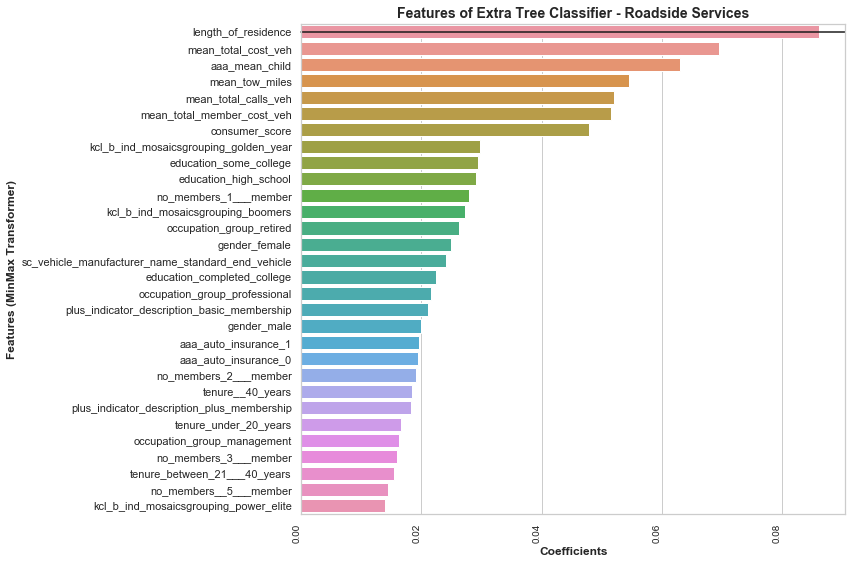

In [374]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_et['Features (MinMax Transformer)'], x=counts_et['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_et_coef_1')
plt.show()

# XGBOOSTING Modeling

In [168]:
np.random.seed(42)
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = {'max_depth': [5,6,7, 8], 'n_estimators': range(50, 250, 50), 
              'learning_rate': [0.1, 0.01, 0.05], 'min_child_weight':[2,4, 6],
              'gamma':[0.1]
             }
# CV model
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4)
kfold = KFold(n_splits=num_folds)
xgb_gscv = GridSearchCV(estimator=xgb,param_grid=param_grid, scoring = scoring, 
                        n_jobs = 10, cv = kfold,verbose=True
                       )
xgb_gscv.fit(trainX, trainy)
print('Best parameters - : ', xgb_gscv.best_params_)
print('Best score      : ', xgb_gscv.best_score_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  6.6min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 1440 out of 1440 | elapsed: 12.7min finished


Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200}
Best score      :  0.8388451966152315


# Observation
Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200}
Best score      :  0.9773189547971137

XGBoost Classifier - Accuracy on training set: 0.965
XGBoost Classifier - Accuracy on test set: 0.820
XGBoost Classifier - Precision                  : 0.857
XGBoost Classifier - Recall                     : 0.757
XGBoost Classifier - F-measure                  : 0.804
XGBoost Classifier - Log-Loss                   : 6.232
XGBoost Classifier - Cross Entropy Loss         : 1.366
XGBoost Classifier - No Skill - ROC AUC         : 0.500
XGBoost Classifier - ROC AUC                    : 0.878
XGBoost Classifier - Cross Validation Accuracy  : 0.762 (+/- 0.053)


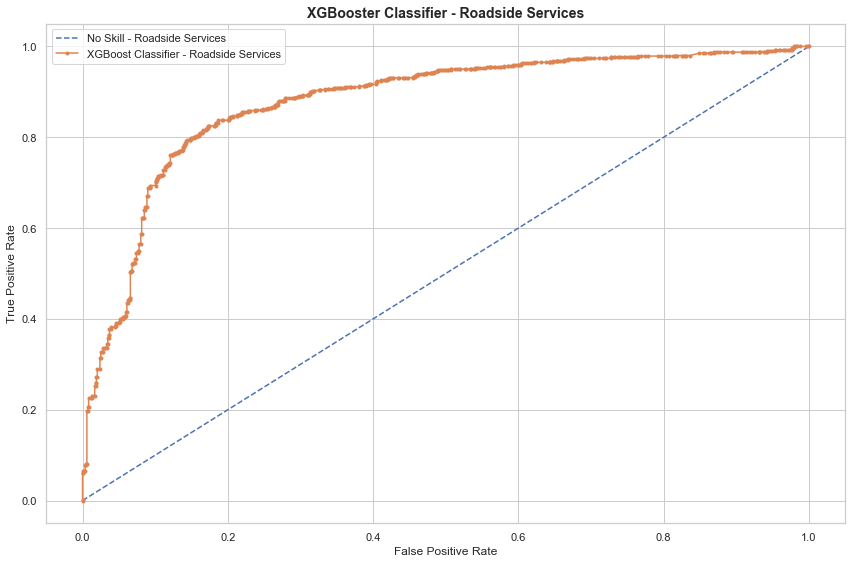

In [375]:
# Modeling based on the outcome of the grid serach of the random forest
xgb = xgb = XGBClassifier(objective= 'binary:logistic',nthread=4, gamma=0.1,
                          learning_rate=0.1, max_depth=8, min_child_weight=2,
                          n_estimators=200                        
                         )
xgb.fit(trainX, trainy)

# Predict on test set
yhat = xgb.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
xgb_probs = xgb.predict_proba(testX)

# Keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
xgb_auc = roc_auc_score(testy, xgb_probs)

# Calculate Cross valdation scores
scores_xgb = cross_val_score(xgb, testX, testy, cv=num_folds)

print("XGBoost Classifier - Accuracy on training set: {:.3f}".format(xgb.score(trainX, trainy)))
print("XGBoost Classifier - Accuracy on test set: {:.3f}".format(xgb.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('XGBoost Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('XGBoost Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('XGBoost Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('XGBoost Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('XGBoost Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('XGBoost Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('XGBoost Classifier - ROC AUC                    : %.3f' % (xgb_auc))
print("XGBoost Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(testy, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_xgb_roc')
plt.show()

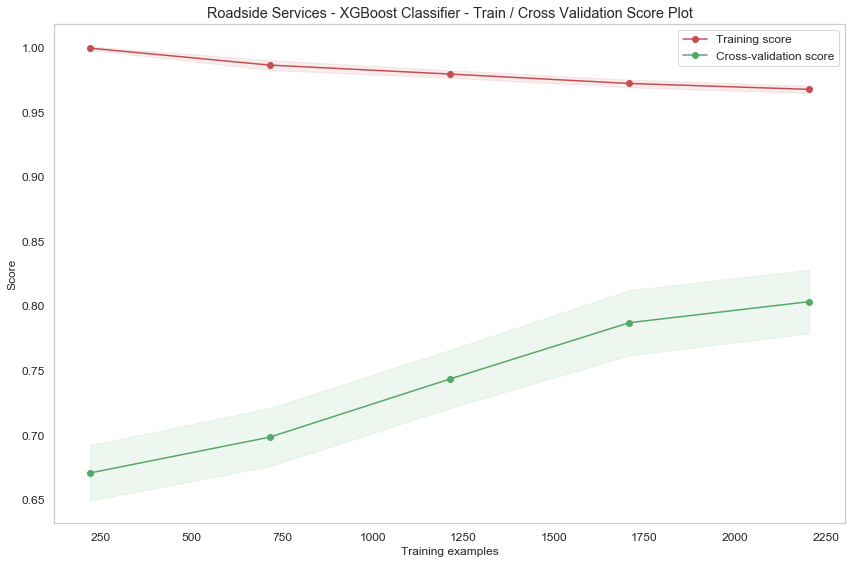

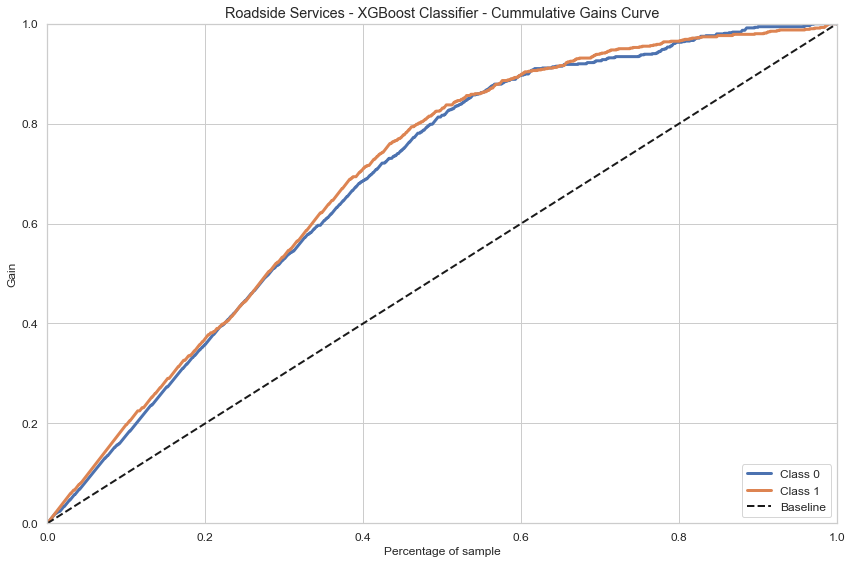

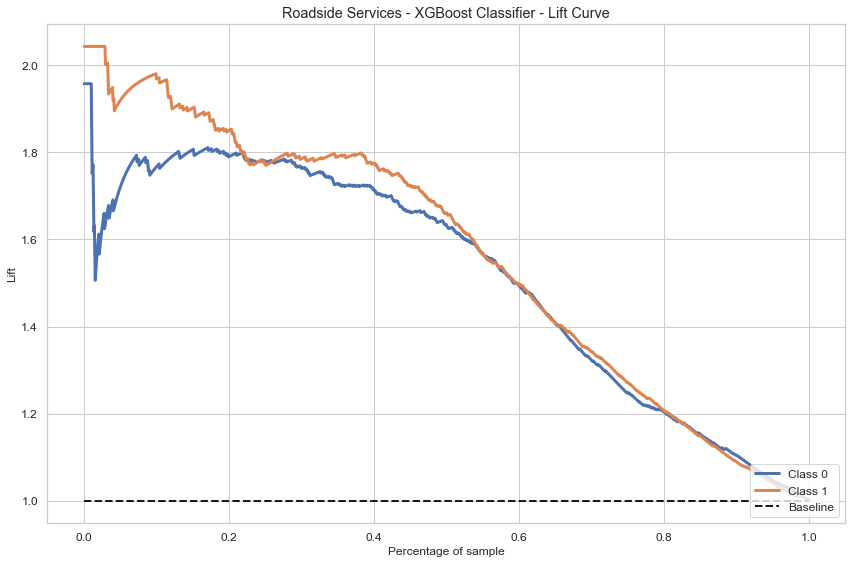

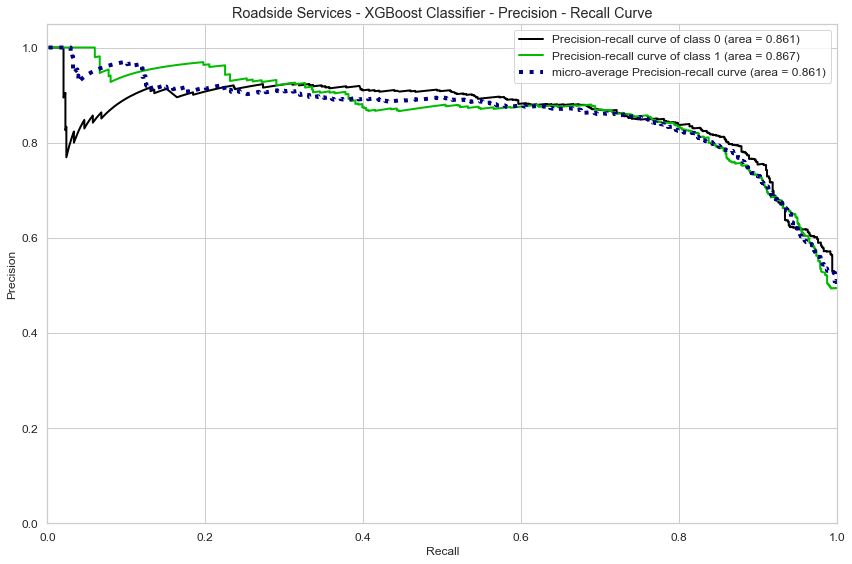

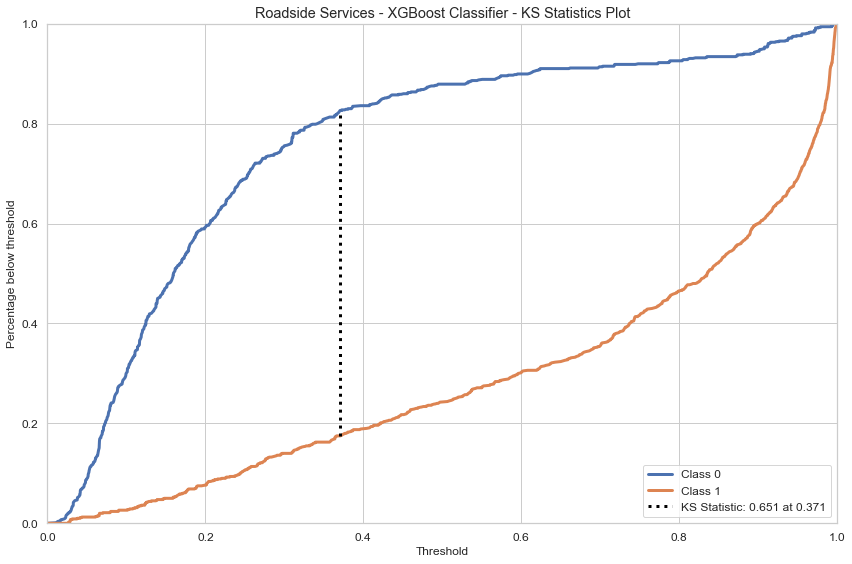

In [376]:
# Train / Cross Validation Score Plot
skplt.estimators.plot_learning_curve(xgb, trainX, trainy, cv=num_folds, title=var_to_predict_title + ' - XGBoost Classifier - Train / Cross Validation Score Plot')
plt.savefig(var_to_predict_save+'_xgb_txcval')
plt.show()

# Cummulative Gain Plot
skplt.metrics.plot_cumulative_gain(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Cummulative Gains Curve')
plt.savefig(var_to_predict_save+'_xgb_cgc')
plt.show()

# Lift Curve Plot
skplt.metrics.plot_lift_curve(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Lift Curve')
plt.savefig(var_to_predict_save+'_xgb_liftc')
plt.show()

# Precision - Recall Curve
skplt.metrics.plot_precision_recall_curve(testy,xgb.predict_proba(testX), title=var_to_predict_title + ' - XGBoost Classifier - Precision - Recall Curve')
plt.savefig(var_to_predict_save+'_xgb_prerecc')
plt.show()

# KS statistics Plot
skplt.metrics.plot_ks_statistic(testy, xgb.predict_proba(testX), title=var_to_predict_title+' - XGBoost Classifier - KS Statistics Plot')
plt.savefig(var_to_predict_save+'_xgb_ksst')
plt.show()

In [377]:
coef_df_xgb = pd.DataFrame({'feature':testX.columns, 'coefs': xgb.feature_importances_})
coef_df_xgb["abs_coeff"] = coef_df_xgb['coefs'].abs()
coef_df_xgb.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_xgb.nlargest(30,columns=["abs_coeff"])
counts_xgb = pd.DataFrame(coef_df_xgb.nlargest(30,columns=["abs_coeff"]), index=None)
counts_xgb.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_xgb, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_xgb_coef.png')
py.iplot(fig)

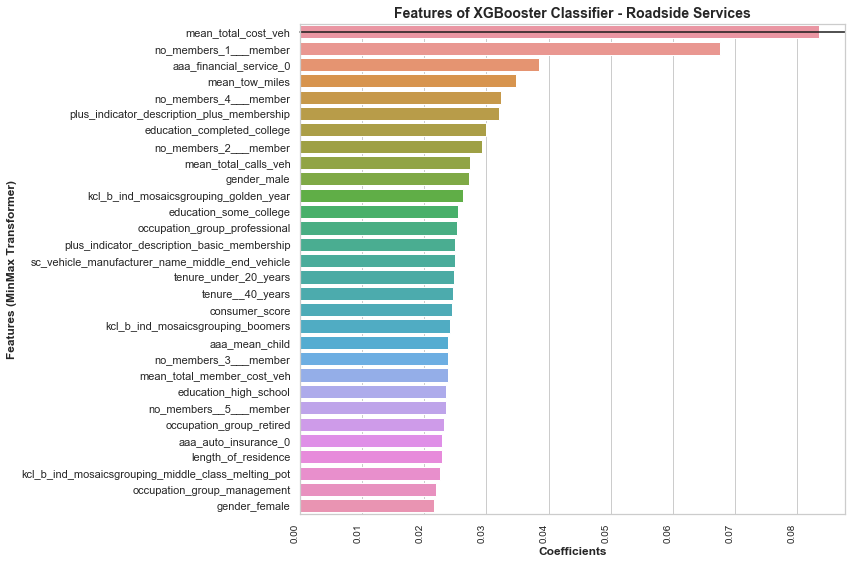

In [378]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_xgb['Features (MinMax Transformer)'], x=counts_xgb['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_xgb_coef_1')
plt.show()

# Keras Modeling

In [324]:
# Keras Classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


np.random.seed(42)
# Create input and output dataframes

num_folds = 10
scoring = 'accuracy'

# create model
keras_nn = Sequential()
keras_nn.add(Dense(trainX.shape[1], input_dim=trainX.shape[1], activation='relu'))
keras_nn.add(Dropout(0.2))
keras_nn.add(Dense(int(trainX.shape[1]/2), activation='relu'))
keras_nn.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.01, momentum=0.8)
keras_nn.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[scoring])
# Fit the model
history = keras_nn.fit(trainX, trainy, validation_data=(testX,testy), epochs=150, batch_size=10, verbose=1)
# evaluate the model
scores = keras_nn.evaluate(trainX, trainy, verbose=0)
print("Keras - Accuracy Train Set : %.3f" % scores[1])
scores = keras_nn.evaluate(testX, testy, verbose=0)
print("Keras - Accuracy Test Set  : %.3f" % scores[1])

Using TensorFlow backend.


Train on 2451 samples, validate on 1635 samples
Epoch 1/150
2451/2451 [==============================] - 1s 480us/step - loss: 0.6558 - accuracy: 0.6161 - val_loss: 0.6203 - val_accuracy: 0.6654
Epoch 2/150
2451/2451 [==============================] - 1s 225us/step - loss: 0.6146 - accuracy: 0.6654 - val_loss: 0.6070 - val_accuracy: 0.6697
Epoch 3/150
2451/2451 [==============================] - 1s 243us/step - loss: 0.6073 - accuracy: 0.6744 - val_loss: 0.5980 - val_accuracy: 0.6856
Epoch 4/150
2451/2451 [==============================] - 1s 233us/step - loss: 0.5962 - accuracy: 0.6883 - val_loss: 0.5970 - val_accuracy: 0.6826
Epoch 5/150
2451/2451 [==============================] - 1s 228us/step - loss: 0.5917 - accuracy: 0.6822 - val_loss: 0.5887 - val_accuracy: 0.6826
Epoch 6/150
2451/2451 [==============================] - 1s 237us/step - loss: 0.5842 - accuracy: 0.6854 - val_loss: 0.6008 - val_accuracy: 0.6734
Epoch 7/150
2451/2451 [==============================] - 1s 234us/step

2451/2451 [==============================] - 1s 228us/step - loss: 0.4456 - accuracy: 0.7760 - val_loss: 0.5410 - val_accuracy: 0.7315
Epoch 57/150
2451/2451 [==============================] - 1s 211us/step - loss: 0.4442 - accuracy: 0.7768 - val_loss: 0.5407 - val_accuracy: 0.7425
Epoch 58/150
2451/2451 [==============================] - 1s 223us/step - loss: 0.4378 - accuracy: 0.7874 - val_loss: 0.5445 - val_accuracy: 0.7468
Epoch 59/150
2451/2451 [==============================] - 1s 215us/step - loss: 0.4294 - accuracy: 0.7895 - val_loss: 0.5408 - val_accuracy: 0.7364
Epoch 60/150
2451/2451 [==============================] - 1s 226us/step - loss: 0.4268 - accuracy: 0.7878 - val_loss: 0.5360 - val_accuracy: 0.7388
Epoch 61/150
2451/2451 [==============================] - 1s 222us/step - loss: 0.4287 - accuracy: 0.7940 - val_loss: 0.5316 - val_accuracy: 0.7431
Epoch 62/150
2451/2451 [==============================] - 1s 222us/step - loss: 0.4254 - accuracy: 0.7940 - val_loss: 0.5333 

2451/2451 [==============================] - 1s 251us/step - loss: 0.3651 - accuracy: 0.8229 - val_loss: 0.5882 - val_accuracy: 0.7688
Epoch 112/150
2451/2451 [==============================] - 1s 223us/step - loss: 0.3504 - accuracy: 0.8323 - val_loss: 0.5668 - val_accuracy: 0.7694
Epoch 113/150
2451/2451 [==============================] - 1s 223us/step - loss: 0.3574 - accuracy: 0.8319 - val_loss: 0.5825 - val_accuracy: 0.7633
Epoch 114/150
2451/2451 [==============================] - 1s 215us/step - loss: 0.3438 - accuracy: 0.8364 - val_loss: 0.5817 - val_accuracy: 0.7633
Epoch 115/150
2451/2451 [==============================] - 1s 223us/step - loss: 0.3581 - accuracy: 0.8335 - val_loss: 0.5821 - val_accuracy: 0.7682
Epoch 116/150
2451/2451 [==============================] - 1s 215us/step - loss: 0.3501 - accuracy: 0.8348 - val_loss: 0.5802 - val_accuracy: 0.7749
Epoch 117/150
2451/2451 [==============================] - 1s 222us/step - loss: 0.3541 - accuracy: 0.8327 - val_loss: 0

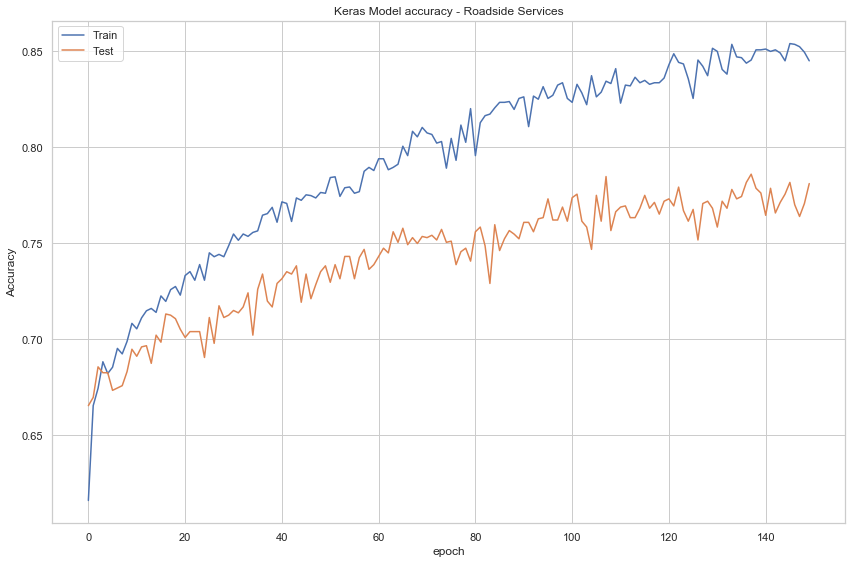

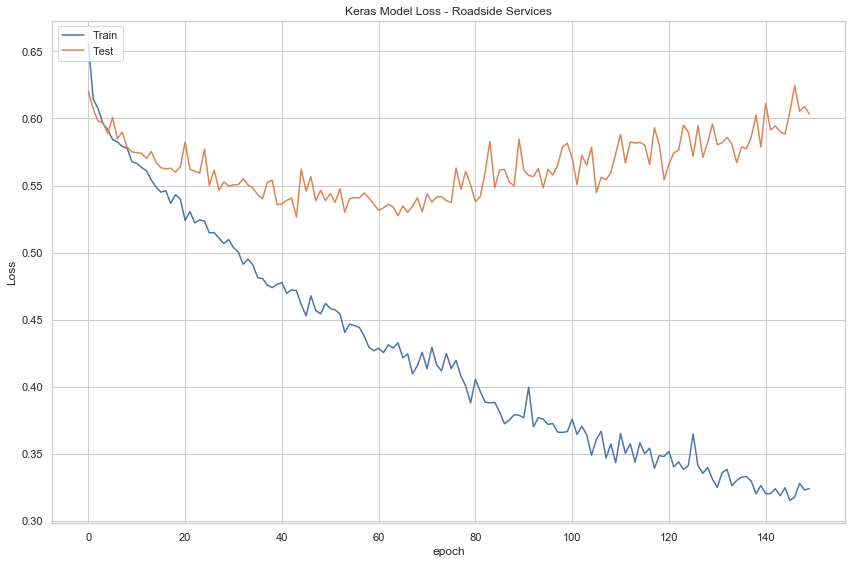

In [326]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Keras Model accuracy - '+var_to_predict_title )
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_1')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras Model Loss - '+ var_to_predict_title)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_2')
plt.show()

# Not used from this point below. 

# SVM Model

In [327]:
# SVM grid search evaluation

np.random.seed(42)
num_folds = 10
scoring = 'accuracy'

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5, 2.7, 3.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.678091 using {'C': 3.0, 'kernel': 'rbf'}
0.676459 (0.028809) with: {'C': 0.1, 'kernel': 'linear'}
0.507140 (0.014862) with: {'C': 0.1, 'kernel': 'poly'}
0.676459 (0.028809) with: {'C': 0.1, 'kernel': 'rbf'}
0.675235 (0.025902) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.676459 (0.028809) with: {'C': 0.3, 'kernel': 'linear'}
0.507140 (0.014862) with: {'C': 0.3, 'kernel': 'poly'}
0.676459 (0.028809) with: {'C': 0.3, 'kernel': 'rbf'}
0.676459 (0.028809) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.676051 (0.029050) with: {'C': 0.5, 'kernel': 'linear'}
0.507140 (0.014862) with: {'C': 0.5, 'kernel': 'poly'}
0.676459 (0.028809) with: {'C': 0.5, 'kernel': 'rbf'}
0.676459 (0.028809) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.676051 (0.029050) with: {'C': 0.7, 'kernel': 'linear'}
0.507140 (0.014862) with: {'C': 0.7, 'kernel': 'poly'}
0.676459 (0.028809) with: {'C': 0.7, 'kernel': 'rbf'}
0.676459 (0.028809) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.676051 (0.029050) with: {'C': 0.9, 'kernel': 'linear'

# Scaler Testing

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over[var_to_predict[0]].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();